In [1]:
# Import stardard python libraries:
import numpy as np
import matplotlib.pyplot as plt

# Import astropy, mirage, seaborn for plots:
import batman
from astropy.io import fits
import astropy.units as q
from mirage.soss_simulator import SossSim, SossSeedSim

# Import utils script:
import utils

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-031 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-036
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## 1. Introduction
---------------

Let's first use our `utils` script to generate a stellar spectrum consistent with WASP-43. First, define stellar properties of WASP-43:

In [2]:
teff, logg, feh, jmag = 4520, 4.6, -0.01, 8

Our `utils` script can get the closest ATLAS or PHOENIX spectrum for those properties. Let's use the ATLAS spectrum:

In [3]:
star_wavelength, star_flux = utils.get_stellar_model(teff=teff, logg=logg, feh=feh, jmag=jmag)

Let's plot this:

Text(0.5, 1.0, 'Stellar spectrum of WASP-43')

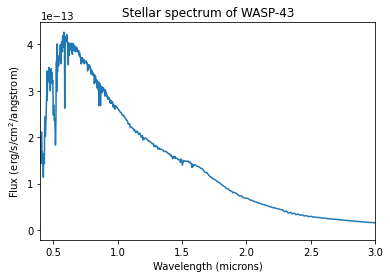

In [4]:
plt.plot(star_wavelength, star_flux)
plt.xlim(0.4,3.)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (erg/s/cm$^2$/angstrom)')
plt.title('Stellar spectrum of WASP-43')

Let's similarly define a flat transit spectrum for WASP-43b:

Text(0.5, 1.0, 'Transmission spectrum of WASP-43b')

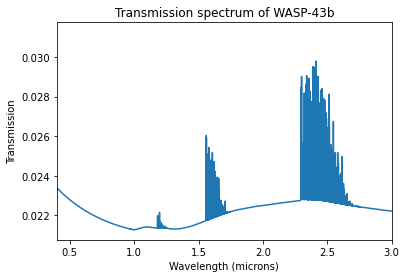

In [5]:
planet_wavenum, planet_tspectrum = np.genfromtxt('files/WASP43b_transmission.dat', unpack=True)
planet_wavelength = ((1./planet_wavenum) * q.cm).to(q.um)[::-1]
planet_tspectrum = planet_tspectrum[::-1]

plt.plot(planet_wavelength, planet_tspectrum)
plt.xlim(0.4,3.)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transmission')
plt.title('Transmission spectrum of WASP-43b')

## 2. Running `mirage`
---------------

All right, now we can do a test run of `mirage` with SOSS --- note I'm using _my_ fork of `mirage` (https://github.com/nespinoza/mirage/tree/add_soss) which fixes some bugs we were seeing. 

### 2.1 Setting the transit model

The very first thing we need to do is to generate a transit model `tmodel` and its parameters `params` using `batman` so `mirage` can inject those into the PSFs themselves. 

We first get the properties of WASP-43b from Kreidberg et al. (2014), and inject those in the `params` object. Let's assume we will be observing the transit of WASP-43b which occurrs on `2459819.131474` (August 27, 2022 --- at about 15:09 UT; note the `yaml` file is set to observe around this time indeed): 

In [6]:
params = batman.TransitParams()
params.t0 = 2455528.8684
params.per = 0.81347436
params.a = 4.87
params.inc = 82.10
params.ecc = 0.
params.w = 90.
params.limb_dark = 'quadratic'
params.u = [0.5,0.5]   # These are placeholders; they are changed internally
params.rp = 0.1166445  # These are placeholders; they are changed internally

Now create the `TransitModel` object; inject stellar info as well here. This is useful for calculating limb-darkening:

In [7]:
tmodel = batman.TransitModel(params, np.array([0.])) # Time array is placeholder, will be changed internally by MIRAGE
tmodel.teff, tmodel.logg, tmodel.feh = teff, logg, feh

### 2.2 Run CLEAR simulation with `mirage.soss_simulator.SossSim`

All right, now we ingest all this to `mirage` --- if you don't have `exoctk`, this will set limb-darkening to zero (which is what we want for now I believe!):

In [8]:
sim = SossSim(paramfile = 'files/niriss_soss_substrip256_clear.yaml', \
              star=[star_wavelength, star_flux], \
              planet=[planet_wavelength, planet_tspectrum],\
              tmodel=tmodel)

cannot import name 'modelgrid' from 'exoctk' (unknown location)
There was a problem computing those limb darkening coefficients. Using all zeros.
cannot import name 'modelgrid' from 'exoctk' (unknown location)
There was a problem computing those limb darkening coefficients. Using all zeros.


And, let's create the exposure! This should take a while (~3.75 hours):

In [9]:
sim.create()

2021-06-02 00:26:16,849 - mirage.soss_simulator - INFO - 

Running soss_simulator....



2021-06-02 00:26:16,849 - stpipe - INFO - 

Running soss_simulator....



2021-06-02 00:26:16,849 - stpipe - INFO - 

Running soss_simulator....

2021-06-02 00:26:16,852 - mirage.soss_simulator - INFO - Using parameter file: 


2021-06-02 00:26:16,852 - stpipe - INFO - Using parameter file: 


2021-06-02 00:26:16,852 - stpipe - INFO - Using parameter file: 
2021-06-02 00:26:16,854 - mirage.soss_simulator - INFO - files/niriss_soss_substrip256_clear.yaml


2021-06-02 00:26:16,854 - stpipe - INFO - files/niriss_soss_substrip256_clear.yaml


2021-06-02 00:26:16,854 - stpipe - INFO - files/niriss_soss_substrip256_clear.yaml
Simulating WASP43 in WASP43 transit observation
Configuration: SUBSTRIP256 + CLEAR
Groups: 6, Integrations: 320

Constructing frames for chunk 1/40...
Chunk 1/40 finished: 68.035 s
Constructing frames for chunk 2/40...
Chunk 2/40 finished: 60.021 s
Constructing frames for chunk 3/40...
Chunk 3/40 finished: 62.077 s
Constructing frames for chunk 4/40...
Chunk 4/40 finished: 66.988 s
Constructing frames for chunk 5/40...
Chunk 5/40 finished: 62.465 s
Constructing frames for chunk 6/40...
Chunk 6/40 finished: 61.338 s
Constructing frames for chunk 7/40...
Chunk 7/40 finished: 66.055 s
Constructing frames for chunk 8/40...
Chunk 8/40 finished: 64.32 s
Constructing frames for chunk 9/40...
Chunk 9/40 finished: 65.14 s
Constructing frames for chunk 10/40...
Chunk 10/40 finished: 64.999 s
Constructing frames for chunk 11/40...
Chunk 11/40 finished: 64.103 s
Constructing frames for chunk 12/40...
Chunk 12/40 fin

2021-06-02 01:12:53,930 - stpipe - INFO - Running dark prep


2021-06-02 01:12:53,930 - stpipe - INFO - Running dark prep
2021-06-02 01:12:53,963 - mirage.dark.dark_prep - INFO - 

Running dark_prep..



2021-06-02 01:12:53,963 - stpipe - INFO - 

Running dark_prep..



2021-06-02 01:12:53,963 - stpipe - INFO - 

Running dark_prep..

2021-06-02 01:12:53,965 - mirage.dark.dark_prep - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml



2021-06-02 01:12:53,965 - stpipe - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml



2021-06-02 01:12:53,965 - stpipe - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml

2021-06-02 01:12:53,967 - mirage.dark.dark_prep - INFO - Original log file name: ./mirage_latest.log


2021-06-02 01:12:53,967 - stpipe - INFO - Original log file name: ./mirage_latest.log


2021-06-02 01:12:53,967 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-06-02 01:12:53,976 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.


2021-06-02 01:12:53,976 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.


2021-06-02 01:12:53,976 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
2021-06-02 01:12:53,979 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.


2021-06-02 01:12:53,979 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.


2021-06-02 01:12:53,979 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.
2021-06-02 01:12:53,981 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.


2021-06-02 01:12:53,981 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.


2021-06-02 01:12:53,981 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.
2021-06-02 01:12:53,984 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.


2021-06-02 01:12:53,984 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.


2021-06-02 01:12:53,984 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.
2021-06-02 01:12:53,986 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.


2021-06-02 01:12:53,986 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.


2021-06-02 01:12:53,986 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
2021-06-02 01:12:53,989 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.


2021-06-02 01:12:53,989 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.


2021-06-02 01:12:53,989 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.
2021-06-02 01:12:53,991 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.


2021-06-02 01:12:53,991 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.


2021-06-02 01:12:53,991 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
2021-06-02 01:12:53,995 - mirage.utils.utils.full_paths - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits


2021-06-02 01:12:53,995 - stpipe - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits


2021-06-02 01:12:53,995 - stpipe - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
2021-06-02 01:12:53,997 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.


2021-06-02 01:12:53,997 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.


2021-06-02 01:12:53,997 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.
2021-06-02 01:12:53,999 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file


2021-06-02 01:12:53,999 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file


2021-06-02 01:12:53,999 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file
2021-06-02 01:12:54,001 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.


2021-06-02 01:12:54,001 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.


2021-06-02 01:12:54,001 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.
2021-06-02 01:12:54,003 - mirage.utils.utils.full_paths - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"


2021-06-02 01:12:54,003 - stpipe - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"


2021-06-02 01:12:54,003 - stpipe - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"
2021-06-02 01:12:54,006 - mirage.reference_files.utils.get_transmission_file - INFO - POM Transmission filename: None


2021-06-02 01:12:54,006 - stpipe - INFO - POM Transmission filename: None


2021-06-02 01:12:54,006 - stpipe - INFO - POM Transmission filename: None
2021-06-02 01:12:54,008 - mirage.utils.utils.full_paths - INFO - From grism library, found None as the POM transmission file.


2021-06-02 01:12:54,008 - stpipe - INFO - From grism library, found None as the POM transmission file.


2021-06-02 01:12:54,008 - stpipe - INFO - From grism library, found None as the POM transmission file.
2021-06-02 01:12:54,010 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file


2021-06-02 01:12:54,010 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file


2021-06-02 01:12:54,010 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file
2021-06-02 01:12:54,012 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file


2021-06-02 01:12:54,012 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file


2021-06-02 01:12:54,012 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file
2021-06-02 01:12:54,014 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file


2021-06-02 01:12:54,014 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file


2021-06-02 01:12:54,014 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file
2021-06-02 01:12:54,016 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file


2021-06-02 01:12:54,016 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file


2021-06-02 01:12:54,016 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file
2021-06-02 01:12:54,017 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file


2021-06-02 01:12:54,017 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file


2021-06-02 01:12:54,017 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
2021-06-02 01:12:54,019 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file


2021-06-02 01:12:54,019 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file


2021-06-02 01:12:54,019 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file
2021-06-02 01:12:54,021 - mirage.utils.utils.full_paths - INFO - Reffiles:photom field not present in input. Setting equal to "crds"


2021-06-02 01:12:54,021 - stpipe - INFO - Reffiles:photom field not present in input. Setting equal to "crds"


2021-06-02 01:12:54,021 - stpipe - INFO - Reffiles:photom field not present in input. Setting equal to "crds"
2021-06-02 01:12:54,023 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.


2021-06-02 01:12:54,023 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.


2021-06-02 01:12:54,023 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.
2021-06-02 01:12:54,025 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file


2021-06-02 01:12:54,025 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file


2021-06-02 01:12:54,025 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file
2021-06-02 01:12:54,027 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file


2021-06-02 01:12:54,027 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file


2021-06-02 01:12:54,027 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file
2021-06-02 01:12:54,029 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file


2021-06-02 01:12:54,029 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file


2021-06-02 01:12:54,029 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file
2021-06-02 01:12:54,031 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file


2021-06-02 01:12:54,031 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file


2021-06-02 01:12:54,031 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file
2021-06-02 01:12:54,032 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file


2021-06-02 01:12:54,032 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file


2021-06-02 01:12:54,032 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file
2021-06-02 01:12:54,034 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file


2021-06-02 01:12:54,034 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file


2021-06-02 01:12:54,034 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file
2021-06-02 01:12:54,048 - mirage.dark.dark_prep - INFO - Requested readout pattern NISRAPID is valid. Using the nframe = 1 and nskip = 0


2021-06-02 01:12:54,048 - stpipe - INFO - Requested readout pattern NISRAPID is valid. Using the nframe = 1 and nskip = 0


2021-06-02 01:12:54,048 - stpipe - INFO - Requested readout pattern NISRAPID is valid. Using the nframe = 1 and nskip = 0
2021-06-02 01:12:54,102 - mirage.utils.file_splitting.find_file_splits - INFO - Splitting by integration:


2021-06-02 01:12:54,102 - stpipe - INFO - Splitting by integration:


2021-06-02 01:12:54,102 - stpipe - INFO - Splitting by integration:
2021-06-02 01:12:54,105 - mirage.utils.file_splitting.find_file_splits - INFO - integration_list: [  0 213 320]


2021-06-02 01:12:54,105 - stpipe - INFO - integration_list: [  0 213 320]


2021-06-02 01:12:54,105 - stpipe - INFO - integration_list: [  0 213 320]
2021-06-02 01:12:54,107 - mirage.utils.file_splitting.find_file_splits - INFO - group_list: [0 6]


2021-06-02 01:12:54,107 - stpipe - INFO - group_list: [0 6]


2021-06-02 01:12:54,107 - stpipe - INFO - group_list: [0 6]
2021-06-02 01:12:54,108 - mirage.dark.dark_prep - INFO - An estimate of processing time remaining will be provided after the first segment has been completed.




2021-06-02 01:12:54,108 - stpipe - INFO - An estimate of processing time remaining will be provided after the first segment has been completed.




2021-06-02 01:12:54,108 - stpipe - INFO - An estimate of processing time remaining will be provided after the first segment has been completed.


2021-06-02 01:12:54,111 - mirage.dark.dark_prep - INFO - Segment number: 0


2021-06-02 01:12:54,111 - stpipe - INFO - Segment number: 0


2021-06-02 01:12:54,111 - stpipe - INFO - Segment number: 0
2021-06-02 01:12:54,113 - mirage.dark.dark_prep - INFO - Number of integrations: 213


2021-06-02 01:12:54,113 - stpipe - INFO - Number of integrations: 213


2021-06-02 01:12:54,113 - stpipe - INFO - Number of integrations: 213
2021-06-02 01:12:54,115 - mirage.dark.dark_prep - INFO - Dark files to use:


2021-06-02 01:12:54,115 - stpipe - INFO - Dark files to use:


2021-06-02 01:12:54,115 - stpipe - INFO - Dark files to use:
2021-06-02 01:12:54,117 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:12:54,117 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:12:54,117 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits
2021-06-02 01:12:54,119 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:12:54,119 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:12:54,119 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits
2021-06-02 01:12:54,121 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:12:54,121 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:12:54,121 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits
2021-06-02 01:12:54,123 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:12:54,123 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:12:54,123 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits
2021-06-02 01:12:54,124 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:12:54,124 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:12:54,124 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits
2021-06-02 01:12:54,126 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:12:54,126 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:12:54,126 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits
2021-06-02 01:12:54,127 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:12:54,127 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:12:54,127 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits
2021-06-02 01:12:54,130 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:12:54,130 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:12:54,130 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits
2021-06-02 01:12:54,132 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:12:54,132 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:12:54,132 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits
2021-06-02 01:12:54,134 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:12:54,134 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:12:54,134 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits
2021-06-02 01:12:54,136 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:12:54,136 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:12:54,136 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits
2021-06-02 01:12:54,137 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:12:54,137 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:12:54,137 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits
2021-06-02 01:12:54,139 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:12:54,139 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:12:54,139 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits
2021-06-02 01:12:54,141 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:12:54,141 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:12:54,141 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits
2021-06-02 01:12:54,142 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:12:54,142 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:12:54,142 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits
2021-06-02 01:12:54,145 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:12:54,145 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:12:54,145 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits
2021-06-02 01:12:54,147 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:12:54,147 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:12:54,147 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits
2021-06-02 01:12:54,150 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:12:54,150 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:12:54,150 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits
2021-06-02 01:12:54,153 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:12:54,153 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:12:54,153 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits
2021-06-02 01:12:54,155 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:12:54,155 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:12:54,155 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits
2021-06-02 01:12:54,158 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:12:54,158 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:12:54,158 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits
2021-06-02 01:12:57,660 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:12:57,660 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:12:57,660 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:12:58,010 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:12:58,010 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:12:58,010 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:12:58,021 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:12:58,021 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:12:58,021 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:13:02,880 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:02,880 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:02,880 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:02,911 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:02,911 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:03,279 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:03,279 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:03,282 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:03,282 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:03,296 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:03,296 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:03,679 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:03,679 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:03,694 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:03,694 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:03,764 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:03,764 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:03,767 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:03,767 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:03,783 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:13:03,783 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:13:03,877 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:03,877 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:03,877 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:13:04,228 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:13:04,228 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:13:04,228 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:13:04,252 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:04,252 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:04,252 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:04,260 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:04,260 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:04,275 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:04,275 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:04,373 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:04,373 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:04,376 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:04,376 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:04,393 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:04,393 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:04,560 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:04,560 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:04,576 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:04,576 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:04,673 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:04,673 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:04,675 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:04,675 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:04,686 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:04,686 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:04,688 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:04,688 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:04,690 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:04,690 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:04,691 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:04,691 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:04,693 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:04,693 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:06,503 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:06,503 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:06,563 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:06,563 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:06,653 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:06,653 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:06,656 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:06,656 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:06,671 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:13:06,671 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:13:06,835 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:06,835 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:06,835 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:07,320 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:13:07,320 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:13:07,322 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:07,322 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:07,322 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:13:07,324 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:07,324 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:07,324 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:13:07,326 - mirage.dark.dark_prep - INFO - File number 0 will be used for integrations [  0  14  16  22  50  64  75  79  98 100 130 143 168 180 207]


2021-06-02 01:13:07,326 - stpipe - INFO - File number 0 will be used for integrations [  0  14  16  22  50  64  75  79  98 100 130 143 168 180 207]


2021-06-02 01:13:07,326 - stpipe - INFO - File number 0 will be used for integrations [  0  14  16  22  50  64  75  79  98 100 130 143 168 180 207]
2021-06-02 01:13:07,533 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:13:07,533 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:13:07,533 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits
2021-06-02 01:13:11,426 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:11,426 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:11,426 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:13:11,749 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:11,749 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:11,749 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:13:11,760 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:11,760 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:11,760 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:13:15,587 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:15,587 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:15,587 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:15,739 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:15,739 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:16,320 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:16,320 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:16,323 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:16,323 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:16,337 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:16,337 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:16,691 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:16,691 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:16,706 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:16,706 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:16,779 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:16,779 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:16,782 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:16,782 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:16,796 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:13:16,796 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:13:16,875 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:16,875 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:16,875 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:13:17,145 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:13:17,145 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:13:17,145 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:13:17,168 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:17,168 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:17,168 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:17,176 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:17,176 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:17,191 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:17,191 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:17,281 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:17,281 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:17,284 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:17,284 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:17,300 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:17,300 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:17,453 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:17,453 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:17,469 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:17,469 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:17,565 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:17,565 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:17,567 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:17,567 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:17,581 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:17,581 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:17,583 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:17,583 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:17,585 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:17,585 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:17,586 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:17,586 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:17,588 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:17,588 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:19,479 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:19,479 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:19,518 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:19,518 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:19,609 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:19,609 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:19,612 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:19,612 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:19,627 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:13:19,627 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:13:19,733 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:19,733 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:19,733 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:20,207 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:13:20,207 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:13:20,209 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:20,209 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:20,209 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:13:20,211 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:20,211 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:20,211 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:13:20,227 - mirage.dark.dark_prep - INFO - File number 1 will be used for integrations [  7  20  45  62  70  91 132 142 196 198 209 212]


2021-06-02 01:13:20,227 - stpipe - INFO - File number 1 will be used for integrations [  7  20  45  62  70  91 132 142 196 198 209 212]


2021-06-02 01:13:20,227 - stpipe - INFO - File number 1 will be used for integrations [  7  20  45  62  70  91 132 142 196 198 209 212]
2021-06-02 01:13:20,387 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:13:20,387 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:13:20,387 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits
2021-06-02 01:13:24,820 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:24,820 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:24,820 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:13:25,195 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:25,195 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:25,195 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:13:25,207 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:25,207 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:25,207 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:13:28,734 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:28,734 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:28,734 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:28,868 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:28,868 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:29,431 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:29,431 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:29,434 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:29,434 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:29,448 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:29,448 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:29,782 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:29,782 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:29,800 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:29,800 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:29,873 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:29,873 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:29,876 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:29,876 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:29,890 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:13:29,890 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:13:29,965 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:29,965 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:29,965 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:13:30,233 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:13:30,233 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:13:30,233 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:13:30,257 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:30,257 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:30,257 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:30,265 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:30,265 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:30,280 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:30,280 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:30,372 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:30,372 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:30,374 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:30,374 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:30,389 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:30,389 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:30,544 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:30,544 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:30,562 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:30,562 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:30,658 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:30,658 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:30,661 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:30,661 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:30,675 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:30,675 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:30,677 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:30,677 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:30,679 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:30,679 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:30,681 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:30,681 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:30,682 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:30,682 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:32,518 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:32,518 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:32,551 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:32,551 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:32,645 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:32,645 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:32,648 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:32,648 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:32,664 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:13:32,664 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:13:32,772 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:32,772 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:32,772 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:33,274 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:13:33,274 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:13:33,276 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:33,276 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:33,276 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:13:33,278 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:33,278 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:33,278 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:13:33,294 - mirage.dark.dark_prep - INFO - File number 2 will be used for integrations [ 46  54  55  87 125 145 187 188 197]


2021-06-02 01:13:33,294 - stpipe - INFO - File number 2 will be used for integrations [ 46  54  55  87 125 145 187 188 197]


2021-06-02 01:13:33,294 - stpipe - INFO - File number 2 will be used for integrations [ 46  54  55  87 125 145 187 188 197]
2021-06-02 01:13:33,414 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:13:33,414 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:13:33,414 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits
2021-06-02 01:13:37,912 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:37,912 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:37,912 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:13:38,308 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:38,308 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:38,308 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:13:38,321 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:38,321 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:38,321 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:13:42,787 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:42,787 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:42,787 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:43,017 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:43,017 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:43,639 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:43,639 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:43,642 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:43,642 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:43,656 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:43,656 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:44,024 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:44,024 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:44,041 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:44,041 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:44,117 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:44,117 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:44,121 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:44,121 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:44,138 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:13:44,138 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:13:44,223 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:44,223 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:44,223 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:13:44,501 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:13:44,501 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:13:44,501 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:13:44,527 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:44,527 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:44,527 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:44,534 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:44,534 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:44,550 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:44,550 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:44,646 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:44,646 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:44,650 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:44,650 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:44,666 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:44,666 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:44,828 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:44,828 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:44,846 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:44,846 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:44,943 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:44,943 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:44,946 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:44,946 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:44,962 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:44,962 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:44,964 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:44,964 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:44,966 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:44,966 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:44,967 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:44,967 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:44,969 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:44,969 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:47,020 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:47,020 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:47,064 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:47,064 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:47,159 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:47,159 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:47,162 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:47,162 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:47,177 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:13:47,177 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:13:47,325 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:47,325 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:47,325 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:47,831 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:13:47,831 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:13:47,833 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:47,833 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:13:47,833 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:13:47,836 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:47,836 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:13:47,836 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:13:47,855 - mirage.dark.dark_prep - INFO - File number 3 will be used for integrations [ 56  99 116 131 150 151 158 179 182]


2021-06-02 01:13:47,855 - stpipe - INFO - File number 3 will be used for integrations [ 56  99 116 131 150 151 158 179 182]


2021-06-02 01:13:47,855 - stpipe - INFO - File number 3 will be used for integrations [ 56  99 116 131 150 151 158 179 182]
2021-06-02 01:13:47,979 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:13:47,979 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:13:47,979 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits
2021-06-02 01:13:51,740 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:51,740 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:13:51,740 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:13:52,135 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:52,135 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:13:52,135 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:13:52,148 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:52,148 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:13:52,148 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:13:55,608 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:55,608 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:55,608 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:13:55,748 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:55,748 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:13:56,478 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:56,478 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:56,482 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:56,482 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:56,498 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:56,498 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:13:56,848 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:56,848 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:13:56,863 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:56,863 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:13:56,937 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:56,937 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:56,940 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:56,940 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:56,954 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:13:56,954 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:13:57,031 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:57,031 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:13:57,031 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:13:57,306 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:13:57,306 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:13:57,306 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:13:57,329 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:57,329 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:57,329 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:13:57,336 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:57,336 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:13:57,354 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:57,354 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:13:57,451 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:57,451 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:57,454 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:57,454 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:57,470 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:57,470 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:13:57,630 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:57,630 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:13:57,647 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:57,647 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:13:57,744 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:57,744 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:57,747 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:57,747 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:13:57,764 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:57,764 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:13:57,766 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:57,766 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:13:57,767 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:57,767 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:13:57,769 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:57,769 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:13:57,770 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:57,770 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:13:59,839 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:59,839 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:13:59,880 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:59,880 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:13:59,974 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:59,974 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:13:59,978 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:59,978 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:13:59,991 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:13:59,991 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:14:00,130 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:00,130 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:00,130 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:00,627 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:14:00,627 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:14:00,629 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:00,629 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:00,629 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:14:00,632 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:00,632 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:00,632 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:14:00,648 - mirage.dark.dark_prep - INFO - File number 4 will be used for integrations [ 21  30  31  32  33  53  72  82  90 127 149 175]


2021-06-02 01:14:00,648 - stpipe - INFO - File number 4 will be used for integrations [ 21  30  31  32  33  53  72  82  90 127 149 175]


2021-06-02 01:14:00,648 - stpipe - INFO - File number 4 will be used for integrations [ 21  30  31  32  33  53  72  82  90 127 149 175]
2021-06-02 01:14:00,816 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:14:00,816 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:14:00,816 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits
2021-06-02 01:14:04,240 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:04,240 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:04,240 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:14:04,645 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:04,645 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:04,645 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:14:04,660 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:04,660 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:04,660 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:14:08,434 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:08,434 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:08,434 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:08,571 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:08,571 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:09,161 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:09,161 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:09,163 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:09,163 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:09,178 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:09,178 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:09,564 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:09,564 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:09,581 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:09,581 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:09,658 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:09,658 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:09,662 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:09,662 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:09,679 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:14:09,679 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:14:09,758 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:09,758 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:09,758 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:14:10,023 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:14:10,023 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:14:10,023 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:14:10,045 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:10,045 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:10,045 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:10,054 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:10,054 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:10,069 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:10,069 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:10,162 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:10,162 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:10,165 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:10,165 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:10,180 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:10,180 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:10,341 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:10,341 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:10,359 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:10,359 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:10,459 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:10,459 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:10,463 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:10,463 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:10,477 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:10,477 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:10,479 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:10,479 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:10,481 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:10,481 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:10,482 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:10,482 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:10,484 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:10,484 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:12,576 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:12,576 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:12,614 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:12,614 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:12,707 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:12,707 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:12,710 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:12,710 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:12,724 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:14:12,724 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:14:12,844 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:12,844 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:12,844 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:13,356 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:14:13,356 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:14:13,357 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:13,357 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:13,357 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:14:13,360 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:13,360 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:13,360 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:14:13,377 - mirage.dark.dark_prep - INFO - File number 5 will be used for integrations [  5  13  86 135 138 147 154]


2021-06-02 01:14:13,377 - stpipe - INFO - File number 5 will be used for integrations [  5  13  86 135 138 147 154]


2021-06-02 01:14:13,377 - stpipe - INFO - File number 5 will be used for integrations [  5  13  86 135 138 147 154]
2021-06-02 01:14:13,477 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:14:13,477 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:14:13,477 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits
2021-06-02 01:14:16,588 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:16,588 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:16,588 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:14:16,999 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:16,999 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:16,999 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:14:17,011 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:17,011 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:17,011 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:14:20,729 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:20,729 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:20,729 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:20,862 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:20,862 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:21,448 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:21,448 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:21,451 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:21,451 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:21,469 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:21,469 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:21,824 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:21,824 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:21,842 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:21,842 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:21,920 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:21,920 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:21,923 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:21,923 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:21,938 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:14:21,938 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:14:22,015 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:22,015 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:22,015 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:14:22,282 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:14:22,282 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:14:22,282 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:14:22,304 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:22,304 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:22,304 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:22,312 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:22,312 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:22,327 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:22,327 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:22,422 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:22,422 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:22,425 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:22,425 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:22,441 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:22,441 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:22,603 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:22,603 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:22,620 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:22,620 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:22,718 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:22,718 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:22,721 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:22,721 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:22,737 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:22,737 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:22,739 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:22,739 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:22,741 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:22,741 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:22,742 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:22,742 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:22,744 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:22,744 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:24,827 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:24,827 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:24,871 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:24,871 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:24,963 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:24,963 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:24,966 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:24,966 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:24,980 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:14:24,980 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:14:25,097 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:25,097 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:25,097 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:25,599 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:14:25,599 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:14:25,601 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:25,601 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:25,601 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:14:25,603 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:25,603 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:25,603 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:14:25,617 - mirage.dark.dark_prep - INFO - File number 6 will be used for integrations [  1  18  51 133 152 165 171 195 201]


2021-06-02 01:14:25,617 - stpipe - INFO - File number 6 will be used for integrations [  1  18  51 133 152 165 171 195 201]


2021-06-02 01:14:25,617 - stpipe - INFO - File number 6 will be used for integrations [  1  18  51 133 152 165 171 195 201]
2021-06-02 01:14:25,744 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:14:25,744 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:14:25,744 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits
2021-06-02 01:14:29,030 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:29,030 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:29,030 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:14:29,386 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:29,386 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:29,386 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:14:29,400 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:29,400 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:29,400 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:14:32,751 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:32,751 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:32,751 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:32,888 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:32,888 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:33,485 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:33,485 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:33,488 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:33,488 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:33,502 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:33,502 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:33,871 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:33,871 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:33,889 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:33,889 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:33,965 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:33,965 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:33,968 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:33,968 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:33,982 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:14:33,982 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:14:34,058 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:34,058 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:34,058 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:14:34,326 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:14:34,326 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:14:34,326 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:14:34,348 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:34,348 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:34,348 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:34,356 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:34,356 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:34,371 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:34,371 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:34,467 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:34,467 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:34,471 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:34,471 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:34,487 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:34,487 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:34,648 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:34,648 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:34,665 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:34,665 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:34,761 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:34,761 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:34,764 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:34,764 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:34,777 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:34,777 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:34,779 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:34,779 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:34,780 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:34,780 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:34,782 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:34,782 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:34,784 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:34,784 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:36,817 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:36,817 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:36,860 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:36,860 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:36,953 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:36,953 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:36,957 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:36,957 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:36,971 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:14:36,971 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:14:37,112 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:37,112 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:37,112 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:37,619 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:14:37,619 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:14:37,621 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:37,621 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:37,621 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:14:37,623 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:37,623 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:37,623 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:14:37,639 - mirage.dark.dark_prep - INFO - File number 7 will be used for integrations [  2  28  48  52  57  60  71  73  81  83 139 193 194 210]


2021-06-02 01:14:37,639 - stpipe - INFO - File number 7 will be used for integrations [  2  28  48  52  57  60  71  73  81  83 139 193 194 210]


2021-06-02 01:14:37,639 - stpipe - INFO - File number 7 will be used for integrations [  2  28  48  52  57  60  71  73  81  83 139 193 194 210]
2021-06-02 01:14:37,829 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:14:37,829 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:14:37,829 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits
2021-06-02 01:14:41,571 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:41,571 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:41,571 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:14:42,023 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:42,023 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:42,023 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:14:42,035 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:42,035 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:42,035 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:14:46,575 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:46,575 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:46,575 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:46,784 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:46,784 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:47,345 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:47,345 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:47,348 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:47,348 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:47,362 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:47,362 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:47,724 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:47,724 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:47,741 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:47,741 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:47,819 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:47,819 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:47,822 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:47,822 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:47,836 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:14:47,836 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:14:47,912 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:47,912 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:47,912 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:14:48,173 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:14:48,173 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:14:48,173 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:14:48,195 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:48,195 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:48,195 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:14:48,202 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:48,202 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:14:48,217 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:48,217 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:14:48,315 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:48,315 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:48,319 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:48,319 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:48,334 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:48,334 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:14:48,495 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:48,495 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:14:48,512 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:48,512 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:14:48,607 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:48,607 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:48,610 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:48,610 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:14:48,623 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:48,623 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:14:48,625 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:48,625 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:14:48,626 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:48,626 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:14:48,628 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:48,628 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:14:48,630 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:48,630 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:14:50,728 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:50,728 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:14:50,772 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:50,772 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:14:50,866 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:50,866 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:50,869 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:50,869 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:50,882 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:14:50,882 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:14:50,995 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:50,995 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:50,995 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:14:51,498 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:14:51,498 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:14:51,500 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:51,500 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:14:51,500 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:14:51,503 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:51,503 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:14:51,503 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:14:51,519 - mirage.dark.dark_prep - INFO - File number 8 will be used for integrations [ 40  41  69  88 111 122 126 129 144 153 159 173]


2021-06-02 01:14:51,519 - stpipe - INFO - File number 8 will be used for integrations [ 40  41  69  88 111 122 126 129 144 153 159 173]


2021-06-02 01:14:51,519 - stpipe - INFO - File number 8 will be used for integrations [ 40  41  69  88 111 122 126 129 144 153 159 173]
2021-06-02 01:14:51,685 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:14:51,685 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:14:51,685 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits
2021-06-02 01:14:54,951 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:54,951 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:14:54,951 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:14:55,376 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:55,376 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:14:55,376 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:14:55,390 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:55,390 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:14:55,390 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:14:58,695 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:58,695 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:58,695 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:14:58,820 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:58,820 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:14:59,500 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:59,500 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:59,503 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:59,503 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:59,518 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:59,518 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:14:59,886 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:59,886 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:14:59,903 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:59,903 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:14:59,978 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:59,978 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:14:59,981 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:59,981 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:14:59,996 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:14:59,996 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:15:00,074 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:00,074 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:00,074 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:15:00,332 - jwst.saturation.saturation - INFO - Detected 197 saturated pixels


2021-06-02 01:15:00,332 - stpipe.saturation - INFO - Detected 197 saturated pixels


2021-06-02 01:15:00,332 - stpipe.saturation - INFO - Detected 197 saturated pixels
2021-06-02 01:15:00,355 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:00,355 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:00,355 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:00,361 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:00,361 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:00,376 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:00,376 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:00,472 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:00,472 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:00,475 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:00,475 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:00,489 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:00,489 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:00,650 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:00,650 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:00,667 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:00,667 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:00,763 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:00,763 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:00,766 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:00,766 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:00,779 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:00,779 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:00,781 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:00,781 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:00,783 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:00,783 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:00,784 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:00,784 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:00,786 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:00,786 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:02,800 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:02,800 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:02,838 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:02,838 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:02,932 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:02,932 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:02,935 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:02,935 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:02,949 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:15:02,949 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:15:03,119 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:03,119 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:03,119 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:03,628 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:15:03,628 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:15:03,630 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:03,630 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:03,630 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:15:03,633 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:03,633 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:03,633 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:15:03,649 - mirage.dark.dark_prep - INFO - File number 9 will be used for integrations [ 26  29  35  67 109 112 120 134 146 174 189 211]


2021-06-02 01:15:03,649 - stpipe - INFO - File number 9 will be used for integrations [ 26  29  35  67 109 112 120 134 146 174 189 211]


2021-06-02 01:15:03,649 - stpipe - INFO - File number 9 will be used for integrations [ 26  29  35  67 109 112 120 134 146 174 189 211]
2021-06-02 01:15:03,815 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:15:03,815 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:15:03,815 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits
2021-06-02 01:15:06,675 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:06,675 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:06,675 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:15:07,074 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:07,074 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:07,074 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:15:07,088 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:07,088 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:07,088 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:15:10,528 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:10,528 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:10,528 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:10,661 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:10,661 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:11,213 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:11,213 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:11,216 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:11,216 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:11,230 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:11,230 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:11,589 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:11,589 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:11,607 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:11,607 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:11,684 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:11,684 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:11,687 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:11,687 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:11,701 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:15:11,701 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:15:11,777 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:11,777 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:11,777 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:15:12,040 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:15:12,040 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:15:12,040 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:15:12,063 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:12,063 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:12,063 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:12,070 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:12,070 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:12,085 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:12,085 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:12,184 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:12,184 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:12,187 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:12,187 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:12,202 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:12,202 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:12,366 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:12,366 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:12,385 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:12,385 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:12,485 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:12,485 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:12,488 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:12,488 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:12,502 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:12,502 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:12,503 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:12,503 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:12,505 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:12,505 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:12,506 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:12,506 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:12,508 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:12,508 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:14,513 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:14,513 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:14,558 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:14,558 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:14,651 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:14,651 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:14,654 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:14,654 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:14,668 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:15:14,668 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:15:14,795 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:14,795 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:14,795 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:15,300 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:15:15,300 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:15:15,303 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:15,303 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:15,303 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:15:15,305 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:15,305 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:15,305 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:15:15,320 - mirage.dark.dark_prep - INFO - File number 10 will be used for integrations [ 23  34  49  59  68  93 136 155 181 185 205 206]


2021-06-02 01:15:15,320 - stpipe - INFO - File number 10 will be used for integrations [ 23  34  49  59  68  93 136 155 181 185 205 206]


2021-06-02 01:15:15,320 - stpipe - INFO - File number 10 will be used for integrations [ 23  34  49  59  68  93 136 155 181 185 205 206]
2021-06-02 01:15:15,484 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:15:15,484 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:15:15,484 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits
2021-06-02 01:15:18,743 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:18,743 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:18,743 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:15:19,182 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:19,182 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:19,182 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:15:19,194 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:19,194 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:19,194 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:15:22,808 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:22,808 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:22,808 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:22,937 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:22,937 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:23,527 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:23,527 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:23,530 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:23,530 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:23,544 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:23,544 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:23,914 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:23,914 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:23,933 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:23,933 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:24,008 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:24,008 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:24,011 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:24,011 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:24,024 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:15:24,024 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:15:24,100 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:24,100 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:24,100 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:15:24,375 - jwst.saturation.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:15:24,375 - stpipe.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:15:24,375 - stpipe.saturation - INFO - Detected 195 saturated pixels
2021-06-02 01:15:24,396 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:24,396 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:24,396 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:24,403 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:24,403 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:24,417 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:24,417 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:24,501 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:24,501 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:24,504 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:24,504 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:24,517 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:24,517 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:24,662 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:24,662 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:24,676 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:24,676 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:24,762 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:24,762 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:24,764 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:24,764 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:24,777 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:24,777 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:24,778 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:24,778 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:24,780 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:24,780 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:24,781 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:24,781 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:24,782 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:24,782 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:26,699 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:26,699 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:26,741 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:26,741 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:26,833 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:26,833 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:26,836 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:26,836 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:26,850 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:15:26,850 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:15:26,963 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:26,963 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:26,963 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:27,465 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:15:27,465 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:15:27,467 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:27,467 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:27,467 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:15:27,470 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:27,470 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:27,470 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:15:27,486 - mirage.dark.dark_prep - INFO - File number 11 will be used for integrations [  9  15  44  74  94 104 105 140 156 169 176 184]


2021-06-02 01:15:27,486 - stpipe - INFO - File number 11 will be used for integrations [  9  15  44  74  94 104 105 140 156 169 176 184]


2021-06-02 01:15:27,486 - stpipe - INFO - File number 11 will be used for integrations [  9  15  44  74  94 104 105 140 156 169 176 184]
2021-06-02 01:15:27,650 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:15:27,650 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:15:27,650 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits
2021-06-02 01:15:30,988 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:30,988 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:30,988 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:15:31,405 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:31,405 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:31,405 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:15:31,417 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:31,417 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:31,417 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:15:34,969 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:34,969 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:34,969 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:35,098 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:35,098 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:35,646 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:35,646 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:35,648 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:35,648 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:35,663 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:35,663 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:36,025 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:36,025 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:36,042 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:36,042 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:36,118 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:36,118 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:36,121 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:36,121 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:36,136 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:15:36,136 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:15:36,212 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:36,212 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:36,212 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:15:36,477 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:15:36,477 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:15:36,477 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:15:36,502 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:36,502 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:36,502 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:36,510 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:36,510 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:36,525 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:36,525 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:36,618 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:36,618 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:36,621 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:36,621 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:36,635 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:36,635 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:36,796 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:36,796 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:36,814 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:36,814 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:36,909 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:36,909 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:36,912 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:36,912 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:36,925 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:36,925 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:36,927 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:36,927 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:36,929 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:36,929 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:36,930 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:36,930 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:36,932 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:36,932 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:38,942 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:38,942 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:38,982 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:38,982 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:39,076 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:39,076 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:39,079 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:39,079 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:39,093 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:15:39,093 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:15:39,209 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:39,209 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:39,209 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:39,723 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:15:39,723 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:15:39,725 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:39,725 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:39,725 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:15:39,727 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:39,727 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:39,727 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:15:39,742 - mirage.dark.dark_prep - INFO - File number 12 will be used for integrations [ 24  39 137 141 157 192]


2021-06-02 01:15:39,742 - stpipe - INFO - File number 12 will be used for integrations [ 24  39 137 141 157 192]


2021-06-02 01:15:39,742 - stpipe - INFO - File number 12 will be used for integrations [ 24  39 137 141 157 192]
2021-06-02 01:15:39,827 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:15:39,827 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:15:39,827 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits
2021-06-02 01:15:43,318 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:43,318 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:43,318 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:15:43,761 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:43,761 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:43,761 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:15:43,775 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:43,775 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:43,775 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:15:48,044 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:48,044 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:48,044 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:15:48,251 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:48,251 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:15:48,792 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:48,792 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:48,794 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:48,794 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:48,808 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:48,808 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:15:49,175 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:49,175 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:15:49,193 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:49,193 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:15:49,269 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:49,269 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:49,272 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:49,272 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:49,286 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:15:49,286 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:15:49,362 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:49,362 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:49,362 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:15:49,626 - jwst.saturation.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:15:49,626 - stpipe.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:15:49,626 - stpipe.saturation - INFO - Detected 195 saturated pixels
2021-06-02 01:15:49,649 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:49,649 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:49,649 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:15:49,656 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:49,656 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:15:49,670 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:49,670 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:15:49,765 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:49,765 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:49,767 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:49,767 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:49,781 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:49,781 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:15:49,940 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:49,940 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:15:49,957 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:49,957 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:15:50,054 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:50,054 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:50,057 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:50,057 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:15:50,071 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:50,071 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:15:50,072 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:50,072 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:15:50,074 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:50,074 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:15:50,075 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:50,075 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:15:50,077 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:50,077 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:15:52,108 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:52,108 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:15:52,150 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:52,150 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:15:52,241 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:52,241 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:15:52,244 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:52,244 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:15:52,258 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:15:52,258 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:15:52,369 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:52,369 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:52,369 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:15:52,875 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:15:52,875 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:15:52,877 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:52,877 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:15:52,877 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:15:52,880 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:52,880 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:15:52,880 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:15:52,896 - mirage.dark.dark_prep - INFO - File number 13 will be used for integrations [ 10  37  38  43  78  84 106 114 118 128 183]


2021-06-02 01:15:52,896 - stpipe - INFO - File number 13 will be used for integrations [ 10  37  38  43  78  84 106 114 118 128 183]


2021-06-02 01:15:52,896 - stpipe - INFO - File number 13 will be used for integrations [ 10  37  38  43  78  84 106 114 118 128 183]
2021-06-02 01:15:53,046 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:15:53,046 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:15:53,046 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits
2021-06-02 01:15:56,604 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:56,604 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:15:56,604 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:15:57,004 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:57,004 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:15:57,004 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:15:57,017 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:57,017 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:15:57,017 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:16:00,577 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:00,577 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:00,577 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:00,705 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:00,705 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:01,275 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:01,275 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:01,278 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:01,278 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:01,293 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:01,293 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:01,657 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:01,657 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:01,674 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:01,674 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:01,750 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:01,750 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:01,753 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:01,753 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:01,766 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:16:01,766 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:16:01,841 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:01,841 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:01,841 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:16:02,115 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:16:02,115 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:16:02,115 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:16:02,137 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:02,137 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:02,137 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:02,148 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:02,148 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:02,164 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:02,164 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:02,261 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:02,261 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:02,263 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:02,263 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:02,278 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:02,278 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:02,446 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:02,446 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:02,466 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:02,466 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:02,568 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:02,568 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:02,571 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:02,571 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:02,584 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:02,584 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:02,586 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:02,586 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:02,588 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:02,588 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:02,589 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:02,589 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:02,591 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:02,591 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:04,628 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:04,628 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:04,667 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:04,667 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:04,761 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:04,761 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:04,765 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:04,765 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:04,779 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:16:04,779 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:16:04,950 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:04,950 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:04,950 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:05,467 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:16:05,467 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:16:05,470 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:05,470 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:05,470 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:16:05,472 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:05,472 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:05,472 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:16:05,487 - mirage.dark.dark_prep - INFO - File number 14 will be used for integrations [ 3 11 19 27 65 97]


2021-06-02 01:16:05,487 - stpipe - INFO - File number 14 will be used for integrations [ 3 11 19 27 65 97]


2021-06-02 01:16:05,487 - stpipe - INFO - File number 14 will be used for integrations [ 3 11 19 27 65 97]
2021-06-02 01:16:05,573 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:16:05,573 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:16:05,573 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits
2021-06-02 01:16:08,971 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:08,971 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:08,971 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:16:09,470 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:09,470 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:09,470 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:16:09,498 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:09,498 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:09,498 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:16:13,057 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:13,057 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:13,057 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:13,188 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:13,188 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:13,731 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:13,731 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:13,734 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:13,734 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:13,748 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:13,748 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:14,125 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:14,125 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:14,142 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:14,142 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:14,231 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:14,231 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:14,234 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:14,234 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:14,248 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:16:14,248 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:16:14,326 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:14,326 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:14,326 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:16:14,598 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:16:14,598 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:16:14,598 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:16:14,621 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:14,621 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:14,621 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:14,628 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:14,628 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:14,643 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:14,643 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:14,739 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:14,739 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:14,741 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:14,741 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:14,755 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:14,755 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:14,916 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:14,916 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:14,936 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:14,936 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:15,034 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:15,034 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:15,037 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:15,037 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:15,050 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:15,050 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:15,052 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:15,052 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:15,054 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:15,054 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:15,055 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:15,055 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:15,057 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:15,057 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:17,124 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:17,124 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:17,168 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:17,168 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:17,268 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:17,268 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:17,271 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:17,271 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:17,285 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:16:17,285 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:16:17,402 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:17,402 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:17,402 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:17,916 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:16:17,916 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:16:17,918 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:17,918 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:17,918 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:16:17,920 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:17,920 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:17,920 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:16:17,937 - mirage.dark.dark_prep - INFO - File number 15 will be used for integrations [  6  42  80  85  95 108 124 162 164 204]


2021-06-02 01:16:17,937 - stpipe - INFO - File number 15 will be used for integrations [  6  42  80  85  95 108 124 162 164 204]


2021-06-02 01:16:17,937 - stpipe - INFO - File number 15 will be used for integrations [  6  42  80  85  95 108 124 162 164 204]
2021-06-02 01:16:18,075 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:16:18,075 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:16:18,075 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits
2021-06-02 01:16:21,709 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:21,709 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:21,709 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:16:22,132 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:22,132 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:22,132 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:16:22,144 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:22,144 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:22,144 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:16:26,193 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:26,193 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:26,193 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:26,412 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:26,412 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:26,945 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:26,945 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:26,948 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:26,948 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:26,963 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:26,963 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:27,335 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:27,335 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:27,352 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:27,352 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:27,429 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:27,429 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:27,432 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:27,432 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:27,446 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:16:27,446 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:16:27,522 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:27,522 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:27,522 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:16:27,791 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:16:27,791 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:16:27,791 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:16:27,814 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:27,814 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:27,814 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:27,821 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:27,821 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:27,836 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:27,836 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:27,929 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:27,929 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:27,932 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:27,932 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:27,946 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:27,946 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:28,103 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:28,103 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:28,120 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:28,120 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:28,214 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:28,214 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:28,217 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:28,217 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:28,233 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:28,233 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:28,235 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:28,235 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:28,237 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:28,237 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:28,239 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:28,239 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:28,240 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:28,240 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:30,229 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:30,229 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:30,271 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:30,271 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:30,364 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:30,364 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:30,366 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:30,366 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:30,380 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:16:30,380 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:16:30,547 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:30,547 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:30,547 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:31,045 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:16:31,045 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:16:31,046 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:31,046 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:31,046 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:16:31,049 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:31,049 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:31,049 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:16:31,065 - mirage.dark.dark_prep - INFO - File number 16 will be used for integrations [ 12  17  66  76  77  89  92  96 103 110 119 121 160 163 167 186 191]


2021-06-02 01:16:31,065 - stpipe - INFO - File number 16 will be used for integrations [ 12  17  66  76  77  89  92  96 103 110 119 121 160 163 167 186 191]


2021-06-02 01:16:31,065 - stpipe - INFO - File number 16 will be used for integrations [ 12  17  66  76  77  89  92  96 103 110 119 121 160 163 167 186 191]
2021-06-02 01:16:31,294 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:16:31,294 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:16:31,294 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits
2021-06-02 01:16:34,803 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:34,803 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:34,803 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:16:35,235 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:35,235 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:35,235 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:16:35,248 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:35,248 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:35,248 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:16:39,835 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:39,835 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:39,835 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:40,049 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:40,049 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:40,613 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:40,613 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:40,616 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:40,616 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:40,630 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:40,630 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:41,049 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:41,049 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:41,066 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:41,066 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:41,141 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:41,141 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:41,144 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:41,144 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:41,158 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:16:41,158 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:16:41,238 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:41,238 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:41,238 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:16:41,509 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:16:41,509 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:16:41,509 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:16:41,533 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:41,533 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:41,533 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:41,540 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:41,540 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:41,555 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:41,555 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:41,650 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:41,650 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:41,652 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:41,652 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:41,666 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:41,666 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:41,822 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:41,822 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:41,839 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:41,839 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:41,933 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:41,933 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:41,936 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:41,936 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:41,950 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:41,950 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:41,952 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:41,952 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:41,954 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:41,954 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:41,955 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:41,955 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:41,957 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:41,957 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:43,970 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:43,970 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:44,009 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:44,009 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:44,100 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:44,100 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:44,103 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:44,103 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:44,117 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:16:44,117 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:16:44,225 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:44,225 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:44,225 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:44,726 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:16:44,726 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:16:44,728 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:44,728 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:44,728 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:16:44,731 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:44,731 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:44,731 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:16:44,747 - mirage.dark.dark_prep - INFO - File number 17 will be used for integrations [ 25  61  63 101 166 177 200 202 203]


2021-06-02 01:16:44,747 - stpipe - INFO - File number 17 will be used for integrations [ 25  61  63 101 166 177 200 202 203]


2021-06-02 01:16:44,747 - stpipe - INFO - File number 17 will be used for integrations [ 25  61  63 101 166 177 200 202 203]
2021-06-02 01:16:44,871 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:16:44,871 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:16:44,871 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits
2021-06-02 01:16:48,002 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:48,002 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:16:48,002 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:16:48,506 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:48,506 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:16:48,506 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:16:48,521 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:48,521 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:16:48,521 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:16:52,550 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:52,550 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:52,550 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:16:52,755 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:52,755 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:16:53,320 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:53,320 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:53,323 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:53,323 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:53,337 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:53,337 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:16:53,705 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:53,705 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:16:53,724 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:53,724 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:16:53,798 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:53,798 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:53,801 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:53,801 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:53,815 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:16:53,815 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:16:53,892 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:53,892 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:53,892 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:16:54,168 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:16:54,168 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:16:54,168 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:16:54,191 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:54,191 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:54,191 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:16:54,199 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:54,199 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:16:54,213 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:54,213 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:16:54,305 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:54,305 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:54,308 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:54,308 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:54,322 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:54,322 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:16:54,481 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:54,481 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:16:54,498 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:54,498 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:16:54,593 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:54,593 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:54,596 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:54,596 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:16:54,610 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:54,610 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:16:54,612 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:54,612 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:16:54,614 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:54,614 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:16:54,615 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:54,615 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:16:54,617 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:54,617 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:16:56,665 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:56,665 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:16:56,708 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:56,708 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:16:56,799 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:56,799 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:16:56,802 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:56,802 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:16:56,816 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:16:56,816 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:16:56,984 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:56,984 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:56,984 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:16:57,487 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:16:57,487 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:16:57,490 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:57,490 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:16:57,490 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:16:57,493 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:57,493 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:16:57,493 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:16:57,509 - mirage.dark.dark_prep - INFO - File number 18 will be used for integrations [  8  36  58 107 113 148 161 170 172 178 208]


2021-06-02 01:16:57,509 - stpipe - INFO - File number 18 will be used for integrations [  8  36  58 107 113 148 161 170 172 178 208]


2021-06-02 01:16:57,509 - stpipe - INFO - File number 18 will be used for integrations [  8  36  58 107 113 148 161 170 172 178 208]
2021-06-02 01:16:57,660 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:16:57,660 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:16:57,660 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits
2021-06-02 01:17:00,868 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:00,868 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:00,868 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:17:01,289 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:01,289 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:01,289 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:17:01,302 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:01,302 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:01,302 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:17:05,416 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:05,416 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:05,416 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:05,634 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:17:05,634 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:17:06,173 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:06,173 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:06,176 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:06,176 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:06,191 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:17:06,191 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:17:06,563 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:17:06,563 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:17:06,580 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:17:06,580 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:17:06,656 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:06,656 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:06,659 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:06,659 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:06,673 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:17:06,673 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:17:06,747 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:06,747 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:06,747 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:17:07,016 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:17:07,016 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:17:07,016 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:17:07,040 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:07,040 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:07,040 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:07,047 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:17:07,047 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:17:07,062 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:17:07,062 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:17:07,157 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:07,157 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:07,160 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:07,160 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:07,173 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:17:07,173 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:17:07,334 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:17:07,334 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:17:07,351 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:17:07,351 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:17:07,443 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:07,443 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:07,446 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:17:07,446 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:17:07,460 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:17:07,460 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:17:07,462 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:17:07,462 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:17:07,464 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:17:07,464 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:17:07,465 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:17:07,465 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:17:07,467 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:17:07,467 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:17:09,439 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:17:09,439 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:17:09,481 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:17:09,481 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:17:09,573 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:09,573 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:09,576 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:09,576 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:09,589 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:17:09,589 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:17:09,707 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:09,707 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:09,707 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:10,217 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:17:10,217 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:17:10,219 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:17:10,219 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:17:10,219 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:17:10,221 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:17:10,221 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:17:10,221 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:17:10,238 - mirage.dark.dark_prep - INFO - File number 19 will be used for integrations [  4  47 102 115 117 123 190 199]


2021-06-02 01:17:10,238 - stpipe - INFO - File number 19 will be used for integrations [  4  47 102 115 117 123 190 199]


2021-06-02 01:17:10,238 - stpipe - INFO - File number 19 will be used for integrations [  4  47 102 115 117 123 190 199]
2021-06-02 01:17:24,412 - mirage.dark.dark_prep - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg001_linear_dark_prep_object.fits. This can be used as input to the observation generator.


2021-06-02 01:17:24,412 - stpipe - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg001_linear_dark_prep_object.fits. This can be used as input to the observation generator.


2021-06-02 01:17:24,412 - stpipe - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg001_linear_dark_prep_object.fits. This can be used as input to the observation generator.
2021-06-02 01:17:24,415 - mirage.dark.dark_prep - INFO - 

Segment 1 out of 2 complete.


2021-06-02 01:17:24,415 - stpipe - INFO - 

Segment 1 out of 2 complete.


2021-06-02 01:17:24,415 - stpipe - INFO - 

Segment 1 out of 2 complete.
2021-06-02 01:17:24,420 - mirage.dark.dark_prep - INFO - Estimated time remaining in dark_prep: 4.5 minutes. Projected finish time: 2021-06-02 01:21:54.420177


2021-06-02 01:17:24,420 - stpipe - INFO - Estimated time remaining in dark_prep: 4.5 minutes. Projected finish time: 2021-06-02 01:21:54.420177


2021-06-02 01:17:24,420 - stpipe - INFO - Estimated time remaining in dark_prep: 4.5 minutes. Projected finish time: 2021-06-02 01:21:54.420177
2021-06-02 01:17:24,422 - mirage.dark.dark_prep - INFO - Segment number: 1


2021-06-02 01:17:24,422 - stpipe - INFO - Segment number: 1


2021-06-02 01:17:24,422 - stpipe - INFO - Segment number: 1
2021-06-02 01:17:24,424 - mirage.dark.dark_prep - INFO - Number of integrations: 107


2021-06-02 01:17:24,424 - stpipe - INFO - Number of integrations: 107


2021-06-02 01:17:24,424 - stpipe - INFO - Number of integrations: 107
2021-06-02 01:17:24,426 - mirage.dark.dark_prep - INFO - Dark files to use:


2021-06-02 01:17:24,426 - stpipe - INFO - Dark files to use:


2021-06-02 01:17:24,426 - stpipe - INFO - Dark files to use:
2021-06-02 01:17:24,428 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:17:24,428 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:17:24,428 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits
2021-06-02 01:17:24,430 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:17:24,430 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:17:24,430 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits
2021-06-02 01:17:24,432 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:17:24,432 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:17:24,432 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits
2021-06-02 01:17:24,434 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:17:24,434 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:17:24,434 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits
2021-06-02 01:17:24,435 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:17:24,435 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:17:24,435 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits
2021-06-02 01:17:24,437 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:17:24,437 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:17:24,437 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits
2021-06-02 01:17:24,439 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:17:24,439 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:17:24,439 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits
2021-06-02 01:17:24,441 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:17:24,441 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:17:24,441 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits
2021-06-02 01:17:24,443 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:17:24,443 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:17:24,443 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits
2021-06-02 01:17:24,445 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:17:24,445 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:17:24,445 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits
2021-06-02 01:17:24,446 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:17:24,446 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:17:24,446 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits
2021-06-02 01:17:24,448 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:17:24,448 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:17:24,448 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits
2021-06-02 01:17:24,450 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:17:24,450 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:17:24,450 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits
2021-06-02 01:17:24,452 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:17:24,452 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:17:24,452 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits
2021-06-02 01:17:24,453 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:17:24,453 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:17:24,453 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits
2021-06-02 01:17:24,455 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:17:24,455 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:17:24,455 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits
2021-06-02 01:17:24,457 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:17:24,457 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:17:24,457 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits
2021-06-02 01:17:24,458 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:17:24,458 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:17:24,458 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits
2021-06-02 01:17:24,460 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:17:24,460 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:17:24,460 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits
2021-06-02 01:17:24,462 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:17:24,462 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:17:24,462 - stpipe - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits
2021-06-02 01:17:24,464 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:17:24,464 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits


2021-06-02 01:17:24,464 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits
2021-06-02 01:17:27,689 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:27,689 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:27,689 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_15_496_SE_2015-12-11T17h20m40_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:17:28,074 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:28,074 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:28,074 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:17:28,086 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:28,086 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:28,086 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:17:33,088 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:33,088 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:33,088 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:33,270 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:17:33,270 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:17:33,797 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:33,797 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:33,800 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:33,800 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:33,814 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:17:33,814 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:17:34,178 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:17:34,178 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:17:34,195 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:17:34,195 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:17:34,272 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:34,272 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:34,275 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:34,275 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:34,289 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:17:34,289 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:17:34,364 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:34,364 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:34,364 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:17:34,635 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:17:34,635 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:17:34,635 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:17:34,658 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:34,658 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:34,658 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:34,665 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:17:34,665 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:17:34,679 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:17:34,679 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:17:34,772 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:34,772 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:34,775 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:34,775 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:34,789 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:17:34,789 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:17:34,946 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:17:34,946 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:17:34,963 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:17:34,963 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:17:35,058 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:35,058 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:35,061 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:17:35,061 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:17:35,075 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:17:35,075 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:17:35,076 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:17:35,076 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:17:35,078 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:17:35,078 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:17:35,080 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:17:35,080 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:17:35,081 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:17:35,081 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:17:37,119 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:17:37,119 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:17:37,163 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:17:37,163 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:17:37,255 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:37,255 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:37,258 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:37,258 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:37,272 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:17:37,272 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:17:37,400 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:37,400 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:37,400 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:37,821 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:17:37,821 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:17:37,824 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:17:37,824 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:17:37,824 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:17:37,826 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:17:37,826 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:17:37,826 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:17:38,015 - mirage.dark.dark_prep - INFO - File number 0 will be used for integrations [ 0  9 10 13 32 55 66 67 81 83 86]


2021-06-02 01:17:38,015 - stpipe - INFO - File number 0 will be used for integrations [ 0  9 10 13 32 55 66 67 81 83 86]


2021-06-02 01:17:38,015 - stpipe - INFO - File number 0 will be used for integrations [ 0  9 10 13 32 55 66 67 81 83 86]
2021-06-02 01:17:38,153 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:17:38,153 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits


2021-06-02 01:17:38,153 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits
2021-06-02 01:17:41,968 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:41,968 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:41,968 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:17:42,386 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:42,386 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:42,386 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:17:42,398 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:42,398 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:42,398 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:17:46,962 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:46,962 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:46,962 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:17:47,179 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:17:47,179 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:17:47,748 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:47,748 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:47,751 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:47,751 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:47,767 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:17:47,767 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:17:48,183 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:17:48,183 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:17:48,200 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:17:48,200 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:17:48,276 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:48,276 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:48,278 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:48,278 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:48,292 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:17:48,292 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:17:48,370 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:48,370 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:48,370 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:17:48,643 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:17:48,643 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:17:48,643 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:17:48,667 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:48,667 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:48,667 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:17:48,674 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:17:48,674 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:17:48,689 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:17:48,689 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:17:48,785 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:48,785 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:48,788 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:48,788 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:48,802 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:17:48,802 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:17:48,965 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:17:48,965 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:17:48,984 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:17:48,984 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:17:49,079 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:49,079 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:49,083 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:17:49,083 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:17:49,098 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:17:49,098 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:17:49,100 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:17:49,100 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:17:49,102 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:17:49,102 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:17:49,103 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:17:49,103 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:17:49,105 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:17:49,105 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:17:51,007 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:17:51,007 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:17:51,045 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:17:51,045 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:17:51,138 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:51,138 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:17:51,140 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:51,140 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:17:51,154 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:17:51,154 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:17:51,295 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:51,295 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:51,295 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:17:51,802 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:17:51,802 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:17:51,805 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:17:51,805 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:17:51,805 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:17:51,807 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:17:51,807 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:17:51,807 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:17:51,824 - mirage.dark.dark_prep - INFO - File number 1 will be used for integrations [18 44 52 57 88]


2021-06-02 01:17:51,824 - stpipe - INFO - File number 1 will be used for integrations [18 44 52 57 88]


2021-06-02 01:17:51,824 - stpipe - INFO - File number 1 will be used for integrations [18 44 52 57 88]
2021-06-02 01:17:51,898 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:17:51,898 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits


2021-06-02 01:17:51,898 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits
2021-06-02 01:17:55,659 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:55,659 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:17:55,659 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:17:56,156 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:56,156 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:17:56,156 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:17:56,171 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:56,171 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:17:56,171 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:18:00,538 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:00,538 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:00,538 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:00,749 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:00,749 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:01,294 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:01,294 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:01,297 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:01,297 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:01,315 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:01,315 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:01,687 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:01,687 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:01,707 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:01,707 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:01,782 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:01,782 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:01,786 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:01,786 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:01,799 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:18:01,799 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:18:01,879 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:01,879 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:01,879 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:18:02,151 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:18:02,151 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:18:02,151 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:18:02,175 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:02,175 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:02,175 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:02,182 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:02,182 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:02,199 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:02,199 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:02,290 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:02,290 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:02,294 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:02,294 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:02,308 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:02,308 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:02,463 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:02,463 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:02,480 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:02,480 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:02,576 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:02,576 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:02,578 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:02,578 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:02,593 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:02,593 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:02,595 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:02,595 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:02,596 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:02,596 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:02,598 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:02,598 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:02,600 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:02,600 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:04,564 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:04,564 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:04,607 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:04,607 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:04,698 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:04,698 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:04,701 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:04,701 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:04,715 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:18:04,715 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:18:04,844 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:04,844 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:04,844 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:05,351 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:18:05,351 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:18:05,353 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:05,353 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:05,353 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:18:05,354 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:05,354 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:05,354 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:18:05,368 - mirage.dark.dark_prep - INFO - File number 2 will be used for integrations [ 8 23 37 41 56]


2021-06-02 01:18:05,368 - stpipe - INFO - File number 2 will be used for integrations [ 8 23 37 41 56]


2021-06-02 01:18:05,368 - stpipe - INFO - File number 2 will be used for integrations [ 8 23 37 41 56]
2021-06-02 01:18:05,435 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:18:05,435 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits


2021-06-02 01:18:05,435 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits
2021-06-02 01:18:08,857 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:08,857 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:08,857 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:18:09,318 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:09,318 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:09,318 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:18:09,330 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:09,330 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:09,330 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:18:13,766 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:13,766 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:13,766 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:13,988 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:13,988 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:14,580 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:14,580 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:14,583 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:14,583 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:14,599 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:14,599 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:14,966 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:14,966 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:14,985 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:14,985 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:15,061 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:15,061 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:15,065 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:15,065 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:15,080 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:18:15,080 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:18:15,157 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:15,157 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:15,157 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:18:15,431 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:18:15,431 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:18:15,431 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:18:15,455 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:15,455 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:15,455 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:15,462 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:15,462 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:15,479 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:15,479 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:15,573 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:15,573 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:15,576 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:15,576 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:15,591 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:15,591 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:15,756 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:15,756 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:15,774 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:15,774 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:15,868 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:15,868 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:15,871 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:15,871 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:15,884 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:15,884 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:15,886 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:15,886 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:15,887 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:15,887 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:15,889 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:15,889 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:15,890 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:15,890 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:17,890 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:17,890 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:17,933 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:17,933 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:18,028 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:18,028 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:18,031 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:18,031 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:18,045 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:18:18,045 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:18:18,190 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:18,190 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:18,190 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:18,699 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:18:18,699 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:18:18,700 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:18,700 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:18,700 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:18:18,703 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:18,703 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:18,703 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:18:18,719 - mirage.dark.dark_prep - INFO - File number 3 will be used for integrations [14 68 69 95]


2021-06-02 01:18:18,719 - stpipe - INFO - File number 3 will be used for integrations [14 68 69 95]


2021-06-02 01:18:18,719 - stpipe - INFO - File number 3 will be used for integrations [14 68 69 95]
2021-06-02 01:18:18,778 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:18:18,778 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits


2021-06-02 01:18:18,778 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits
2021-06-02 01:18:22,182 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:22,182 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:22,182 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:18:22,609 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:22,609 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:22,609 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:18:22,622 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:22,622 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:22,622 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:18:26,777 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:26,777 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:26,777 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:26,981 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:26,981 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:27,535 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:27,535 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:27,538 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:27,538 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:27,552 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:27,552 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:27,920 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:27,920 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:27,938 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:27,938 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:28,013 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:28,013 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:28,016 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:28,016 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:28,031 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:18:28,031 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:18:28,110 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:28,110 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:28,110 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:18:28,382 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:18:28,382 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:18:28,382 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:18:28,404 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:28,404 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:28,404 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:28,411 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:28,411 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:28,427 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:28,427 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:28,519 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:28,519 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:28,522 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:28,522 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:28,536 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:28,536 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:28,693 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:28,693 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:28,712 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:28,712 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:28,806 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:28,806 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:28,809 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:28,809 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:28,825 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:28,825 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:28,827 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:28,827 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:28,829 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:28,829 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:28,830 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:28,830 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:28,832 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:28,832 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:30,908 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:30,908 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:30,951 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:30,951 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:31,046 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:31,046 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:31,048 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:31,048 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:31,064 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:18:31,064 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:18:31,192 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:31,192 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:31,192 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:31,696 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:18:31,696 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:18:31,699 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:31,699 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:31,699 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:18:31,701 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:31,701 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:31,701 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:18:31,718 - mirage.dark.dark_prep - INFO - File number 4 will be used for integrations [  2  15  31  35  42  47  62  63  85 101]


2021-06-02 01:18:31,718 - stpipe - INFO - File number 4 will be used for integrations [  2  15  31  35  42  47  62  63  85 101]


2021-06-02 01:18:31,718 - stpipe - INFO - File number 4 will be used for integrations [  2  15  31  35  42  47  62  63  85 101]
2021-06-02 01:18:31,856 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:18:31,856 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits


2021-06-02 01:18:31,856 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits
2021-06-02 01:18:35,211 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:35,211 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:35,211 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:18:35,622 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:35,622 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:35,622 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:18:35,635 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:35,635 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:35,635 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:18:39,759 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:39,759 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:39,759 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:39,969 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:39,969 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:40,509 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:40,509 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:40,512 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:40,512 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:40,527 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:40,527 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:40,890 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:40,890 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:40,907 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:40,907 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:40,986 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:40,986 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:40,989 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:40,989 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:41,004 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:18:41,004 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:18:41,088 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:41,088 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:41,088 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:18:41,358 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:18:41,358 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:18:41,358 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:18:41,385 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:41,385 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:41,385 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:41,393 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:41,393 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:41,408 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:41,408 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:41,499 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:41,499 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:41,502 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:41,502 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:41,517 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:41,517 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:41,674 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:41,674 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:41,693 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:41,693 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:41,796 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:41,796 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:41,799 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:41,799 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:41,813 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:41,813 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:41,815 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:41,815 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:41,816 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:41,816 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:41,818 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:41,818 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:41,820 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:41,820 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:43,869 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:43,869 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:43,911 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:43,911 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:44,004 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:44,004 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:44,007 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:44,007 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:44,021 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:18:44,021 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:18:44,163 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:44,163 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:44,163 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:44,668 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:18:44,668 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:18:44,670 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:44,670 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:44,670 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:18:44,672 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:44,672 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:44,672 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:18:44,688 - mirage.dark.dark_prep - INFO - File number 5 will be used for integrations [ 3  7 30 59 78]


2021-06-02 01:18:44,688 - stpipe - INFO - File number 5 will be used for integrations [ 3  7 30 59 78]


2021-06-02 01:18:44,688 - stpipe - INFO - File number 5 will be used for integrations [ 3  7 30 59 78]
2021-06-02 01:18:44,760 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:18:44,760 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits


2021-06-02 01:18:44,760 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits
2021-06-02 01:18:48,112 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:48,112 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:18:48,112 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:18:48,526 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:48,526 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:18:48,526 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:18:48,538 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:48,538 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:18:48,538 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:18:52,601 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:52,601 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:52,601 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:18:52,816 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:52,816 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:18:53,343 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:53,343 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:53,345 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:53,345 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:53,360 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:53,360 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:18:53,712 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:53,712 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:18:53,727 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:53,727 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:18:53,805 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:53,805 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:53,807 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:53,807 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:53,821 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:18:53,821 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:18:53,899 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:53,899 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:53,899 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:18:54,168 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:18:54,168 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:18:54,168 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:18:54,190 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:54,190 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:54,190 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:18:54,197 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:54,197 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:18:54,211 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:54,211 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:18:54,301 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:54,301 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:54,304 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:54,304 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:54,319 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:54,319 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:18:54,479 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:54,479 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:18:54,497 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:54,497 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:18:54,593 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:54,593 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:54,596 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:54,596 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:18:54,609 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:54,609 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:18:54,612 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:54,612 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:18:54,613 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:54,613 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:18:54,615 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:54,615 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:18:54,616 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:54,616 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:18:56,709 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:56,709 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:18:56,753 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:56,753 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:18:56,848 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:56,848 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:18:56,851 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:56,851 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:18:56,865 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:18:56,865 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:18:56,997 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:56,997 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:56,997 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:18:57,505 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:18:57,505 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:18:57,507 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:57,507 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:18:57,507 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:18:57,509 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:57,509 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:18:57,509 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:18:57,525 - mirage.dark.dark_prep - INFO - File number 6 will be used for integrations [48 51]


2021-06-02 01:18:57,525 - stpipe - INFO - File number 6 will be used for integrations [48 51]


2021-06-02 01:18:57,525 - stpipe - INFO - File number 6 will be used for integrations [48 51]
2021-06-02 01:18:57,558 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:18:57,558 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits


2021-06-02 01:18:57,558 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits
2021-06-02 01:19:00,960 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:00,960 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:00,960 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:19:01,369 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:01,369 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:01,369 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:19:01,381 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:01,381 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:01,381 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:19:05,560 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:05,560 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:05,560 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:05,764 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:05,764 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:06,295 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:06,295 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:06,298 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:06,298 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:06,312 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:06,312 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:06,679 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:06,679 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:06,695 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:06,695 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:06,771 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:06,771 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:06,774 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:06,774 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:06,788 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:19:06,788 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:19:06,870 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:06,870 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:06,870 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:19:07,150 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:19:07,150 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:19:07,150 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:19:07,175 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:07,175 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:07,175 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:07,184 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:07,184 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:07,200 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:07,200 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:07,295 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:07,295 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:07,298 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:07,298 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:07,312 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:07,312 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:07,470 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:07,470 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:07,488 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:07,488 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:07,583 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:07,583 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:07,586 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:07,586 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:07,599 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:07,599 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:07,601 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:07,601 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:07,602 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:07,602 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:07,604 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:07,604 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:07,605 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:07,605 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:09,595 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:09,595 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:09,634 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:09,634 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:09,727 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:09,727 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:09,730 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:09,730 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:09,744 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:19:09,744 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:19:09,884 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:09,884 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:09,884 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:10,384 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:19:10,384 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:19:10,386 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:10,386 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:10,386 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:19:10,389 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:10,389 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:10,389 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:19:10,404 - mirage.dark.dark_prep - INFO - File number 7 will be used for integrations [ 27  33  96  99 102]


2021-06-02 01:19:10,404 - stpipe - INFO - File number 7 will be used for integrations [ 27  33  96  99 102]


2021-06-02 01:19:10,404 - stpipe - INFO - File number 7 will be used for integrations [ 27  33  96  99 102]
2021-06-02 01:19:10,477 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:19:10,477 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits


2021-06-02 01:19:10,477 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits
2021-06-02 01:19:14,396 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:14,396 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:14,396 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:19:14,874 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:14,874 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:14,874 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:19:14,888 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:14,888 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:14,888 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:19:19,440 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:19,440 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:19,440 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:19,654 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:19,654 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:20,209 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:20,209 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:20,213 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:20,213 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:20,228 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:20,228 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:20,634 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:20,634 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:20,652 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:20,652 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:20,731 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:20,731 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:20,734 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:20,734 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:20,750 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:19:20,750 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:19:20,829 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:20,829 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:20,829 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:19:21,100 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:19:21,100 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:19:21,100 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:19:21,122 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:21,122 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:21,122 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:21,132 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:21,132 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:21,146 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:21,146 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:21,243 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:21,243 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:21,245 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:21,245 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:21,260 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:21,260 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:21,419 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:21,419 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:21,436 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:21,436 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:21,530 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:21,530 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:21,534 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:21,534 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:21,547 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:21,547 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:21,549 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:21,549 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:21,551 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:21,551 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:21,552 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:21,552 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:21,554 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:21,554 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:23,611 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:23,611 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:23,656 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:23,656 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:23,750 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:23,750 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:23,752 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:23,752 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:23,768 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:19:23,768 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:19:23,898 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:23,898 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:23,898 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:24,399 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:19:24,399 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:19:24,401 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:24,401 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:24,401 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:19:24,403 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:24,403 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:24,403 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:19:24,418 - mirage.dark.dark_prep - INFO - File number 8 will be used for integrations [  5  11  22  24  29  40  60  73 100]


2021-06-02 01:19:24,418 - stpipe - INFO - File number 8 will be used for integrations [  5  11  22  24  29  40  60  73 100]


2021-06-02 01:19:24,418 - stpipe - INFO - File number 8 will be used for integrations [  5  11  22  24  29  40  60  73 100]
2021-06-02 01:19:24,542 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:19:24,542 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits


2021-06-02 01:19:24,542 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits
2021-06-02 01:19:27,682 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:27,682 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:27,682 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:19:28,109 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:28,109 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:28,109 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:19:28,121 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:28,121 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:28,121 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:19:31,471 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:31,471 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:31,471 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:31,604 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:31,604 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:32,168 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:32,168 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:32,171 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:32,171 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:32,185 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:32,185 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:32,545 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:32,545 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:32,561 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:32,561 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:32,637 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:32,637 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:32,640 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:32,640 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:32,654 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:19:32,654 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:19:32,734 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:32,734 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:32,734 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:19:33,003 - jwst.saturation.saturation - INFO - Detected 197 saturated pixels


2021-06-02 01:19:33,003 - stpipe.saturation - INFO - Detected 197 saturated pixels


2021-06-02 01:19:33,003 - stpipe.saturation - INFO - Detected 197 saturated pixels
2021-06-02 01:19:33,026 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:33,026 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:33,026 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:33,033 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:33,033 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:33,048 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:33,048 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:33,143 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:33,143 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:33,146 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:33,146 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:33,160 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:33,160 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:33,316 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:33,316 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:33,333 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:33,333 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:33,427 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:33,427 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:33,430 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:33,430 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:33,444 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:33,444 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:33,445 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:33,445 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:33,447 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:33,447 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:33,448 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:33,448 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:33,450 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:33,450 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:35,482 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:35,482 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:35,525 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:35,525 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:35,615 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:35,615 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:35,618 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:35,618 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:35,631 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:19:35,631 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:19:35,768 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:35,768 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:35,768 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:36,271 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:19:36,271 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:19:36,273 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:36,273 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:36,273 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:19:36,275 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:36,275 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:36,275 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:19:36,290 - mirage.dark.dark_prep - INFO - File number 9 will be used for integrations [26 43]


2021-06-02 01:19:36,290 - stpipe - INFO - File number 9 will be used for integrations [26 43]


2021-06-02 01:19:36,290 - stpipe - INFO - File number 9 will be used for integrations [26 43]
2021-06-02 01:19:36,323 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:19:36,323 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits


2021-06-02 01:19:36,323 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits
2021-06-02 01:19:39,648 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:39,648 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:39,648 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:19:40,086 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:40,086 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:40,086 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:19:40,098 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:40,098 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:40,098 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:19:45,543 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:45,543 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:45,543 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:45,770 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:45,770 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:46,368 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:46,368 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:46,371 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:46,371 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:46,385 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:46,385 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:46,800 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:46,800 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:46,818 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:46,818 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:46,893 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:46,893 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:46,897 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:46,897 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:46,911 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:19:46,911 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:19:46,991 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:46,991 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:46,991 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:19:47,298 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:19:47,298 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:19:47,298 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:19:47,320 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:47,320 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:47,320 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:19:47,328 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:47,328 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:19:47,342 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:47,342 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:19:47,439 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:47,439 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:47,442 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:47,442 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:47,456 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:47,456 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:19:47,614 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:47,614 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:19:47,632 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:47,632 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:19:47,725 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:47,725 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:47,728 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:47,728 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:19:47,742 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:47,742 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:19:47,744 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:47,744 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:19:47,746 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:47,746 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:19:47,747 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:47,747 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:19:47,749 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:47,749 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:19:49,712 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:49,712 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:19:49,757 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:49,757 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:19:49,851 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:49,851 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:49,854 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:49,854 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:49,868 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:19:49,868 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:19:50,035 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:50,035 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:50,035 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:50,531 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:19:50,531 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:19:50,533 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:50,533 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:19:50,533 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:19:50,536 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:50,536 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:19:50,536 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:19:50,552 - mirage.dark.dark_prep - INFO - File number 10 will be used for integrations [12 25 46 92]


2021-06-02 01:19:50,552 - stpipe - INFO - File number 10 will be used for integrations [12 25 46 92]


2021-06-02 01:19:50,552 - stpipe - INFO - File number 10 will be used for integrations [12 25 46 92]
2021-06-02 01:19:50,612 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:19:50,612 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits


2021-06-02 01:19:50,612 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits
2021-06-02 01:19:53,686 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:53,686 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:19:53,686 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:19:54,113 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:54,113 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:19:54,113 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:19:54,126 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:54,126 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:19:54,126 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:19:58,451 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:58,451 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:58,451 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:19:58,658 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:58,658 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:19:59,207 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:59,207 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:59,210 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:59,210 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:59,224 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:59,224 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:19:59,602 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:59,602 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:19:59,620 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:59,620 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:19:59,693 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:59,693 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:19:59,696 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:59,696 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:19:59,709 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:19:59,709 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:19:59,791 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:59,791 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:19:59,791 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:20:00,059 - jwst.saturation.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:20:00,059 - stpipe.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:20:00,059 - stpipe.saturation - INFO - Detected 195 saturated pixels
2021-06-02 01:20:00,083 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:00,083 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:00,083 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:00,091 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:00,091 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:00,106 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:00,106 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:00,201 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:00,201 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:00,203 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:00,203 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:00,217 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:00,217 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:00,376 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:00,376 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:00,394 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:00,394 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:00,486 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:00,486 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:00,490 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:00,490 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:00,504 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:00,504 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:00,506 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:00,506 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:00,508 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:00,508 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:00,510 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:00,510 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:00,511 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:00,511 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:02,507 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:02,507 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:02,549 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:02,549 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:02,640 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:02,640 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:02,643 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:02,643 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:02,657 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:20:02,657 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:20:02,766 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:02,766 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:02,766 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:03,272 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:20:03,272 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:20:03,274 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:03,274 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:03,274 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:20:03,276 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:03,276 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:03,276 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:20:03,292 - mirage.dark.dark_prep - INFO - File number 11 will be used for integrations [19 36 50 91]


2021-06-02 01:20:03,292 - stpipe - INFO - File number 11 will be used for integrations [19 36 50 91]


2021-06-02 01:20:03,292 - stpipe - INFO - File number 11 will be used for integrations [19 36 50 91]
2021-06-02 01:20:03,351 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:20:03,351 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits


2021-06-02 01:20:03,351 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits
2021-06-02 01:20:07,113 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:07,113 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:07,113 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:20:07,532 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:07,532 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:07,532 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:20:07,545 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:07,545 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:07,545 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:20:11,436 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:11,436 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:11,436 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:11,663 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:11,663 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:12,212 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:12,212 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:12,215 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:12,215 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:12,232 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:12,232 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:12,602 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:12,602 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:12,620 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:12,620 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:12,697 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:12,697 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:12,700 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:12,700 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:12,713 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:20:12,713 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:20:12,789 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:12,789 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:12,789 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:20:13,063 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:20:13,063 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:20:13,063 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:20:13,086 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:13,086 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:13,086 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:13,094 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:13,094 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:13,109 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:13,109 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:13,204 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:13,204 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:13,207 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:13,207 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:13,220 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:13,220 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:13,381 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:13,381 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:13,400 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:13,400 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:13,496 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:13,496 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:13,499 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:13,499 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:13,514 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:13,514 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:13,516 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:13,516 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:13,517 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:13,517 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:13,519 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:13,519 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:13,520 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:13,520 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:15,548 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:15,548 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:15,587 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:15,587 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:15,678 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:15,678 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:15,680 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:15,680 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:15,694 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:20:15,694 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:20:15,800 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:15,800 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:15,800 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:16,313 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:20:16,313 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:20:16,316 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:16,316 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:16,316 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:20:16,318 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:16,318 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:16,318 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:20:16,335 - mirage.dark.dark_prep - INFO - File number 12 will be used for integrations [17 72 75 93]


2021-06-02 01:20:16,335 - stpipe - INFO - File number 12 will be used for integrations [17 72 75 93]


2021-06-02 01:20:16,335 - stpipe - INFO - File number 12 will be used for integrations [17 72 75 93]
2021-06-02 01:20:16,393 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:20:16,393 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits


2021-06-02 01:20:16,393 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits
2021-06-02 01:20:20,238 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:20,238 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:20,238 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:20:20,682 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:20,682 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:20,682 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:20:20,696 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:20,696 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:20,696 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:20:25,082 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:25,082 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:25,082 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:25,299 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:25,299 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:25,857 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:25,857 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:25,860 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:25,860 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:25,874 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:25,874 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:26,267 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:26,267 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:26,281 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:26,281 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:26,357 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:26,357 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:26,361 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:26,361 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:26,375 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:20:26,375 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:20:26,454 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:26,454 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:26,454 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:20:26,727 - jwst.saturation.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:20:26,727 - stpipe.saturation - INFO - Detected 195 saturated pixels


2021-06-02 01:20:26,727 - stpipe.saturation - INFO - Detected 195 saturated pixels
2021-06-02 01:20:26,751 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:26,751 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:26,751 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:26,760 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:26,760 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:26,777 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:26,777 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:26,872 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:26,872 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:26,875 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:26,875 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:26,889 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:26,889 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:27,052 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:27,052 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:27,070 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:27,070 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:27,166 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:27,166 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:27,169 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:27,169 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:27,183 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:27,183 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:27,185 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:27,185 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:27,186 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:27,186 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:27,188 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:27,188 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:27,189 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:27,189 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:29,242 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:29,242 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:29,281 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:29,281 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:29,373 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:29,373 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:29,375 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:29,375 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:29,389 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:20:29,389 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:20:29,502 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:29,502 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:29,502 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:29,996 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:20:29,996 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:20:29,998 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:29,998 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:29,998 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:20:30,000 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:30,000 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:30,000 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:20:30,011 - mirage.dark.dark_prep - INFO - File number 13 will be used for integrations [ 53  77  79  90 104]


2021-06-02 01:20:30,011 - stpipe - INFO - File number 13 will be used for integrations [ 53  77  79  90 104]


2021-06-02 01:20:30,011 - stpipe - INFO - File number 13 will be used for integrations [ 53  77  79  90 104]
2021-06-02 01:20:30,081 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:20:30,081 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits


2021-06-02 01:20:30,081 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits
2021-06-02 01:20:33,850 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:33,850 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:33,850 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:20:34,287 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:34,287 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:34,287 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:20:34,300 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:34,300 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:34,300 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:20:38,545 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:38,545 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:38,545 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:38,762 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:38,762 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:39,308 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:39,308 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:39,311 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:39,311 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:39,326 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:39,326 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:39,708 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:39,708 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:39,723 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:39,723 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:39,800 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:39,800 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:39,803 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:39,803 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:39,817 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:20:39,817 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:20:39,895 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:39,895 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:39,895 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:20:40,170 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:20:40,170 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:20:40,170 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:20:40,191 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:40,191 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:40,191 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:40,198 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:40,198 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:40,212 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:40,212 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:40,308 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:40,308 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:40,312 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:40,312 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:40,327 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:40,327 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:40,473 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:40,473 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:40,487 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:40,487 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:40,583 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:40,583 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:40,586 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:40,586 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:40,601 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:40,601 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:40,603 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:40,603 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:40,604 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:40,604 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:40,606 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:40,606 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:40,607 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:40,607 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:42,616 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:42,616 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:42,658 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:42,658 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:42,748 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:42,748 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:42,751 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:42,751 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:42,766 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:20:42,766 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:20:42,934 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:42,934 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:42,934 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:43,439 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:20:43,439 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:20:43,441 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:43,441 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:43,441 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:20:43,444 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:43,444 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:43,444 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:20:43,460 - mirage.dark.dark_prep - INFO - File number 14 will be used for integrations [16]


2021-06-02 01:20:43,460 - stpipe - INFO - File number 14 will be used for integrations [16]


2021-06-02 01:20:43,460 - stpipe - INFO - File number 14 will be used for integrations [16]
2021-06-02 01:20:43,478 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:20:43,478 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits


2021-06-02 01:20:43,478 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits
2021-06-02 01:20:47,214 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:47,214 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:20:47,214 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:20:47,549 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:47,549 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:20:47,549 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:20:47,552 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:47,552 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:20:47,552 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:20:52,180 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:52,180 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:52,180 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:20:52,397 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:52,397 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:20:52,945 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:52,945 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:52,948 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:52,948 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:52,962 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:52,962 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:20:53,374 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:53,374 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:20:53,389 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:53,389 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:20:53,468 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:53,468 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:53,472 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:53,472 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:53,486 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:20:53,486 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:20:53,563 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:53,563 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:53,563 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:20:53,841 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:20:53,841 - stpipe.saturation - INFO - Detected 186 saturated pixels


2021-06-02 01:20:53,841 - stpipe.saturation - INFO - Detected 186 saturated pixels
2021-06-02 01:20:53,863 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:53,863 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:53,863 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:20:53,872 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:53,872 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:20:53,887 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:53,887 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:20:53,984 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:53,984 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:53,987 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:53,987 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:54,001 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:54,001 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:20:54,160 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:54,160 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:20:54,176 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:54,176 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:20:54,271 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:54,271 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:54,274 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:54,274 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:20:54,287 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:54,287 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:20:54,290 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:54,290 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:20:54,291 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:54,291 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:20:54,293 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:54,293 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:20:54,295 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:54,295 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:20:56,257 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:56,257 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:20:56,301 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:56,301 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:20:56,392 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:56,392 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:20:56,395 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:56,395 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:20:56,411 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:20:56,411 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:20:56,515 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:56,515 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:56,515 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:20:57,022 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:20:57,022 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:20:57,024 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:57,024 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:20:57,024 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:20:57,027 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:57,027 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:20:57,027 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:20:57,044 - mirage.dark.dark_prep - INFO - File number 15 will be used for integrations [20 38 45 58 74 80 89]


2021-06-02 01:20:57,044 - stpipe - INFO - File number 15 will be used for integrations [20 38 45 58 74 80 89]


2021-06-02 01:20:57,044 - stpipe - INFO - File number 15 will be used for integrations [20 38 45 58 74 80 89]
2021-06-02 01:20:57,142 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:20:57,142 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits


2021-06-02 01:20:57,142 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits
2021-06-02 01:21:00,526 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:00,526 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:00,526 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:21:00,982 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:00,982 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:00,982 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:21:00,996 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:00,996 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:00,996 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:21:05,005 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:05,005 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:05,005 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:05,221 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:05,221 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:05,748 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:05,748 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:05,750 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:05,750 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:05,765 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:05,765 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:06,142 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:06,142 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:06,167 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:06,167 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:06,244 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:06,244 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:06,248 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:06,248 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:06,261 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:21:06,261 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:21:06,338 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:06,338 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:06,338 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:21:06,613 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:21:06,613 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:21:06,613 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:21:06,635 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:06,635 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:06,635 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:06,643 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:06,643 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:06,657 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:06,657 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:06,749 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:06,749 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:06,752 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:06,752 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:06,767 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:06,767 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:06,927 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:06,927 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:06,944 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:06,944 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:07,036 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:07,036 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:07,039 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:07,039 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:07,052 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:07,052 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:07,054 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:07,054 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:07,055 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:07,055 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:07,057 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:07,057 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:07,058 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:07,058 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:09,042 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:09,042 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:09,086 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:09,086 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:09,179 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:09,179 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:09,182 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:09,182 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:09,196 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:21:09,196 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:21:09,358 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:09,358 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:09,358 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:09,876 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:21:09,876 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:21:09,878 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:09,878 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:09,878 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:21:09,880 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:09,880 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:09,880 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:21:09,895 - mirage.dark.dark_prep - INFO - File number 16 will be used for integrations [ 4 21 54 70 82]


2021-06-02 01:21:09,895 - stpipe - INFO - File number 16 will be used for integrations [ 4 21 54 70 82]


2021-06-02 01:21:09,895 - stpipe - INFO - File number 16 will be used for integrations [ 4 21 54 70 82]
2021-06-02 01:21:09,966 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:21:09,966 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits


2021-06-02 01:21:09,966 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits
2021-06-02 01:21:14,162 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:14,162 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:14,162 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:21:14,647 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:14,647 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:14,647 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:21:14,661 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:14,661 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:14,661 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:21:19,326 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:19,326 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:19,326 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:19,549 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:19,549 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:20,098 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:20,098 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:20,101 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:20,101 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:20,117 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:20,117 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:20,527 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:20,527 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:20,543 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:20,543 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:20,617 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:20,617 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:20,620 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:20,620 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:20,634 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:21:20,634 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:21:20,715 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:20,715 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:20,715 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:21:20,988 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:21:20,988 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:21:20,988 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:21:21,012 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:21,012 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:21,012 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:21,022 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:21,022 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:21,037 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:21,037 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:21,128 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:21,128 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:21,131 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:21,131 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:21,144 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:21,144 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:21,305 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:21,305 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:21,321 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:21,321 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:21,416 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:21,416 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:21,419 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:21,419 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:21,433 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:21,433 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:21,435 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:21,435 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:21,436 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:21,436 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:21,438 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:21,438 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:21,439 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:21,439 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:23,394 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:23,394 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:23,434 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:23,434 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:23,528 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:23,528 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:23,531 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:23,531 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:23,545 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:21:23,545 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:21:23,673 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:23,673 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:23,673 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:24,182 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:21:24,182 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:21:24,184 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:24,184 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:24,184 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:21:24,186 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:24,186 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:24,186 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:21:24,202 - mirage.dark.dark_prep - INFO - File number 17 will be used for integrations [ 34  39  61  64  87  98 103 105 106]


2021-06-02 01:21:24,202 - stpipe - INFO - File number 17 will be used for integrations [ 34  39  61  64  87  98 103 105 106]


2021-06-02 01:21:24,202 - stpipe - INFO - File number 17 will be used for integrations [ 34  39  61  64  87  98 103 105 106]
2021-06-02 01:21:24,327 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:21:24,327 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits


2021-06-02 01:21:24,327 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits
2021-06-02 01:21:27,859 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:27,859 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:27,859 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017-09-07T06h29m12_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:21:28,335 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:28,335 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:28,335 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:21:28,349 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:28,349 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:28,349 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:21:32,442 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:32,442 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:32,442 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:32,644 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:32,644 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:33,199 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:33,199 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:33,202 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:33,202 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:33,217 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:33,217 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:33,593 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:33,593 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:33,610 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:33,610 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:33,686 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:33,686 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:33,688 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:33,688 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:33,702 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:21:33,702 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:21:33,782 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:33,782 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:33,782 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:21:34,060 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:21:34,060 - stpipe.saturation - INFO - Detected 196 saturated pixels


2021-06-02 01:21:34,060 - stpipe.saturation - INFO - Detected 196 saturated pixels
2021-06-02 01:21:34,084 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:34,084 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:34,084 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:34,093 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:34,093 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:34,108 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:34,108 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:34,201 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:34,201 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:34,204 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:34,204 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:34,219 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:34,219 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:34,381 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:34,381 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:34,397 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:34,397 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:34,489 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:34,489 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:34,492 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:34,492 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:34,505 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:34,505 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:34,508 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:34,508 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:34,509 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:34,509 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:34,511 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:34,511 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:34,512 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:34,512 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:36,492 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:36,492 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:36,530 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:36,530 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:36,619 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:36,619 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:36,622 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:36,622 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:36,637 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:21:36,637 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:21:36,803 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:36,803 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:36,803 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:37,307 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:21:37,307 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:21:37,309 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:37,309 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:37,309 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:21:37,311 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:37,311 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:37,311 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:21:37,326 - mirage.dark.dark_prep - INFO - File number 18 will be used for integrations [ 6 28 49 84]


2021-06-02 01:21:37,326 - stpipe - INFO - File number 18 will be used for integrations [ 6 28 49 84]


2021-06-02 01:21:37,326 - stpipe - INFO - File number 18 will be used for integrations [ 6 28 49 84]
2021-06-02 01:21:37,385 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:21:37,385 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits


2021-06-02 01:21:37,385 - stpipe - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits
2021-06-02 01:21:40,756 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:40,756 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.


2021-06-02 01:21:40,756 - stpipe - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.
2021-06-02 01:21:41,222 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:41,222 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension


2021-06-02 01:21:41,222 - stpipe - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-02 01:21:41,238 - mirage.dark.dark_prep - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:41,238 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID


2021-06-02 01:21:41,238 - stpipe - INFO - DARK has been reordered to (1, 6, 2048, 2048) to match the input readpattern of NISRAPID
2021-06-02 01:21:45,324 - mirage.dark.dark_prep - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:45,324 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:45,324 - stpipe - INFO - Creating a linearized version of the dark current input ramp using JWST calibration pipeline.


2021-06-02 01:21:45,524 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:45,524 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-02 01:21:46,043 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:46,043 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:46,046 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:46,046 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:46,060 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:46,060 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-02 01:21:46,434 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:46,434 - stpipe.dq_init - INFO - Step dq_init done


2021-06-02 01:21:46,450 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:46,450 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-02 01:21:46,526 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:46,526 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:46,529 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:46,529 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:46,544 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-02 01:21:46,544 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-02 01:21:46,622 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:46,622 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:46,622 - stpipe.saturation - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-02 01:21:46,894 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:21:46,894 - stpipe.saturation - INFO - Detected 187 saturated pixels


2021-06-02 01:21:46,894 - stpipe.saturation - INFO - Detected 187 saturated pixels
2021-06-02 01:21:46,918 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:46,918 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:46,918 - stpipe.saturation - INFO - Detected 1 A/D floor pixels


2021-06-02 01:21:46,925 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:46,925 - stpipe.saturation - INFO - Step saturation done


2021-06-02 01:21:46,940 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:46,940 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-02 01:21:47,034 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:47,034 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:47,036 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:47,036 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:47,050 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:47,050 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-02 01:21:47,215 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:47,215 - stpipe.superbias - INFO - Step superbias done


2021-06-02 01:21:47,232 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:47,232 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-02 01:21:47,325 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:47,325 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:47,327 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:47,327 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-02 01:21:47,342 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:47,342 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-02 01:21:47,344 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:47,344 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-02 01:21:47,346 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:47,346 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-02 01:21:47,348 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:47,348 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-02 01:21:47,349 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:47,349 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-02 01:21:49,331 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:49,331 - stpipe.refpix - INFO - Step refpix done


2021-06-02 01:21:49,373 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:49,373 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-02 01:21:49,464 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:49,464 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-02 01:21:49,467 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:49,467 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-02 01:21:49,480 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-02 01:21:49,480 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-02 01:21:49,591 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:49,591 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:49,591 - stpipe.linearity - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-02 01:21:50,099 - stpipe.linearity - INFO - Step linearity done


2021-06-02 01:21:50,099 - stpipe.linearity - INFO - Step linearity done
2021-06-02 01:21:50,101 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:50,101 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)


2021-06-02 01:21:50,101 - stpipe - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-02 01:21:50,103 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:50,103 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark


2021-06-02 01:21:50,103 - stpipe - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-02 01:21:50,118 - mirage.dark.dark_prep - INFO - File number 19 will be used for integrations [ 1 65 71 76 94 97]


2021-06-02 01:21:50,118 - stpipe - INFO - File number 19 will be used for integrations [ 1 65 71 76 94 97]


2021-06-02 01:21:50,118 - stpipe - INFO - File number 19 will be used for integrations [ 1 65 71 76 94 97]
2021-06-02 01:21:57,742 - mirage.dark.dark_prep - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg002_linear_dark_prep_object.fits. This can be used as input to the observation generator.


2021-06-02 01:21:57,742 - stpipe - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg002_linear_dark_prep_object.fits. This can be used as input to the observation generator.


2021-06-02 01:21:57,742 - stpipe - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg002_linear_dark_prep_object.fits. This can be used as input to the observation generator.
2021-06-02 01:21:57,744 - mirage.dark.dark_prep - INFO - 

Segment 2 out of 2 complete.


2021-06-02 01:21:57,744 - stpipe - INFO - 

Segment 2 out of 2 complete.


2021-06-02 01:21:57,744 - stpipe - INFO - 

Segment 2 out of 2 complete.
2021-06-02 01:21:57,746 - mirage.dark.dark_prep - INFO - Estimated time remaining in dark_prep: 0.0 minutes. Projected finish time: 2021-06-02 01:21:57.746418


2021-06-02 01:21:57,746 - stpipe - INFO - Estimated time remaining in dark_prep: 0.0 minutes. Projected finish time: 2021-06-02 01:21:57.746418


2021-06-02 01:21:57,746 - stpipe - INFO - Estimated time remaining in dark_prep: 0.0 minutes. Projected finish time: 2021-06-02 01:21:57.746418
2021-06-02 01:24:10,963 - mirage.seed_image.save_seed.save - INFO - Seed image is 4D.


2021-06-02 01:24:10,963 - stpipe - INFO - Seed image is 4D.


2021-06-02 01:24:10,963 - stpipe - INFO - Seed image is 4D.
2021-06-02 01:24:24,534 - mirage.soss_simulator - INFO - Running observation generator for segment 0/2


2021-06-02 01:24:24,534 - stpipe - INFO - Running observation generator for segment 0/2


2021-06-02 01:24:24,534 - stpipe - INFO - Running observation generator for segment 0/2
2021-06-02 01:24:24,589 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 01:24:24,589 - stpipe - INFO - 


2021-06-02 01:24:24,589 - stpipe - INFO - 
2021-06-02 01:24:24,592 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 01:24:24,592 - stpipe - INFO - 


2021-06-02 01:24:24,592 - stpipe - INFO - 
2021-06-02 01:24:24,594 - mirage.ramp_generator.obs_generator - INFO - Running observation generator....


2021-06-02 01:24:24,594 - stpipe - INFO - Running observation generator....


2021-06-02 01:24:24,594 - stpipe - INFO - Running observation generator....
2021-06-02 01:24:24,597 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 01:24:24,597 - stpipe - INFO - 


2021-06-02 01:24:24,597 - stpipe - INFO - 
2021-06-02 01:24:24,598 - mirage.ramp_generator.obs_generator - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml


2021-06-02 01:24:24,598 - stpipe - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml


2021-06-02 01:24:24,598 - stpipe - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml
2021-06-02 01:24:24,600 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 01:24:24,600 - stpipe - INFO - 


2021-06-02 01:24:24,600 - stpipe - INFO - 
2021-06-02 01:24:24,602 - mirage.ramp_generator.obs_generator - INFO - Original log file name: ./mirage_latest.log


2021-06-02 01:24:24,602 - stpipe - INFO - Original log file name: ./mirage_latest.log


2021-06-02 01:24:24,602 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-06-02 01:24:24,615 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.


2021-06-02 01:24:24,615 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.


2021-06-02 01:24:24,615 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
2021-06-02 01:24:24,618 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.


2021-06-02 01:24:24,618 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.


2021-06-02 01:24:24,618 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.
2021-06-02 01:24:24,620 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.


2021-06-02 01:24:24,620 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.


2021-06-02 01:24:24,620 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.
2021-06-02 01:24:24,623 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.


2021-06-02 01:24:24,623 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.


2021-06-02 01:24:24,623 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.
2021-06-02 01:24:24,626 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.


2021-06-02 01:24:24,626 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.


2021-06-02 01:24:24,626 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
2021-06-02 01:24:24,629 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.


2021-06-02 01:24:24,629 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.


2021-06-02 01:24:24,629 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.
2021-06-02 01:24:24,632 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.


2021-06-02 01:24:24,632 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.


2021-06-02 01:24:24,632 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
2021-06-02 01:24:24,636 - mirage.utils.utils.full_paths - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits


2021-06-02 01:24:24,636 - stpipe - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits


2021-06-02 01:24:24,636 - stpipe - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
2021-06-02 01:24:24,640 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.


2021-06-02 01:24:24,640 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.


2021-06-02 01:24:24,640 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.
2021-06-02 01:24:24,642 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file


2021-06-02 01:24:24,642 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file


2021-06-02 01:24:24,642 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file
2021-06-02 01:24:24,646 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.


2021-06-02 01:24:24,646 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.


2021-06-02 01:24:24,646 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.
2021-06-02 01:24:24,648 - mirage.utils.utils.full_paths - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"


2021-06-02 01:24:24,648 - stpipe - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"


2021-06-02 01:24:24,648 - stpipe - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"
2021-06-02 01:24:24,651 - mirage.reference_files.utils.get_transmission_file - INFO - POM Transmission filename: None


2021-06-02 01:24:24,651 - stpipe - INFO - POM Transmission filename: None


2021-06-02 01:24:24,651 - stpipe - INFO - POM Transmission filename: None
2021-06-02 01:24:24,653 - mirage.utils.utils.full_paths - INFO - From grism library, found None as the POM transmission file.


2021-06-02 01:24:24,653 - stpipe - INFO - From grism library, found None as the POM transmission file.


2021-06-02 01:24:24,653 - stpipe - INFO - From grism library, found None as the POM transmission file.
2021-06-02 01:24:24,655 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file


2021-06-02 01:24:24,655 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file


2021-06-02 01:24:24,655 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file
2021-06-02 01:24:24,656 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file


2021-06-02 01:24:24,656 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file


2021-06-02 01:24:24,656 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file
2021-06-02 01:24:24,658 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file


2021-06-02 01:24:24,658 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file


2021-06-02 01:24:24,658 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file
2021-06-02 01:24:24,659 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file


2021-06-02 01:24:24,659 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file


2021-06-02 01:24:24,659 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file
2021-06-02 01:24:24,661 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file


2021-06-02 01:24:24,661 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file


2021-06-02 01:24:24,661 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
2021-06-02 01:24:24,662 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file


2021-06-02 01:24:24,662 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file


2021-06-02 01:24:24,662 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file
2021-06-02 01:24:24,664 - mirage.utils.utils.full_paths - INFO - Reffiles:photom field not present in input. Setting equal to "crds"


2021-06-02 01:24:24,664 - stpipe - INFO - Reffiles:photom field not present in input. Setting equal to "crds"


2021-06-02 01:24:24,664 - stpipe - INFO - Reffiles:photom field not present in input. Setting equal to "crds"
2021-06-02 01:24:24,666 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.


2021-06-02 01:24:24,666 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.


2021-06-02 01:24:24,666 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.
2021-06-02 01:24:24,668 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file


2021-06-02 01:24:24,668 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file


2021-06-02 01:24:24,668 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file
2021-06-02 01:24:24,670 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file


2021-06-02 01:24:24,670 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file


2021-06-02 01:24:24,670 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file
2021-06-02 01:24:24,672 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file


2021-06-02 01:24:24,672 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file


2021-06-02 01:24:24,672 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file
2021-06-02 01:24:24,673 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file


2021-06-02 01:24:24,673 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file


2021-06-02 01:24:24,673 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file
2021-06-02 01:24:24,675 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file


2021-06-02 01:24:24,675 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file


2021-06-02 01:24:24,675 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file
2021-06-02 01:24:24,676 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file


2021-06-02 01:24:24,676 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file


2021-06-02 01:24:24,676 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file
2021-06-02 01:24:24,682 - mirage.ramp_generator.obs_generator - INFO - Reading in dark file: /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg001_linear_dark_prep_object.fits


2021-06-02 01:24:24,682 - stpipe - INFO - Reading in dark file: /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg001_linear_dark_prep_object.fits


2021-06-02 01:24:24,682 - stpipe - INFO - Reading in dark file: /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg001_linear_dark_prep_object.fits
2021-06-02 01:24:24,783 - mirage.ramp_generator.obs_generator - INFO - Requested readout pattern NISRAPID is valid. Using nframe = 1 and nskip = 0


2021-06-02 01:24:24,783 - stpipe - INFO - Requested readout pattern NISRAPID is valid. Using nframe = 1 and nskip = 0


2021-06-02 01:24:24,783 - stpipe - INFO - Requested readout pattern NISRAPID is valid. Using nframe = 1 and nskip = 0
2021-06-02 01:24:24,906 - mirage.ramp_generator.obs_generator - INFO - Frametime is 5.494000000000001


2021-06-02 01:24:24,906 - stpipe - INFO - Frametime is 5.494000000000001


2021-06-02 01:24:24,906 - stpipe - INFO - Frametime is 5.494000000000001
2021-06-02 01:24:24,908 - mirage.ramp_generator.obs_generator - INFO - Base cosmic ray probability per pixel per second: 1.587e-05


2021-06-02 01:24:24,908 - stpipe - INFO - Base cosmic ray probability per pixel per second: 1.587e-05


2021-06-02 01:24:24,908 - stpipe - INFO - Base cosmic ray probability per pixel per second: 1.587e-05
2021-06-02 01:24:24,985 - mirage.ramp_generator.obs_generator - INFO - Creating output file name with segment number.


2021-06-02 01:24:24,985 - stpipe - INFO - Creating output file name with segment number.


2021-06-02 01:24:24,985 - stpipe - INFO - Creating output file name with segment number.
2021-06-02 01:24:27,380 - mirage.ramp_generator.obs_generator - INFO - Integration 0:


2021-06-02 01:24:27,380 - stpipe - INFO - Integration 0:


2021-06-02 01:24:27,380 - stpipe - INFO - Integration 0:
2021-06-02 01:24:27,486 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:27,486 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:27,486 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:27,560 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:27,560 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:27,560 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:27,651 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:27,651 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:27,651 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:27,713 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:27,713 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:27,713 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:27,776 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:27,776 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:27,776 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:27,853 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:27,853 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:27,853 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:27,877 - mirage.ramp_generator.obs_generator - INFO - Integration 1:


2021-06-02 01:24:27,877 - stpipe - INFO - Integration 1:


2021-06-02 01:24:27,877 - stpipe - INFO - Integration 1:
2021-06-02 01:24:27,962 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:27,962 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:27,962 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:28,030 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:28,030 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:28,030 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:28,091 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:28,091 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:28,091 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:28,146 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:28,146 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:28,146 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:28,200 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:28,200 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:28,200 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:28,255 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:28,255 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:28,255 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:28,282 - mirage.ramp_generator.obs_generator - INFO - Integration 2:


2021-06-02 01:24:28,282 - stpipe - INFO - Integration 2:


2021-06-02 01:24:28,282 - stpipe - INFO - Integration 2:
2021-06-02 01:24:28,344 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:28,344 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:28,344 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:28,404 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:28,404 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:28,404 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:28,455 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:28,455 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:28,455 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:28,507 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:28,507 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:28,507 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:28,553 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:28,553 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:28,553 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:28,598 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:28,598 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:28,598 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:28,621 - mirage.ramp_generator.obs_generator - INFO - Integration 3:


2021-06-02 01:24:28,621 - stpipe - INFO - Integration 3:


2021-06-02 01:24:28,621 - stpipe - INFO - Integration 3:
2021-06-02 01:24:28,683 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:28,683 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:28,683 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:28,736 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:28,736 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:28,736 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:28,781 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:28,781 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:28,781 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:28,827 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:28,827 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:28,827 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:28,875 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:28,875 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:28,875 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:28,924 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:28,924 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:28,924 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:28,949 - mirage.ramp_generator.obs_generator - INFO - Integration 4:


2021-06-02 01:24:28,949 - stpipe - INFO - Integration 4:


2021-06-02 01:24:28,949 - stpipe - INFO - Integration 4:
2021-06-02 01:24:29,007 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,007 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,007 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:29,056 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,056 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,056 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:29,110 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:29,110 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:29,110 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:29,157 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:29,157 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:29,157 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:29,204 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:29,204 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:29,204 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:29,251 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:29,251 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:29,251 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:29,277 - mirage.ramp_generator.obs_generator - INFO - Integration 5:


2021-06-02 01:24:29,277 - stpipe - INFO - Integration 5:


2021-06-02 01:24:29,277 - stpipe - INFO - Integration 5:
2021-06-02 01:24:29,329 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,329 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,329 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:29,371 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,371 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,371 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:29,418 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:29,418 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:29,418 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:29,467 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:29,467 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:29,467 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:29,514 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:29,514 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:29,514 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:29,562 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:29,562 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:29,562 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:29,587 - mirage.ramp_generator.obs_generator - INFO - Integration 6:


2021-06-02 01:24:29,587 - stpipe - INFO - Integration 6:


2021-06-02 01:24:29,587 - stpipe - INFO - Integration 6:
2021-06-02 01:24:29,630 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,630 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,630 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:29,668 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,668 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,668 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:29,709 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:29,709 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:29,709 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:29,749 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:29,749 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:29,749 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:29,790 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:29,790 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:29,790 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:29,835 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:29,835 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:29,835 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:29,862 - mirage.ramp_generator.obs_generator - INFO - Integration 7:


2021-06-02 01:24:29,862 - stpipe - INFO - Integration 7:


2021-06-02 01:24:29,862 - stpipe - INFO - Integration 7:
2021-06-02 01:24:29,919 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,919 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:29,919 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:29,964 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,964 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:29,964 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:30,005 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,005 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,005 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:30,046 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,046 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,046 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:30,084 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,084 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,084 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:30,121 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:30,121 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:30,121 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:30,145 - mirage.ramp_generator.obs_generator - INFO - Integration 8:


2021-06-02 01:24:30,145 - stpipe - INFO - Integration 8:


2021-06-02 01:24:30,145 - stpipe - INFO - Integration 8:
2021-06-02 01:24:30,195 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:30,195 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:30,195 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:30,246 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:30,246 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:30,246 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:30,287 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,287 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,287 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:30,329 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,329 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,329 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:30,375 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,375 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,375 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:30,417 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:30,417 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:30,417 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:30,444 - mirage.ramp_generator.obs_generator - INFO - Integration 9:


2021-06-02 01:24:30,444 - stpipe - INFO - Integration 9:


2021-06-02 01:24:30,444 - stpipe - INFO - Integration 9:
2021-06-02 01:24:30,492 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:30,492 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:30,492 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:30,534 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:30,534 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:30,534 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:30,576 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,576 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,576 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:30,622 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,622 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,622 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:30,668 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,668 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,668 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:30,718 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:30,718 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:30,718 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:30,744 - mirage.ramp_generator.obs_generator - INFO - Integration 10:


2021-06-02 01:24:30,744 - stpipe - INFO - Integration 10:


2021-06-02 01:24:30,744 - stpipe - INFO - Integration 10:
2021-06-02 01:24:30,795 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:30,795 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:30,795 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:30,842 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:30,842 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:30,842 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:30,888 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,888 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:30,888 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:30,934 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,934 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:30,934 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:30,981 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,981 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:30,981 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:31,029 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,029 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,029 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:31,056 - mirage.ramp_generator.obs_generator - INFO - Integration 11:


2021-06-02 01:24:31,056 - stpipe - INFO - Integration 11:


2021-06-02 01:24:31,056 - stpipe - INFO - Integration 11:
2021-06-02 01:24:31,101 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,101 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,101 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:31,141 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:31,141 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:31,141 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:31,186 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:31,186 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:31,186 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:31,232 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:31,232 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:31,232 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:31,280 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:31,280 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:31,280 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:31,324 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,324 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,324 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:31,348 - mirage.ramp_generator.obs_generator - INFO - Integration 12:


2021-06-02 01:24:31,348 - stpipe - INFO - Integration 12:


2021-06-02 01:24:31,348 - stpipe - INFO - Integration 12:
2021-06-02 01:24:31,399 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,399 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,399 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:31,437 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:31,437 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:31,437 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:31,474 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:31,474 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:31,474 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:31,514 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:31,514 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:31,514 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:31,557 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:31,557 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:31,557 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:31,599 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,599 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,599 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:31,625 - mirage.ramp_generator.obs_generator - INFO - Integration 13:


2021-06-02 01:24:31,625 - stpipe - INFO - Integration 13:


2021-06-02 01:24:31,625 - stpipe - INFO - Integration 13:
2021-06-02 01:24:31,673 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,673 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,673 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:31,721 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:31,721 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:31,721 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:31,766 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:31,766 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:31,766 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:31,812 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:31,812 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:31,812 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:31,861 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:31,861 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:31,861 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:31,905 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,905 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:31,905 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:31,928 - mirage.ramp_generator.obs_generator - INFO - Integration 14:


2021-06-02 01:24:31,928 - stpipe - INFO - Integration 14:


2021-06-02 01:24:31,928 - stpipe - INFO - Integration 14:
2021-06-02 01:24:31,981 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,981 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:31,981 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:32,024 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,024 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,024 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:32,068 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,068 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,068 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:32,114 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,114 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,114 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:32,157 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,157 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,157 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:32,201 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:32,201 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:32,201 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:32,227 - mirage.ramp_generator.obs_generator - INFO - Integration 15:


2021-06-02 01:24:32,227 - stpipe - INFO - Integration 15:


2021-06-02 01:24:32,227 - stpipe - INFO - Integration 15:
2021-06-02 01:24:32,279 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:32,279 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:32,279 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:32,321 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,321 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,321 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:32,364 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,364 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,364 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:32,408 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,408 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,408 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:32,451 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,451 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,451 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:32,489 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:32,489 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:32,489 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:32,511 - mirage.ramp_generator.obs_generator - INFO - Integration 16:


2021-06-02 01:24:32,511 - stpipe - INFO - Integration 16:


2021-06-02 01:24:32,511 - stpipe - INFO - Integration 16:
2021-06-02 01:24:32,554 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:32,554 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:32,554 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:32,594 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,594 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,594 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:32,633 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,633 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,633 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:32,674 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,674 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,674 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:32,709 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,709 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,709 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:32,744 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:32,744 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:32,744 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:32,766 - mirage.ramp_generator.obs_generator - INFO - Integration 17:


2021-06-02 01:24:32,766 - stpipe - INFO - Integration 17:


2021-06-02 01:24:32,766 - stpipe - INFO - Integration 17:
2021-06-02 01:24:32,813 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:32,813 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:32,813 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:32,855 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,855 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:32,855 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:32,898 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,898 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:32,898 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:32,943 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,943 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:32,943 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:32,986 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,986 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:32,986 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:33,021 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,021 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,021 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:33,042 - mirage.ramp_generator.obs_generator - INFO - Integration 18:


2021-06-02 01:24:33,042 - stpipe - INFO - Integration 18:


2021-06-02 01:24:33,042 - stpipe - INFO - Integration 18:
2021-06-02 01:24:33,084 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:33,084 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:33,084 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:33,128 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:33,128 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:33,128 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:33,181 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:33,181 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:33,181 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:33,227 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:33,227 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:33,227 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:33,271 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:33,271 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:33,271 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:33,319 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,319 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,319 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:33,348 - mirage.ramp_generator.obs_generator - INFO - Integration 19:


2021-06-02 01:24:33,348 - stpipe - INFO - Integration 19:


2021-06-02 01:24:33,348 - stpipe - INFO - Integration 19:
2021-06-02 01:24:33,402 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:33,402 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:33,402 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:33,445 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:33,445 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:33,445 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:33,492 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:33,492 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:33,492 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:33,534 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:33,534 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:33,534 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:33,578 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:33,578 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:33,578 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:33,621 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,621 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,621 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:33,646 - mirage.ramp_generator.obs_generator - INFO - Integration 20:


2021-06-02 01:24:33,646 - stpipe - INFO - Integration 20:


2021-06-02 01:24:33,646 - stpipe - INFO - Integration 20:
2021-06-02 01:24:33,695 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:33,695 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:33,695 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:33,737 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:33,737 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:33,737 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:33,781 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:33,781 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:33,781 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:33,825 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:33,825 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:33,825 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:33,873 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:33,873 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:33,873 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:33,921 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,921 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:33,921 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:33,947 - mirage.ramp_generator.obs_generator - INFO - Integration 21:


2021-06-02 01:24:33,947 - stpipe - INFO - Integration 21:


2021-06-02 01:24:33,947 - stpipe - INFO - Integration 21:
2021-06-02 01:24:34,002 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,002 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,002 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:34,047 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,047 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,047 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:34,093 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,093 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,093 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:34,134 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:34,134 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:34,134 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:34,175 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:34,175 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:34,175 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:34,222 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:34,222 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:34,222 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:34,248 - mirage.ramp_generator.obs_generator - INFO - Integration 22:


2021-06-02 01:24:34,248 - stpipe - INFO - Integration 22:


2021-06-02 01:24:34,248 - stpipe - INFO - Integration 22:
2021-06-02 01:24:34,299 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,299 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,299 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:34,341 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,341 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,341 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:34,390 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,390 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,390 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:34,439 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:34,439 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:34,439 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:34,488 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:34,488 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:34,488 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:34,533 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:34,533 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:34,533 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:34,565 - mirage.ramp_generator.obs_generator - INFO - Integration 23:


2021-06-02 01:24:34,565 - stpipe - INFO - Integration 23:


2021-06-02 01:24:34,565 - stpipe - INFO - Integration 23:
2021-06-02 01:24:34,616 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,616 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,616 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:34,654 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,654 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,654 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:34,697 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,697 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,697 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:34,738 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:34,738 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:34,738 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:34,780 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:34,780 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:34,780 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:34,821 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:34,821 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:34,821 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:34,844 - mirage.ramp_generator.obs_generator - INFO - Integration 24:


2021-06-02 01:24:34,844 - stpipe - INFO - Integration 24:


2021-06-02 01:24:34,844 - stpipe - INFO - Integration 24:
2021-06-02 01:24:34,890 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,890 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:34,890 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:34,936 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,936 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:34,936 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:34,979 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,979 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:34,979 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:35,021 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,021 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,021 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:35,070 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,070 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,070 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:35,118 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,118 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,118 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:35,148 - mirage.ramp_generator.obs_generator - INFO - Integration 25:


2021-06-02 01:24:35,148 - stpipe - INFO - Integration 25:


2021-06-02 01:24:35,148 - stpipe - INFO - Integration 25:
2021-06-02 01:24:35,200 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:35,200 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:35,200 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:35,238 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:35,238 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:35,238 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:35,276 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:35,276 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:35,276 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:35,316 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,316 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,316 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:35,356 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,356 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,356 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:35,402 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,402 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,402 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:35,427 - mirage.ramp_generator.obs_generator - INFO - Integration 26:


2021-06-02 01:24:35,427 - stpipe - INFO - Integration 26:


2021-06-02 01:24:35,427 - stpipe - INFO - Integration 26:
2021-06-02 01:24:35,474 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:35,474 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:35,474 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:35,515 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:35,515 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:35,515 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:35,565 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:35,565 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:35,565 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:35,609 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,609 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,609 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:35,651 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,651 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,651 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:35,701 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,701 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,701 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:35,727 - mirage.ramp_generator.obs_generator - INFO - Integration 27:


2021-06-02 01:24:35,727 - stpipe - INFO - Integration 27:


2021-06-02 01:24:35,727 - stpipe - INFO - Integration 27:
2021-06-02 01:24:35,780 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:35,780 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:35,780 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:35,822 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:35,822 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:35,822 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:35,862 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:35,862 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:35,862 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:35,907 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,907 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:35,907 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:35,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,946 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:35,946 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:35,987 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,987 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:35,987 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:36,015 - mirage.ramp_generator.obs_generator - INFO - Integration 28:


2021-06-02 01:24:36,015 - stpipe - INFO - Integration 28:


2021-06-02 01:24:36,015 - stpipe - INFO - Integration 28:
2021-06-02 01:24:36,065 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,065 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,065 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:36,107 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,107 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,107 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:36,146 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:36,146 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:36,146 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:36,185 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:36,185 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:36,185 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:36,230 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:36,230 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:36,230 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:36,274 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:36,274 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:36,274 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:36,295 - mirage.ramp_generator.obs_generator - INFO - Integration 29:


2021-06-02 01:24:36,295 - stpipe - INFO - Integration 29:


2021-06-02 01:24:36,295 - stpipe - INFO - Integration 29:
2021-06-02 01:24:36,345 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,345 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,345 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:36,386 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,386 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,386 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:36,429 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:36,429 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:36,429 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:36,474 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:36,474 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:36,474 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:36,515 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:36,515 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:36,515 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:36,559 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:36,559 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:36,559 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:36,583 - mirage.ramp_generator.obs_generator - INFO - Integration 30:


2021-06-02 01:24:36,583 - stpipe - INFO - Integration 30:


2021-06-02 01:24:36,583 - stpipe - INFO - Integration 30:
2021-06-02 01:24:36,629 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,629 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,629 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:36,674 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,674 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,674 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:36,718 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:36,718 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:36,718 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:36,756 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:36,756 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:36,756 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:36,795 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:36,795 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:36,795 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:36,837 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:36,837 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:36,837 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:36,867 - mirage.ramp_generator.obs_generator - INFO - Integration 31:


2021-06-02 01:24:36,867 - stpipe - INFO - Integration 31:


2021-06-02 01:24:36,867 - stpipe - INFO - Integration 31:
2021-06-02 01:24:36,916 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,916 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:36,916 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:36,959 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,959 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:36,959 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:37,004 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,004 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,004 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:37,051 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,051 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,051 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:37,093 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,093 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,093 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:37,134 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:37,134 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:37,134 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:37,162 - mirage.ramp_generator.obs_generator - INFO - Integration 32:


2021-06-02 01:24:37,162 - stpipe - INFO - Integration 32:


2021-06-02 01:24:37,162 - stpipe - INFO - Integration 32:
2021-06-02 01:24:37,210 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:37,210 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:37,210 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:37,250 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:37,250 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:37,250 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:37,294 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,294 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,294 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:37,344 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,344 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,344 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:37,388 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,388 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,388 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:37,431 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:37,431 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:37,431 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:37,452 - mirage.ramp_generator.obs_generator - INFO - Integration 33:


2021-06-02 01:24:37,452 - stpipe - INFO - Integration 33:


2021-06-02 01:24:37,452 - stpipe - INFO - Integration 33:
2021-06-02 01:24:37,505 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:37,505 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:37,505 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:37,548 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:37,548 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:37,548 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:37,586 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,586 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,586 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:37,630 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,630 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,630 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:37,678 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,678 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,678 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:37,726 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:37,726 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:37,726 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:37,751 - mirage.ramp_generator.obs_generator - INFO - Integration 34:


2021-06-02 01:24:37,751 - stpipe - INFO - Integration 34:


2021-06-02 01:24:37,751 - stpipe - INFO - Integration 34:
2021-06-02 01:24:37,803 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:37,803 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:37,803 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:37,846 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:37,846 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:37,846 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:37,887 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,887 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:37,887 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:37,937 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,937 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:37,937 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:37,979 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,979 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:37,979 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:38,021 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,021 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,021 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:38,045 - mirage.ramp_generator.obs_generator - INFO - Integration 35:


2021-06-02 01:24:38,045 - stpipe - INFO - Integration 35:


2021-06-02 01:24:38,045 - stpipe - INFO - Integration 35:
2021-06-02 01:24:38,098 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:38,098 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:38,098 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:38,142 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:38,142 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:38,142 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:38,189 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:38,189 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:38,189 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:38,236 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:38,236 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:38,236 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:38,290 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:38,290 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:38,290 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:38,344 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,344 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,344 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:38,373 - mirage.ramp_generator.obs_generator - INFO - Integration 36:


2021-06-02 01:24:38,373 - stpipe - INFO - Integration 36:


2021-06-02 01:24:38,373 - stpipe - INFO - Integration 36:
2021-06-02 01:24:38,422 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:38,422 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:38,422 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:38,465 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:38,465 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:38,465 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:38,515 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:38,515 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:38,515 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:38,563 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:38,563 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:38,563 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:38,605 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:38,605 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:38,605 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:38,649 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,649 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,649 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:38,678 - mirage.ramp_generator.obs_generator - INFO - Integration 37:


2021-06-02 01:24:38,678 - stpipe - INFO - Integration 37:


2021-06-02 01:24:38,678 - stpipe - INFO - Integration 37:
2021-06-02 01:24:38,727 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:38,727 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:38,727 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:38,772 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:38,772 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:38,772 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:38,813 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:38,813 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:38,813 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:38,851 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:38,851 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:38,851 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:38,895 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:38,895 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:38,895 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:38,941 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,941 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:38,941 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:38,967 - mirage.ramp_generator.obs_generator - INFO - Integration 38:


2021-06-02 01:24:38,967 - stpipe - INFO - Integration 38:


2021-06-02 01:24:38,967 - stpipe - INFO - Integration 38:
2021-06-02 01:24:39,015 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,015 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,015 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:39,058 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,058 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,058 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:39,101 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,101 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,101 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:39,143 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:39,143 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:39,143 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:39,190 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:39,190 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:39,190 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:39,233 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:39,233 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:39,233 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:39,258 - mirage.ramp_generator.obs_generator - INFO - Integration 39:


2021-06-02 01:24:39,258 - stpipe - INFO - Integration 39:


2021-06-02 01:24:39,258 - stpipe - INFO - Integration 39:
2021-06-02 01:24:39,308 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,308 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,308 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:39,349 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,349 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,349 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:39,389 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,389 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,389 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:39,427 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:39,427 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:39,427 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:39,466 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:39,466 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:39,466 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:39,505 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:39,505 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:39,505 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:39,531 - mirage.ramp_generator.obs_generator - INFO - Integration 40:


2021-06-02 01:24:39,531 - stpipe - INFO - Integration 40:


2021-06-02 01:24:39,531 - stpipe - INFO - Integration 40:
2021-06-02 01:24:39,582 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,582 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,582 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:39,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,623 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,623 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:39,667 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,667 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,667 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:39,713 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:39,713 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:39,713 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:39,756 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:39,756 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:39,756 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:39,800 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:39,800 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:39,800 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:39,826 - mirage.ramp_generator.obs_generator - INFO - Integration 41:


2021-06-02 01:24:39,826 - stpipe - INFO - Integration 41:


2021-06-02 01:24:39,826 - stpipe - INFO - Integration 41:
2021-06-02 01:24:39,874 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,874 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:39,874 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:39,916 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,916 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:39,916 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:39,968 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,968 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:39,968 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:40,011 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,011 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,011 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:40,056 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,056 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,056 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:40,098 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,098 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,098 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:40,126 - mirage.ramp_generator.obs_generator - INFO - Integration 42:


2021-06-02 01:24:40,126 - stpipe - INFO - Integration 42:


2021-06-02 01:24:40,126 - stpipe - INFO - Integration 42:
2021-06-02 01:24:40,179 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:40,179 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:40,179 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:40,219 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:40,219 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:40,219 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:40,262 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:40,262 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:40,262 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:40,310 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,310 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,310 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:40,351 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,351 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,351 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:40,401 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,401 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,401 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:40,431 - mirage.ramp_generator.obs_generator - INFO - Integration 43:


2021-06-02 01:24:40,431 - stpipe - INFO - Integration 43:


2021-06-02 01:24:40,431 - stpipe - INFO - Integration 43:
2021-06-02 01:24:40,481 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:40,481 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:40,481 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:40,529 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:40,529 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:40,529 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:40,570 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:40,570 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:40,570 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:40,609 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,609 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,609 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:40,657 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,657 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,657 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:40,708 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,708 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,708 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:40,733 - mirage.ramp_generator.obs_generator - INFO - Integration 44:


2021-06-02 01:24:40,733 - stpipe - INFO - Integration 44:


2021-06-02 01:24:40,733 - stpipe - INFO - Integration 44:
2021-06-02 01:24:40,783 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:40,783 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:40,783 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:40,820 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:40,820 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:40,820 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:40,860 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:40,860 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:40,860 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:40,901 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,901 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:40,901 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:40,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,951 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:40,951 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:40,998 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,998 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:40,998 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:41,031 - mirage.ramp_generator.obs_generator - INFO - Integration 45:


2021-06-02 01:24:41,031 - stpipe - INFO - Integration 45:


2021-06-02 01:24:41,031 - stpipe - INFO - Integration 45:
2021-06-02 01:24:41,081 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,081 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,081 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:41,117 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,117 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,117 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:41,152 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:41,152 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:41,152 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:41,188 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:41,188 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:41,188 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:41,229 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:41,229 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:41,229 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:41,277 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:41,277 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:41,277 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:41,313 - mirage.ramp_generator.obs_generator - INFO - Integration 46:


2021-06-02 01:24:41,313 - stpipe - INFO - Integration 46:


2021-06-02 01:24:41,313 - stpipe - INFO - Integration 46:
2021-06-02 01:24:41,364 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,364 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,364 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:41,406 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,406 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,406 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:41,448 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:41,448 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:41,448 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:41,486 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:41,486 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:41,486 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:41,531 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:41,531 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:41,531 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:41,582 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:41,582 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:41,582 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:41,606 - mirage.ramp_generator.obs_generator - INFO - Integration 47:


2021-06-02 01:24:41,606 - stpipe - INFO - Integration 47:


2021-06-02 01:24:41,606 - stpipe - INFO - Integration 47:
2021-06-02 01:24:41,653 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,653 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,653 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:41,690 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,690 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,690 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:41,733 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:41,733 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:41,733 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:41,777 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:41,777 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:41,777 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:41,824 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:41,824 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:41,824 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:41,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:41,872 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:41,872 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:41,897 - mirage.ramp_generator.obs_generator - INFO - Integration 48:


2021-06-02 01:24:41,897 - stpipe - INFO - Integration 48:


2021-06-02 01:24:41,897 - stpipe - INFO - Integration 48:
2021-06-02 01:24:41,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,946 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:41,946 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:41,988 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,988 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:41,988 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:42,030 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,030 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,030 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:42,071 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,071 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,071 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:42,111 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:42,111 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:42,111 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:42,152 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:42,152 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:42,152 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:42,176 - mirage.ramp_generator.obs_generator - INFO - Integration 49:


2021-06-02 01:24:42,176 - stpipe - INFO - Integration 49:


2021-06-02 01:24:42,176 - stpipe - INFO - Integration 49:
2021-06-02 01:24:42,224 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:42,224 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:42,224 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:42,262 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:42,262 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:42,262 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:42,306 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,306 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,306 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:42,349 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,349 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,349 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:42,395 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:42,395 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:42,395 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:42,443 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:42,443 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:42,443 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:42,466 - mirage.ramp_generator.obs_generator - INFO - Integration 50:


2021-06-02 01:24:42,466 - stpipe - INFO - Integration 50:


2021-06-02 01:24:42,466 - stpipe - INFO - Integration 50:
2021-06-02 01:24:42,512 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:42,512 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:42,512 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:42,563 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:42,563 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:42,563 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:42,610 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,610 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,610 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:42,649 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,649 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,649 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:42,689 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:42,689 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:42,689 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:42,736 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:42,736 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:42,736 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:42,765 - mirage.ramp_generator.obs_generator - INFO - Integration 51:


2021-06-02 01:24:42,765 - stpipe - INFO - Integration 51:


2021-06-02 01:24:42,765 - stpipe - INFO - Integration 51:
2021-06-02 01:24:42,813 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:42,813 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:42,813 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:42,864 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:42,864 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:42,864 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:42,922 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,922 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:42,922 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:42,984 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,984 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:42,984 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:43,035 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,035 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,035 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:43,074 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,074 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,074 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:43,100 - mirage.ramp_generator.obs_generator - INFO - Integration 52:


2021-06-02 01:24:43,100 - stpipe - INFO - Integration 52:


2021-06-02 01:24:43,100 - stpipe - INFO - Integration 52:
2021-06-02 01:24:43,148 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:43,148 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:43,148 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:43,189 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:43,189 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:43,189 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:43,233 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:43,233 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:43,233 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:43,273 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:43,273 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:43,273 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:43,315 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,315 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,315 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:43,357 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,357 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,357 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:43,386 - mirage.ramp_generator.obs_generator - INFO - Integration 53:


2021-06-02 01:24:43,386 - stpipe - INFO - Integration 53:


2021-06-02 01:24:43,386 - stpipe - INFO - Integration 53:
2021-06-02 01:24:43,435 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:43,435 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:43,435 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:43,476 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:43,476 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:43,476 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:43,516 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:43,516 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:43,516 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:43,559 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:43,559 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:43,559 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:43,604 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,604 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,604 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:43,647 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,647 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,647 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:43,679 - mirage.ramp_generator.obs_generator - INFO - Integration 54:


2021-06-02 01:24:43,679 - stpipe - INFO - Integration 54:


2021-06-02 01:24:43,679 - stpipe - INFO - Integration 54:
2021-06-02 01:24:43,727 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:43,727 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:43,727 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:43,766 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:43,766 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:43,766 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:43,806 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:43,806 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:43,806 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:43,846 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:43,846 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:43,846 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:43,891 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,891 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:43,891 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:43,930 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,930 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:43,930 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:43,956 - mirage.ramp_generator.obs_generator - INFO - Integration 55:


2021-06-02 01:24:43,956 - stpipe - INFO - Integration 55:


2021-06-02 01:24:43,956 - stpipe - INFO - Integration 55:
2021-06-02 01:24:44,008 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,008 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,008 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:44,058 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,058 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,058 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:44,100 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,100 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,100 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:44,140 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,140 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,140 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:44,178 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:44,178 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:44,178 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:44,220 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:44,220 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:44,220 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:44,244 - mirage.ramp_generator.obs_generator - INFO - Integration 56:


2021-06-02 01:24:44,244 - stpipe - INFO - Integration 56:


2021-06-02 01:24:44,244 - stpipe - INFO - Integration 56:
2021-06-02 01:24:44,293 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,293 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,293 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:44,333 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,333 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,333 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:44,379 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,379 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,379 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:44,419 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,419 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,419 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:44,458 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:44,458 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:44,458 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:44,498 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:44,498 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:44,498 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:44,528 - mirage.ramp_generator.obs_generator - INFO - Integration 57:


2021-06-02 01:24:44,528 - stpipe - INFO - Integration 57:


2021-06-02 01:24:44,528 - stpipe - INFO - Integration 57:
2021-06-02 01:24:44,580 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,580 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,580 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:44,621 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,621 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,621 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:44,662 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,662 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,662 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:44,707 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,707 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,707 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:44,753 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:44,753 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:44,753 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:44,795 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:44,795 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:44,795 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:44,821 - mirage.ramp_generator.obs_generator - INFO - Integration 58:


2021-06-02 01:24:44,821 - stpipe - INFO - Integration 58:


2021-06-02 01:24:44,821 - stpipe - INFO - Integration 58:
2021-06-02 01:24:44,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,872 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:44,872 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:44,911 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,911 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:44,911 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:44,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,951 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:44,951 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:44,990 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,990 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:44,990 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:45,032 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,032 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,032 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:45,075 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,075 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,075 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:45,105 - mirage.ramp_generator.obs_generator - INFO - Integration 59:


2021-06-02 01:24:45,105 - stpipe - INFO - Integration 59:


2021-06-02 01:24:45,105 - stpipe - INFO - Integration 59:
2021-06-02 01:24:45,160 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:45,160 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:45,160 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:45,202 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:45,202 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:45,202 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:45,248 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:45,248 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:45,248 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:45,297 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:45,297 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:45,297 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:45,345 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,345 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,345 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:45,388 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,388 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,388 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:45,415 - mirage.ramp_generator.obs_generator - INFO - Integration 60:


2021-06-02 01:24:45,415 - stpipe - INFO - Integration 60:


2021-06-02 01:24:45,415 - stpipe - INFO - Integration 60:
2021-06-02 01:24:45,464 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:45,464 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:45,464 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:45,511 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:45,511 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:45,511 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:45,554 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:45,554 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:45,554 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:45,594 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:45,594 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:45,594 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:45,637 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,637 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,637 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:45,678 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,678 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,678 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:45,703 - mirage.ramp_generator.obs_generator - INFO - Integration 61:


2021-06-02 01:24:45,703 - stpipe - INFO - Integration 61:


2021-06-02 01:24:45,703 - stpipe - INFO - Integration 61:
2021-06-02 01:24:45,750 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:45,750 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:45,750 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:45,791 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:45,791 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:45,791 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:45,836 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:45,836 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:45,836 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:45,881 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:45,881 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:45,881 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:45,928 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,928 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:45,928 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:45,974 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,974 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:45,974 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:46,003 - mirage.ramp_generator.obs_generator - INFO - Integration 62:


2021-06-02 01:24:46,003 - stpipe - INFO - Integration 62:


2021-06-02 01:24:46,003 - stpipe - INFO - Integration 62:
2021-06-02 01:24:46,050 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,050 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,050 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:46,092 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,092 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,092 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:46,135 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:46,135 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:46,135 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:46,180 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:46,180 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:46,180 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:46,226 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:46,226 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:46,226 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:46,275 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:46,275 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:46,275 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:46,303 - mirage.ramp_generator.obs_generator - INFO - Integration 63:


2021-06-02 01:24:46,303 - stpipe - INFO - Integration 63:


2021-06-02 01:24:46,303 - stpipe - INFO - Integration 63:
2021-06-02 01:24:46,356 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,356 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,356 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:46,405 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,405 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,405 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:46,454 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:46,454 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:46,454 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:46,496 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:46,496 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:46,496 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:46,538 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:46,538 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:46,538 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:46,579 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:46,579 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:46,579 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:46,607 - mirage.ramp_generator.obs_generator - INFO - Integration 64:


2021-06-02 01:24:46,607 - stpipe - INFO - Integration 64:


2021-06-02 01:24:46,607 - stpipe - INFO - Integration 64:
2021-06-02 01:24:46,659 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,659 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,659 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:46,704 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,704 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,704 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:46,744 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:46,744 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:46,744 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:46,790 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:46,790 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:46,790 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:46,834 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:46,834 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:46,834 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:46,877 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:46,877 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:46,877 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:46,901 - mirage.ramp_generator.obs_generator - INFO - Integration 65:


2021-06-02 01:24:46,901 - stpipe - INFO - Integration 65:


2021-06-02 01:24:46,901 - stpipe - INFO - Integration 65:
2021-06-02 01:24:46,948 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,948 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:46,948 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:46,987 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,987 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:46,987 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:47,026 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,026 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,026 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:47,071 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,071 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,071 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:47,123 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:47,123 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:47,123 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:47,174 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:47,174 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:47,174 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:47,205 - mirage.ramp_generator.obs_generator - INFO - Integration 66:


2021-06-02 01:24:47,205 - stpipe - INFO - Integration 66:


2021-06-02 01:24:47,205 - stpipe - INFO - Integration 66:
2021-06-02 01:24:47,256 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:47,256 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:47,256 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:47,301 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:47,301 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:47,301 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:47,349 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,349 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,349 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:47,393 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,393 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,393 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:47,437 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:47,437 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:47,437 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:47,486 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:47,486 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:47,486 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:47,511 - mirage.ramp_generator.obs_generator - INFO - Integration 67:


2021-06-02 01:24:47,511 - stpipe - INFO - Integration 67:


2021-06-02 01:24:47,511 - stpipe - INFO - Integration 67:
2021-06-02 01:24:47,564 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:47,564 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:47,564 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:47,609 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:47,609 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:47,609 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:47,656 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,656 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,656 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:47,698 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,698 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,698 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:47,741 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:47,741 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:47,741 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:47,778 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:47,778 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:47,778 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:47,802 - mirage.ramp_generator.obs_generator - INFO - Integration 68:


2021-06-02 01:24:47,802 - stpipe - INFO - Integration 68:


2021-06-02 01:24:47,802 - stpipe - INFO - Integration 68:
2021-06-02 01:24:47,848 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:47,848 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:47,848 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:47,894 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:47,894 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:47,894 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:47,940 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,940 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:47,940 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:47,979 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,979 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:47,979 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:48,025 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,025 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,025 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:48,066 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,066 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,066 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:48,094 - mirage.ramp_generator.obs_generator - INFO - Integration 69:


2021-06-02 01:24:48,094 - stpipe - INFO - Integration 69:


2021-06-02 01:24:48,094 - stpipe - INFO - Integration 69:
2021-06-02 01:24:48,140 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:48,140 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:48,140 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:48,182 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:48,182 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:48,182 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:48,229 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:48,229 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:48,229 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:48,277 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:48,277 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:48,277 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:48,324 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,324 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,324 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:48,365 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,365 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,365 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:48,393 - mirage.ramp_generator.obs_generator - INFO - Integration 70:


2021-06-02 01:24:48,393 - stpipe - INFO - Integration 70:


2021-06-02 01:24:48,393 - stpipe - INFO - Integration 70:
2021-06-02 01:24:48,444 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:48,444 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:48,444 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:48,489 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:48,489 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:48,489 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:48,537 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:48,537 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:48,537 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:48,577 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:48,577 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:48,577 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:48,617 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,617 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,617 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:48,657 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,657 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,657 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:48,689 - mirage.ramp_generator.obs_generator - INFO - Integration 71:


2021-06-02 01:24:48,689 - stpipe - INFO - Integration 71:


2021-06-02 01:24:48,689 - stpipe - INFO - Integration 71:
2021-06-02 01:24:48,740 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:48,740 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:48,740 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:48,786 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:48,786 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:48,786 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:48,834 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:48,834 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:48,834 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:48,876 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:48,876 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:48,876 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:48,924 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,924 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:48,924 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:48,970 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,970 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:48,970 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:48,995 - mirage.ramp_generator.obs_generator - INFO - Integration 72:


2021-06-02 01:24:48,995 - stpipe - INFO - Integration 72:


2021-06-02 01:24:48,995 - stpipe - INFO - Integration 72:
2021-06-02 01:24:49,043 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,043 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,043 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:49,083 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,083 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,083 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:49,125 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:49,125 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:49,125 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:49,172 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:49,172 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:49,172 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:49,223 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:49,223 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:49,223 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:49,266 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:49,266 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:49,266 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:49,294 - mirage.ramp_generator.obs_generator - INFO - Integration 73:


2021-06-02 01:24:49,294 - stpipe - INFO - Integration 73:


2021-06-02 01:24:49,294 - stpipe - INFO - Integration 73:
2021-06-02 01:24:49,338 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,338 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,338 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:49,376 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,376 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,376 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:49,419 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:49,419 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:49,419 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:49,457 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:49,457 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:49,457 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:49,502 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:49,502 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:49,502 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:49,551 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:49,551 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:49,551 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:49,579 - mirage.ramp_generator.obs_generator - INFO - Integration 74:


2021-06-02 01:24:49,579 - stpipe - INFO - Integration 74:


2021-06-02 01:24:49,579 - stpipe - INFO - Integration 74:
2021-06-02 01:24:49,632 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,632 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,632 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:49,679 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,679 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,679 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:49,725 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:49,725 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:49,725 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:49,773 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:49,773 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:49,773 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:49,820 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:49,820 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:49,820 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:49,870 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:49,870 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:49,870 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:49,899 - mirage.ramp_generator.obs_generator - INFO - Integration 75:


2021-06-02 01:24:49,899 - stpipe - INFO - Integration 75:


2021-06-02 01:24:49,899 - stpipe - INFO - Integration 75:
2021-06-02 01:24:49,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,946 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:49,946 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:49,981 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,981 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:49,981 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:50,018 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,018 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,018 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:50,053 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,053 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,053 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:50,097 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,097 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,097 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:50,144 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:50,144 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:50,144 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:50,172 - mirage.ramp_generator.obs_generator - INFO - Integration 76:


2021-06-02 01:24:50,172 - stpipe - INFO - Integration 76:


2021-06-02 01:24:50,172 - stpipe - INFO - Integration 76:
2021-06-02 01:24:50,226 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:50,226 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:50,226 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:50,266 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:50,266 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:50,266 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:50,307 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,307 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,307 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:50,345 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,345 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,345 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:50,382 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,382 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,382 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:50,422 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:50,422 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:50,422 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:50,443 - mirage.ramp_generator.obs_generator - INFO - Integration 77:


2021-06-02 01:24:50,443 - stpipe - INFO - Integration 77:


2021-06-02 01:24:50,443 - stpipe - INFO - Integration 77:
2021-06-02 01:24:50,491 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:50,491 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:50,491 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:50,536 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:50,536 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:50,536 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:50,574 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,574 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,574 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:50,621 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,621 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,621 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:50,665 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,665 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,665 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:50,708 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:50,708 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:50,708 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:50,738 - mirage.ramp_generator.obs_generator - INFO - Integration 78:


2021-06-02 01:24:50,738 - stpipe - INFO - Integration 78:


2021-06-02 01:24:50,738 - stpipe - INFO - Integration 78:
2021-06-02 01:24:50,790 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:50,790 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:50,790 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:50,832 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:50,832 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:50,832 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:50,879 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,879 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:50,879 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:50,919 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,919 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:50,919 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:50,964 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,964 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:50,964 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:51,005 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,005 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,005 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:51,037 - mirage.ramp_generator.obs_generator - INFO - Integration 79:


2021-06-02 01:24:51,037 - stpipe - INFO - Integration 79:


2021-06-02 01:24:51,037 - stpipe - INFO - Integration 79:
2021-06-02 01:24:51,085 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,085 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,085 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:51,125 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,125 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,125 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:51,170 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:51,170 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:51,170 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:51,214 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:51,214 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:51,214 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:51,258 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:51,258 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:51,258 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:51,297 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,297 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,297 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:51,326 - mirage.ramp_generator.obs_generator - INFO - Integration 80:


2021-06-02 01:24:51,326 - stpipe - INFO - Integration 80:


2021-06-02 01:24:51,326 - stpipe - INFO - Integration 80:
2021-06-02 01:24:51,376 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,376 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,376 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:51,414 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,414 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,414 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:51,458 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:51,458 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:51,458 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:51,501 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:51,501 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:51,501 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:51,537 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:51,537 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:51,537 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:51,578 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,578 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,578 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:51,605 - mirage.ramp_generator.obs_generator - INFO - Integration 81:


2021-06-02 01:24:51,605 - stpipe - INFO - Integration 81:


2021-06-02 01:24:51,605 - stpipe - INFO - Integration 81:
2021-06-02 01:24:51,653 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,653 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,653 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:51,695 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,695 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,695 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:51,742 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:51,742 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:51,742 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:51,781 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:51,781 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:51,781 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:51,824 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:51,824 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:51,824 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:51,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,872 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:51,872 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:51,901 - mirage.ramp_generator.obs_generator - INFO - Integration 82:


2021-06-02 01:24:51,901 - stpipe - INFO - Integration 82:


2021-06-02 01:24:51,901 - stpipe - INFO - Integration 82:
2021-06-02 01:24:51,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,951 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:51,951 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:51,995 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,995 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:51,995 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:52,040 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,040 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,040 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:52,085 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,085 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,085 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:52,129 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:52,129 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:52,129 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:52,176 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:52,176 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:52,176 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:52,201 - mirage.ramp_generator.obs_generator - INFO - Integration 83:


2021-06-02 01:24:52,201 - stpipe - INFO - Integration 83:


2021-06-02 01:24:52,201 - stpipe - INFO - Integration 83:
2021-06-02 01:24:52,248 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:52,248 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:52,248 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:52,291 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:52,291 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:52,291 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:52,341 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,341 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,341 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:52,387 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,387 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,387 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:52,434 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:52,434 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:52,434 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:52,478 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:52,478 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:52,478 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:52,507 - mirage.ramp_generator.obs_generator - INFO - Integration 84:


2021-06-02 01:24:52,507 - stpipe - INFO - Integration 84:


2021-06-02 01:24:52,507 - stpipe - INFO - Integration 84:
2021-06-02 01:24:52,559 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:52,559 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:52,559 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:52,602 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:52,602 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:52,602 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:52,641 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,641 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,641 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:52,681 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,681 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,681 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:52,720 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:52,720 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:52,720 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:52,760 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:52,760 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:52,760 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:52,787 - mirage.ramp_generator.obs_generator - INFO - Integration 85:


2021-06-02 01:24:52,787 - stpipe - INFO - Integration 85:


2021-06-02 01:24:52,787 - stpipe - INFO - Integration 85:
2021-06-02 01:24:52,831 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:52,831 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:52,831 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:52,871 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:52,871 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:52,871 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:52,915 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,915 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:52,915 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:52,960 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,960 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:52,960 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:53,010 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,010 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,010 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:53,059 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,059 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,059 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:53,087 - mirage.ramp_generator.obs_generator - INFO - Integration 86:


2021-06-02 01:24:53,087 - stpipe - INFO - Integration 86:


2021-06-02 01:24:53,087 - stpipe - INFO - Integration 86:
2021-06-02 01:24:53,133 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:53,133 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:53,133 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:53,175 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:53,175 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:53,175 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:53,226 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:53,226 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:53,226 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:53,275 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:53,275 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:53,275 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:53,316 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,316 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,316 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:53,363 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,363 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,363 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:53,391 - mirage.ramp_generator.obs_generator - INFO - Integration 87:


2021-06-02 01:24:53,391 - stpipe - INFO - Integration 87:


2021-06-02 01:24:53,391 - stpipe - INFO - Integration 87:
2021-06-02 01:24:53,442 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:53,442 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:53,442 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:53,490 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:53,490 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:53,490 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:53,536 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:53,536 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:53,536 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:53,577 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:53,577 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:53,577 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:53,622 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,622 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,622 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:53,663 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,663 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,663 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:53,686 - mirage.ramp_generator.obs_generator - INFO - Integration 88:


2021-06-02 01:24:53,686 - stpipe - INFO - Integration 88:


2021-06-02 01:24:53,686 - stpipe - INFO - Integration 88:
2021-06-02 01:24:53,730 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:53,730 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:53,730 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:53,768 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:53,768 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:53,768 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:53,813 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:53,813 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:53,813 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:53,855 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:53,855 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:53,855 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:53,898 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,898 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:53,898 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:53,944 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,944 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:53,944 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:53,974 - mirage.ramp_generator.obs_generator - INFO - Integration 89:


2021-06-02 01:24:53,974 - stpipe - INFO - Integration 89:


2021-06-02 01:24:53,974 - stpipe - INFO - Integration 89:
2021-06-02 01:24:54,028 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,028 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,028 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:54,077 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,077 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,077 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:54,127 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:54,127 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:54,127 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:54,169 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:54,169 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:54,169 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:54,219 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:54,219 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:54,219 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:54,265 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:54,265 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:54,265 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:54,294 - mirage.ramp_generator.obs_generator - INFO - Integration 90:


2021-06-02 01:24:54,294 - stpipe - INFO - Integration 90:


2021-06-02 01:24:54,294 - stpipe - INFO - Integration 90:
2021-06-02 01:24:54,345 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,345 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,345 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:54,385 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,385 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,385 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:54,435 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:54,435 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:54,435 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:54,483 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:54,483 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:54,483 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:54,530 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:54,530 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:54,530 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:54,578 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:54,578 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:54,578 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:54,611 - mirage.ramp_generator.obs_generator - INFO - Integration 91:


2021-06-02 01:24:54,611 - stpipe - INFO - Integration 91:


2021-06-02 01:24:54,611 - stpipe - INFO - Integration 91:
2021-06-02 01:24:54,661 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,661 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,661 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:54,710 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,710 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,710 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:54,759 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:54,759 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:54,759 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:54,807 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:54,807 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:54,807 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:54,851 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:54,851 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:54,851 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:54,887 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:54,887 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:54,887 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:54,908 - mirage.ramp_generator.obs_generator - INFO - Integration 92:


2021-06-02 01:24:54,908 - stpipe - INFO - Integration 92:


2021-06-02 01:24:54,908 - stpipe - INFO - Integration 92:
2021-06-02 01:24:54,955 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,955 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:54,955 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:54,997 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,997 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:54,997 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:55,041 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,041 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,041 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:55,091 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,091 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,091 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:55,142 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:55,142 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:55,142 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:55,186 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:55,186 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:55,186 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:55,213 - mirage.ramp_generator.obs_generator - INFO - Integration 93:


2021-06-02 01:24:55,213 - stpipe - INFO - Integration 93:


2021-06-02 01:24:55,213 - stpipe - INFO - Integration 93:
2021-06-02 01:24:55,266 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:55,266 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:55,266 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:55,314 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:55,314 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:55,314 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:55,364 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,364 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,364 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:55,404 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,404 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,404 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:55,443 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:55,443 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:55,443 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:55,486 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:55,486 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:55,486 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:55,514 - mirage.ramp_generator.obs_generator - INFO - Integration 94:


2021-06-02 01:24:55,514 - stpipe - INFO - Integration 94:


2021-06-02 01:24:55,514 - stpipe - INFO - Integration 94:
2021-06-02 01:24:55,565 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:55,565 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:55,565 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:55,611 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:55,611 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:55,611 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:55,650 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,650 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,650 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:55,691 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,691 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,691 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:55,738 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:55,738 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:55,738 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:55,784 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:55,784 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:55,784 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:55,812 - mirage.ramp_generator.obs_generator - INFO - Integration 95:


2021-06-02 01:24:55,812 - stpipe - INFO - Integration 95:


2021-06-02 01:24:55,812 - stpipe - INFO - Integration 95:
2021-06-02 01:24:55,862 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:55,862 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:55,862 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:55,900 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:55,900 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:55,900 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:55,945 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,945 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:55,945 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:55,995 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,995 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:55,995 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:56,039 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,039 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,039 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:56,076 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,076 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,076 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:56,103 - mirage.ramp_generator.obs_generator - INFO - Integration 96:


2021-06-02 01:24:56,103 - stpipe - INFO - Integration 96:


2021-06-02 01:24:56,103 - stpipe - INFO - Integration 96:
2021-06-02 01:24:56,153 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:56,153 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:56,153 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:56,199 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:56,199 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:56,199 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:56,245 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:56,245 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:56,245 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:56,292 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:56,292 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:56,292 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:56,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,342 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,342 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:56,386 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,386 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,386 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:56,409 - mirage.ramp_generator.obs_generator - INFO - Integration 97:


2021-06-02 01:24:56,409 - stpipe - INFO - Integration 97:


2021-06-02 01:24:56,409 - stpipe - INFO - Integration 97:
2021-06-02 01:24:56,462 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:56,462 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:56,462 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:56,509 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:56,509 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:56,509 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:56,548 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:56,548 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:56,548 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:56,597 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:56,597 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:56,597 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:56,646 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,646 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,646 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:56,695 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,695 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,695 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:56,723 - mirage.ramp_generator.obs_generator - INFO - Integration 98:


2021-06-02 01:24:56,723 - stpipe - INFO - Integration 98:


2021-06-02 01:24:56,723 - stpipe - INFO - Integration 98:
2021-06-02 01:24:56,770 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:56,770 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:56,770 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:56,812 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:56,812 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:56,812 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:56,853 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:56,853 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:56,853 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:56,900 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:56,900 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:56,900 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:56,940 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,940 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:56,940 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:56,980 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,980 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:56,980 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:57,006 - mirage.ramp_generator.obs_generator - INFO - Integration 99:


2021-06-02 01:24:57,006 - stpipe - INFO - Integration 99:


2021-06-02 01:24:57,006 - stpipe - INFO - Integration 99:
2021-06-02 01:24:57,053 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,053 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,053 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:57,094 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,094 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,094 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:57,138 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,138 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,138 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:57,189 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:57,189 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:57,189 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:57,231 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:57,231 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:57,231 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:57,270 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:57,270 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:57,270 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:57,295 - mirage.ramp_generator.obs_generator - INFO - Integration 100:


2021-06-02 01:24:57,295 - stpipe - INFO - Integration 100:


2021-06-02 01:24:57,295 - stpipe - INFO - Integration 100:
2021-06-02 01:24:57,348 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,348 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,348 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:57,385 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,385 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,385 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:57,421 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,421 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,421 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:57,458 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:57,458 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:57,458 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:57,504 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:57,504 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:57,504 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:57,551 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:57,551 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:57,551 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:57,572 - mirage.ramp_generator.obs_generator - INFO - Integration 101:


2021-06-02 01:24:57,572 - stpipe - INFO - Integration 101:


2021-06-02 01:24:57,572 - stpipe - INFO - Integration 101:
2021-06-02 01:24:57,620 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,620 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,620 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:57,663 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,663 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,663 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:57,703 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,703 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,703 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:57,753 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:57,753 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:57,753 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:57,800 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:57,800 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:57,800 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:57,839 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:57,839 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:57,839 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:57,866 - mirage.ramp_generator.obs_generator - INFO - Integration 102:


2021-06-02 01:24:57,866 - stpipe - INFO - Integration 102:


2021-06-02 01:24:57,866 - stpipe - INFO - Integration 102:
2021-06-02 01:24:57,913 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,913 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:57,913 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:57,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,951 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:57,951 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:57,991 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,991 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:57,991 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:58,033 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,033 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,033 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:58,078 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,078 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,078 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:58,134 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:58,134 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:58,134 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:58,160 - mirage.ramp_generator.obs_generator - INFO - Integration 103:


2021-06-02 01:24:58,160 - stpipe - INFO - Integration 103:


2021-06-02 01:24:58,160 - stpipe - INFO - Integration 103:
2021-06-02 01:24:58,211 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:58,211 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:58,211 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:58,256 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:58,256 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:58,256 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:58,298 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:58,298 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:58,298 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:58,343 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,343 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,343 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:58,386 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,386 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,386 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:58,426 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:58,426 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:58,426 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:58,452 - mirage.ramp_generator.obs_generator - INFO - Integration 104:


2021-06-02 01:24:58,452 - stpipe - INFO - Integration 104:


2021-06-02 01:24:58,452 - stpipe - INFO - Integration 104:
2021-06-02 01:24:58,498 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:58,498 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:58,498 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:58,541 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:58,541 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:58,541 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:58,585 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:58,585 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:58,585 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:58,628 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,628 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,628 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:58,670 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,670 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,670 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:58,717 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:58,717 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:58,717 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:58,747 - mirage.ramp_generator.obs_generator - INFO - Integration 105:


2021-06-02 01:24:58,747 - stpipe - INFO - Integration 105:


2021-06-02 01:24:58,747 - stpipe - INFO - Integration 105:
2021-06-02 01:24:58,798 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:58,798 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:58,798 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:58,845 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:58,845 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:58,845 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:58,890 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:58,890 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:58,890 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:58,936 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,936 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:58,936 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:58,977 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,977 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:58,977 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:59,020 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,020 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,020 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:59,044 - mirage.ramp_generator.obs_generator - INFO - Integration 106:


2021-06-02 01:24:59,044 - stpipe - INFO - Integration 106:


2021-06-02 01:24:59,044 - stpipe - INFO - Integration 106:
2021-06-02 01:24:59,095 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:59,095 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:59,095 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:59,134 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:59,134 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:59,134 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:59,174 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:59,174 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:59,174 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:59,224 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:59,224 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:59,224 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:59,270 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:59,270 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:59,270 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:59,311 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,311 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,311 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:59,341 - mirage.ramp_generator.obs_generator - INFO - Integration 107:


2021-06-02 01:24:59,341 - stpipe - INFO - Integration 107:


2021-06-02 01:24:59,341 - stpipe - INFO - Integration 107:
2021-06-02 01:24:59,393 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:59,393 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:59,393 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:59,443 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:59,443 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:59,443 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:59,489 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:59,489 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:59,489 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:59,538 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:59,538 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:59,538 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:59,589 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:59,589 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:59,589 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:59,633 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,633 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,633 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:59,653 - mirage.ramp_generator.obs_generator - INFO - Integration 108:


2021-06-02 01:24:59,653 - stpipe - INFO - Integration 108:


2021-06-02 01:24:59,653 - stpipe - INFO - Integration 108:
2021-06-02 01:24:59,705 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:59,705 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:24:59,705 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:24:59,746 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:59,746 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:24:59,746 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:24:59,792 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:59,792 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:24:59,792 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:24:59,837 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:59,837 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:24:59,837 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:24:59,878 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:59,878 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:24:59,878 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:24:59,919 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,919 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:24:59,919 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:24:59,952 - mirage.ramp_generator.obs_generator - INFO - Integration 109:


2021-06-02 01:24:59,952 - stpipe - INFO - Integration 109:


2021-06-02 01:24:59,952 - stpipe - INFO - Integration 109:
2021-06-02 01:25:00,007 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,007 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,007 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:00,056 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,056 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,056 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:00,101 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,101 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,101 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:00,151 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:00,151 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:00,151 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:00,193 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:00,193 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:00,193 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:00,236 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:00,236 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:00,236 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:00,263 - mirage.ramp_generator.obs_generator - INFO - Integration 110:


2021-06-02 01:25:00,263 - stpipe - INFO - Integration 110:


2021-06-02 01:25:00,263 - stpipe - INFO - Integration 110:
2021-06-02 01:25:00,313 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,313 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,313 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:00,360 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,360 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,360 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:00,405 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,405 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,405 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:00,445 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:00,445 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:00,445 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:00,490 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:00,490 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:00,490 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:00,533 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:00,533 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:00,533 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:00,558 - mirage.ramp_generator.obs_generator - INFO - Integration 111:


2021-06-02 01:25:00,558 - stpipe - INFO - Integration 111:


2021-06-02 01:25:00,558 - stpipe - INFO - Integration 111:
2021-06-02 01:25:00,606 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,606 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,606 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:00,650 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,650 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,650 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:00,696 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,696 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,696 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:00,744 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:00,744 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:00,744 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:00,792 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:00,792 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:00,792 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:00,841 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:00,841 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:00,841 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:00,866 - mirage.ramp_generator.obs_generator - INFO - Integration 112:


2021-06-02 01:25:00,866 - stpipe - INFO - Integration 112:


2021-06-02 01:25:00,866 - stpipe - INFO - Integration 112:
2021-06-02 01:25:00,910 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,910 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:00,910 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:00,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,951 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:00,951 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:00,992 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,992 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:00,992 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:01,033 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,033 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,033 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:01,078 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,078 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,078 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:01,123 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:01,123 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:01,123 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:01,148 - mirage.ramp_generator.obs_generator - INFO - Integration 113:


2021-06-02 01:25:01,148 - stpipe - INFO - Integration 113:


2021-06-02 01:25:01,148 - stpipe - INFO - Integration 113:
2021-06-02 01:25:01,199 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:01,199 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:01,199 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:01,244 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:01,244 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:01,244 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:01,283 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:01,283 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:01,283 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:01,331 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,331 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,331 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:01,379 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,379 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,379 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:01,424 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:01,424 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:01,424 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:01,453 - mirage.ramp_generator.obs_generator - INFO - Integration 114:


2021-06-02 01:25:01,453 - stpipe - INFO - Integration 114:


2021-06-02 01:25:01,453 - stpipe - INFO - Integration 114:
2021-06-02 01:25:01,500 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:01,500 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:01,500 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:01,545 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:01,545 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:01,545 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:01,594 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:01,594 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:01,594 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:01,640 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,640 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,640 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:01,680 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,680 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,680 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:01,721 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:01,721 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:01,721 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:01,745 - mirage.ramp_generator.obs_generator - INFO - Integration 115:


2021-06-02 01:25:01,745 - stpipe - INFO - Integration 115:


2021-06-02 01:25:01,745 - stpipe - INFO - Integration 115:
2021-06-02 01:25:01,797 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:01,797 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:01,797 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:01,844 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:01,844 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:01,844 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:01,892 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:01,892 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:01,892 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:01,940 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,940 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:01,940 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:01,987 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,987 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:01,987 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:02,027 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,027 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,027 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:02,052 - mirage.ramp_generator.obs_generator - INFO - Integration 116:


2021-06-02 01:25:02,052 - stpipe - INFO - Integration 116:


2021-06-02 01:25:02,052 - stpipe - INFO - Integration 116:
2021-06-02 01:25:02,101 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:02,101 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:02,101 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:02,146 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:02,146 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:02,146 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:02,193 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:02,193 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:02,193 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:02,233 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:02,233 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:02,233 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:02,275 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:02,275 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:02,275 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:02,321 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,321 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,321 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:02,351 - mirage.ramp_generator.obs_generator - INFO - Integration 117:


2021-06-02 01:25:02,351 - stpipe - INFO - Integration 117:


2021-06-02 01:25:02,351 - stpipe - INFO - Integration 117:
2021-06-02 01:25:02,401 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:02,401 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:02,401 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:02,443 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:02,443 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:02,443 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:02,483 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:02,483 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:02,483 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:02,527 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:02,527 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:02,527 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:02,579 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:02,579 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:02,579 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:02,622 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,622 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,622 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:02,646 - mirage.ramp_generator.obs_generator - INFO - Integration 118:


2021-06-02 01:25:02,646 - stpipe - INFO - Integration 118:


2021-06-02 01:25:02,646 - stpipe - INFO - Integration 118:
2021-06-02 01:25:02,693 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:02,693 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:02,693 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:02,739 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:02,739 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:02,739 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:02,785 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:02,785 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:02,785 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:02,835 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:02,835 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:02,835 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:02,884 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:02,884 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:02,884 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:02,922 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,922 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:02,922 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:02,948 - mirage.ramp_generator.obs_generator - INFO - Integration 119:


2021-06-02 01:25:02,948 - stpipe - INFO - Integration 119:


2021-06-02 01:25:02,948 - stpipe - INFO - Integration 119:
2021-06-02 01:25:03,001 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,001 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,001 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:03,048 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,048 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,048 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:03,092 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:03,092 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:03,092 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:03,140 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:03,140 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:03,140 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:03,190 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:03,190 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:03,190 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:03,234 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:03,234 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:03,234 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:03,267 - mirage.ramp_generator.obs_generator - INFO - Integration 120:


2021-06-02 01:25:03,267 - stpipe - INFO - Integration 120:


2021-06-02 01:25:03,267 - stpipe - INFO - Integration 120:
2021-06-02 01:25:03,320 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,320 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,320 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:03,371 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,371 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,371 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:03,419 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:03,419 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:03,419 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:03,461 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:03,461 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:03,461 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:03,506 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:03,506 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:03,506 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:03,553 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:03,553 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:03,553 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:03,585 - mirage.ramp_generator.obs_generator - INFO - Integration 121:


2021-06-02 01:25:03,585 - stpipe - INFO - Integration 121:


2021-06-02 01:25:03,585 - stpipe - INFO - Integration 121:
2021-06-02 01:25:03,638 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,638 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,638 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:03,687 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,687 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,687 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:03,735 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:03,735 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:03,735 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:03,776 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:03,776 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:03,776 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:03,820 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:03,820 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:03,820 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:03,863 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:03,863 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:03,863 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:03,890 - mirage.ramp_generator.obs_generator - INFO - Integration 122:


2021-06-02 01:25:03,890 - stpipe - INFO - Integration 122:


2021-06-02 01:25:03,890 - stpipe - INFO - Integration 122:
2021-06-02 01:25:03,932 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,932 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:03,932 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:03,973 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,973 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:03,973 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:04,013 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,013 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,013 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:04,049 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,049 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,049 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:04,093 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:04,093 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:04,093 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:04,141 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:04,141 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:04,141 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:04,175 - mirage.ramp_generator.obs_generator - INFO - Integration 123:


2021-06-02 01:25:04,175 - stpipe - INFO - Integration 123:


2021-06-02 01:25:04,175 - stpipe - INFO - Integration 123:
2021-06-02 01:25:04,227 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:04,227 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:04,227 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:04,269 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:04,269 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:04,269 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:04,314 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,314 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,314 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:04,354 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,354 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,354 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:04,398 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:04,398 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:04,398 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:04,437 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:04,437 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:04,437 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:04,464 - mirage.ramp_generator.obs_generator - INFO - Integration 124:


2021-06-02 01:25:04,464 - stpipe - INFO - Integration 124:


2021-06-02 01:25:04,464 - stpipe - INFO - Integration 124:
2021-06-02 01:25:04,524 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:04,524 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:04,524 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:04,568 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:04,568 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:04,568 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:04,620 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,620 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,620 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:04,668 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,668 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,668 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:04,715 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:04,715 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:04,715 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:04,761 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:04,761 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:04,761 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:04,793 - mirage.ramp_generator.obs_generator - INFO - Integration 125:


2021-06-02 01:25:04,793 - stpipe - INFO - Integration 125:


2021-06-02 01:25:04,793 - stpipe - INFO - Integration 125:
2021-06-02 01:25:04,845 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:04,845 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:04,845 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:04,892 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:04,892 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:04,892 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:04,936 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,936 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:04,936 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:04,984 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,984 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:04,984 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:05,029 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,029 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,029 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:05,074 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,074 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,074 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:05,096 - mirage.ramp_generator.obs_generator - INFO - Integration 126:


2021-06-02 01:25:05,096 - stpipe - INFO - Integration 126:


2021-06-02 01:25:05,096 - stpipe - INFO - Integration 126:
2021-06-02 01:25:05,144 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:05,144 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:05,144 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:05,188 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:05,188 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:05,188 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:05,234 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:05,234 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:05,234 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:05,275 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:05,275 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:05,275 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:05,317 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,317 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,317 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:05,359 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,359 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,359 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:05,392 - mirage.ramp_generator.obs_generator - INFO - Integration 127:


2021-06-02 01:25:05,392 - stpipe - INFO - Integration 127:


2021-06-02 01:25:05,392 - stpipe - INFO - Integration 127:
2021-06-02 01:25:05,447 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:05,447 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:05,447 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:05,490 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:05,490 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:05,490 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:05,533 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:05,533 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:05,533 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:05,581 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:05,581 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:05,581 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:05,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,623 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,623 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:05,667 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,667 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,667 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:05,696 - mirage.ramp_generator.obs_generator - INFO - Integration 128:


2021-06-02 01:25:05,696 - stpipe - INFO - Integration 128:


2021-06-02 01:25:05,696 - stpipe - INFO - Integration 128:
2021-06-02 01:25:05,751 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:05,751 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:05,751 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:05,795 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:05,795 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:05,795 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:05,841 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:05,841 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:05,841 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:05,883 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:05,883 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:05,883 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:05,932 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,932 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:05,932 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:05,980 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,980 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:05,980 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:06,008 - mirage.ramp_generator.obs_generator - INFO - Integration 129:


2021-06-02 01:25:06,008 - stpipe - INFO - Integration 129:


2021-06-02 01:25:06,008 - stpipe - INFO - Integration 129:
2021-06-02 01:25:06,062 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:06,062 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:06,062 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:06,108 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:06,108 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:06,108 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:06,158 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:06,158 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:06,158 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:06,207 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:06,207 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:06,207 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:06,253 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:06,253 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:06,253 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:06,302 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:06,302 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:06,302 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:06,331 - mirage.ramp_generator.obs_generator - INFO - Integration 130:


2021-06-02 01:25:06,331 - stpipe - INFO - Integration 130:


2021-06-02 01:25:06,331 - stpipe - INFO - Integration 130:
2021-06-02 01:25:06,387 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:06,387 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:06,387 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:06,431 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:06,431 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:06,431 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:06,476 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:06,476 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:06,476 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:06,522 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:06,522 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:06,522 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:06,572 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:06,572 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:06,572 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:06,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:06,623 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:06,623 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:06,651 - mirage.ramp_generator.obs_generator - INFO - Integration 131:


2021-06-02 01:25:06,651 - stpipe - INFO - Integration 131:


2021-06-02 01:25:06,651 - stpipe - INFO - Integration 131:
2021-06-02 01:25:06,705 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:06,705 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:06,705 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:06,744 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:06,744 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:06,744 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:06,789 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:06,789 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:06,789 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:06,833 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:06,833 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:06,833 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:06,875 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:06,875 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:06,875 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:06,922 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:06,922 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:06,922 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:06,951 - mirage.ramp_generator.obs_generator - INFO - Integration 132:


2021-06-02 01:25:06,951 - stpipe - INFO - Integration 132:


2021-06-02 01:25:06,951 - stpipe - INFO - Integration 132:
2021-06-02 01:25:07,001 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,001 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,001 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:07,039 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:07,039 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:07,039 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:07,085 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:07,085 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:07,085 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:07,142 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:07,142 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:07,142 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:07,192 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:07,192 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:07,192 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:07,228 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:07,228 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:07,228 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:07,254 - mirage.ramp_generator.obs_generator - INFO - Integration 133:


2021-06-02 01:25:07,254 - stpipe - INFO - Integration 133:


2021-06-02 01:25:07,254 - stpipe - INFO - Integration 133:
2021-06-02 01:25:07,303 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,303 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,303 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:07,358 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:07,358 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:07,358 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:07,417 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:07,417 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:07,417 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:07,464 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:07,464 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:07,464 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:07,504 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:07,504 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:07,504 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:07,552 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:07,552 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:07,552 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:07,583 - mirage.ramp_generator.obs_generator - INFO - Integration 134:


2021-06-02 01:25:07,583 - stpipe - INFO - Integration 134:


2021-06-02 01:25:07,583 - stpipe - INFO - Integration 134:
2021-06-02 01:25:07,633 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,633 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,633 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:07,680 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:07,680 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:07,680 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:07,728 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:07,728 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:07,728 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:07,776 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:07,776 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:07,776 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:07,824 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:07,824 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:07,824 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:07,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:07,872 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:07,872 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:07,904 - mirage.ramp_generator.obs_generator - INFO - Integration 135:


2021-06-02 01:25:07,904 - stpipe - INFO - Integration 135:


2021-06-02 01:25:07,904 - stpipe - INFO - Integration 135:
2021-06-02 01:25:07,957 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,957 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:07,957 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:08,006 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,006 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,006 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:08,065 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:08,065 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:08,065 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:08,109 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:08,109 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:08,109 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:08,155 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:08,155 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:08,155 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:08,195 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:08,195 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:08,195 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:08,225 - mirage.ramp_generator.obs_generator - INFO - Integration 136:


2021-06-02 01:25:08,225 - stpipe - INFO - Integration 136:


2021-06-02 01:25:08,225 - stpipe - INFO - Integration 136:
2021-06-02 01:25:08,276 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:08,276 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:08,276 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:08,324 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,324 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,324 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:08,370 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:08,370 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:08,370 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:08,421 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:08,421 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:08,421 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:08,473 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:08,473 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:08,473 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:08,518 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:08,518 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:08,518 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:08,548 - mirage.ramp_generator.obs_generator - INFO - Integration 137:


2021-06-02 01:25:08,548 - stpipe - INFO - Integration 137:


2021-06-02 01:25:08,548 - stpipe - INFO - Integration 137:
2021-06-02 01:25:08,598 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:08,598 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:08,598 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:08,647 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,647 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,647 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:08,702 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:08,702 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:08,702 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:08,748 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:08,748 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:08,748 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:08,799 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:08,799 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:08,799 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:08,851 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:08,851 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:08,851 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:08,884 - mirage.ramp_generator.obs_generator - INFO - Integration 138:


2021-06-02 01:25:08,884 - stpipe - INFO - Integration 138:


2021-06-02 01:25:08,884 - stpipe - INFO - Integration 138:
2021-06-02 01:25:08,937 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:08,937 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:08,937 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:08,982 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,982 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:08,982 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:09,019 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,019 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,019 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:09,060 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:09,060 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:09,060 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:09,109 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:09,109 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:09,109 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:09,151 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:09,151 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:09,151 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:09,182 - mirage.ramp_generator.obs_generator - INFO - Integration 139:


2021-06-02 01:25:09,182 - stpipe - INFO - Integration 139:


2021-06-02 01:25:09,182 - stpipe - INFO - Integration 139:
2021-06-02 01:25:09,236 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:09,236 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:09,236 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:09,277 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:09,277 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:09,277 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:09,319 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,319 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,319 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:09,361 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:09,361 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:09,361 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:09,408 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:09,408 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:09,408 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:09,468 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:09,468 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:09,468 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:09,508 - mirage.ramp_generator.obs_generator - INFO - Integration 140:


2021-06-02 01:25:09,508 - stpipe - INFO - Integration 140:


2021-06-02 01:25:09,508 - stpipe - INFO - Integration 140:
2021-06-02 01:25:09,558 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:09,558 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:09,558 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:09,599 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:09,599 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:09,599 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:09,640 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,640 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,640 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:09,688 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:09,688 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:09,688 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:09,734 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:09,734 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:09,734 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:09,775 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:09,775 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:09,775 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:09,806 - mirage.ramp_generator.obs_generator - INFO - Integration 141:


2021-06-02 01:25:09,806 - stpipe - INFO - Integration 141:


2021-06-02 01:25:09,806 - stpipe - INFO - Integration 141:
2021-06-02 01:25:09,857 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:09,857 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:09,857 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:09,900 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:09,900 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:09,900 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:09,950 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,950 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:09,950 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:10,001 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,001 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,001 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:10,040 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:10,040 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:10,040 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:10,088 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:10,088 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:10,088 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:10,113 - mirage.ramp_generator.obs_generator - INFO - Integration 142:


2021-06-02 01:25:10,113 - stpipe - INFO - Integration 142:


2021-06-02 01:25:10,113 - stpipe - INFO - Integration 142:
2021-06-02 01:25:10,160 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:10,160 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:10,160 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:10,204 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:10,204 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:10,204 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:10,256 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:10,256 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:10,256 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:10,303 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,303 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,303 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:10,348 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:10,348 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:10,348 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:10,397 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:10,397 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:10,397 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:10,428 - mirage.ramp_generator.obs_generator - INFO - Integration 143:


2021-06-02 01:25:10,428 - stpipe - INFO - Integration 143:


2021-06-02 01:25:10,428 - stpipe - INFO - Integration 143:
2021-06-02 01:25:10,480 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:10,480 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:10,480 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:10,527 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:10,527 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:10,527 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:10,578 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:10,578 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:10,578 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:10,633 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,633 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,633 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:10,687 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:10,687 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:10,687 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:10,738 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:10,738 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:10,738 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:10,770 - mirage.ramp_generator.obs_generator - INFO - Integration 144:


2021-06-02 01:25:10,770 - stpipe - INFO - Integration 144:


2021-06-02 01:25:10,770 - stpipe - INFO - Integration 144:
2021-06-02 01:25:10,823 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:10,823 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:10,823 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:10,874 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:10,874 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:10,874 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:10,924 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:10,924 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:10,924 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:10,971 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,971 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:10,971 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:11,019 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,019 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,019 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:11,068 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,068 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,068 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:11,103 - mirage.ramp_generator.obs_generator - INFO - Integration 145:


2021-06-02 01:25:11,103 - stpipe - INFO - Integration 145:


2021-06-02 01:25:11,103 - stpipe - INFO - Integration 145:
2021-06-02 01:25:11,151 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:11,151 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:11,151 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:11,197 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:11,197 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:11,197 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:11,237 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:11,237 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:11,237 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:11,283 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:11,283 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:11,283 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:11,329 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,329 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,329 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:11,376 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,376 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,376 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:11,409 - mirage.ramp_generator.obs_generator - INFO - Integration 146:


2021-06-02 01:25:11,409 - stpipe - INFO - Integration 146:


2021-06-02 01:25:11,409 - stpipe - INFO - Integration 146:
2021-06-02 01:25:11,460 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:11,460 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:11,460 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:11,502 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:11,502 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:11,502 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:11,547 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:11,547 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:11,547 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:11,590 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:11,590 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:11,590 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:11,637 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,637 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,637 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:11,678 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,678 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,678 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:11,699 - mirage.ramp_generator.obs_generator - INFO - Integration 147:


2021-06-02 01:25:11,699 - stpipe - INFO - Integration 147:


2021-06-02 01:25:11,699 - stpipe - INFO - Integration 147:
2021-06-02 01:25:11,747 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:11,747 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:11,747 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:11,790 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:11,790 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:11,790 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:11,836 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:11,836 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:11,836 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:11,885 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:11,885 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:11,885 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:11,929 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,929 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:11,929 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:11,965 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,965 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:11,965 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:11,988 - mirage.ramp_generator.obs_generator - INFO - Integration 148:


2021-06-02 01:25:11,988 - stpipe - INFO - Integration 148:


2021-06-02 01:25:11,988 - stpipe - INFO - Integration 148:
2021-06-02 01:25:12,031 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:12,031 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:12,031 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:12,076 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:12,076 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:12,076 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:12,126 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:12,126 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:12,126 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:12,178 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:12,178 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:12,178 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:12,230 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:12,230 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:12,230 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:12,276 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:12,276 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:12,276 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:12,304 - mirage.ramp_generator.obs_generator - INFO - Integration 149:


2021-06-02 01:25:12,304 - stpipe - INFO - Integration 149:


2021-06-02 01:25:12,304 - stpipe - INFO - Integration 149:
2021-06-02 01:25:12,358 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:12,358 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:12,358 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:12,407 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:12,407 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:12,407 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:12,456 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:12,456 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:12,456 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:12,513 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:12,513 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:12,513 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:12,563 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:12,563 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:12,563 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:12,613 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:12,613 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:12,613 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:12,642 - mirage.ramp_generator.obs_generator - INFO - Integration 150:


2021-06-02 01:25:12,642 - stpipe - INFO - Integration 150:


2021-06-02 01:25:12,642 - stpipe - INFO - Integration 150:
2021-06-02 01:25:12,694 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:12,694 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:12,694 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:12,742 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:12,742 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:12,742 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:12,787 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:12,787 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:12,787 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:12,835 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:12,835 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:12,835 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:12,884 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:12,884 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:12,884 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:12,927 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:12,927 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:12,927 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:12,955 - mirage.ramp_generator.obs_generator - INFO - Integration 151:


2021-06-02 01:25:12,955 - stpipe - INFO - Integration 151:


2021-06-02 01:25:12,955 - stpipe - INFO - Integration 151:
2021-06-02 01:25:13,004 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,004 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,004 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:13,050 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,050 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,050 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:13,092 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:13,092 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:13,092 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:13,146 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:13,146 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:13,146 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:13,190 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:13,190 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:13,190 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:13,239 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:13,239 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:13,239 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:13,269 - mirage.ramp_generator.obs_generator - INFO - Integration 152:


2021-06-02 01:25:13,269 - stpipe - INFO - Integration 152:


2021-06-02 01:25:13,269 - stpipe - INFO - Integration 152:
2021-06-02 01:25:13,320 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,320 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,320 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:13,363 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,363 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,363 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:13,410 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:13,410 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:13,410 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:13,459 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:13,459 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:13,459 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:13,501 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:13,501 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:13,501 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:13,543 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:13,543 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:13,543 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:13,573 - mirage.ramp_generator.obs_generator - INFO - Integration 153:


2021-06-02 01:25:13,573 - stpipe - INFO - Integration 153:


2021-06-02 01:25:13,573 - stpipe - INFO - Integration 153:
2021-06-02 01:25:13,620 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,620 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,620 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:13,662 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,662 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,662 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:13,706 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:13,706 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:13,706 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:13,753 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:13,753 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:13,753 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:13,796 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:13,796 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:13,796 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:13,838 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:13,838 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:13,838 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:13,864 - mirage.ramp_generator.obs_generator - INFO - Integration 154:


2021-06-02 01:25:13,864 - stpipe - INFO - Integration 154:


2021-06-02 01:25:13,864 - stpipe - INFO - Integration 154:
2021-06-02 01:25:13,912 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,912 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:13,912 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:13,962 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,962 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:13,962 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:14,019 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,019 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,019 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:14,071 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,071 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,071 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:14,126 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:14,126 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:14,126 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:14,178 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:14,178 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:14,178 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:14,206 - mirage.ramp_generator.obs_generator - INFO - Integration 155:


2021-06-02 01:25:14,206 - stpipe - INFO - Integration 155:


2021-06-02 01:25:14,206 - stpipe - INFO - Integration 155:
2021-06-02 01:25:14,261 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:14,261 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:14,261 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:14,299 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:14,299 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:14,299 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:14,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,342 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,342 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:14,391 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,391 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,391 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:14,436 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:14,436 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:14,436 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:14,485 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:14,485 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:14,485 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:14,512 - mirage.ramp_generator.obs_generator - INFO - Integration 156:


2021-06-02 01:25:14,512 - stpipe - INFO - Integration 156:


2021-06-02 01:25:14,512 - stpipe - INFO - Integration 156:
2021-06-02 01:25:14,558 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:14,558 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:14,558 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:14,598 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:14,598 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:14,598 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:14,642 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,642 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,642 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:14,684 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,684 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,684 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:14,733 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:14,733 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:14,733 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:14,782 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:14,782 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:14,782 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:14,810 - mirage.ramp_generator.obs_generator - INFO - Integration 157:


2021-06-02 01:25:14,810 - stpipe - INFO - Integration 157:


2021-06-02 01:25:14,810 - stpipe - INFO - Integration 157:
2021-06-02 01:25:14,857 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:14,857 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:14,857 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:14,899 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:14,899 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:14,899 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:14,939 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,939 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:14,939 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:14,985 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,985 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:14,985 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:15,032 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,032 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,032 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:15,083 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,083 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,083 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:15,112 - mirage.ramp_generator.obs_generator - INFO - Integration 158:


2021-06-02 01:25:15,112 - stpipe - INFO - Integration 158:


2021-06-02 01:25:15,112 - stpipe - INFO - Integration 158:
2021-06-02 01:25:15,164 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:15,164 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:15,164 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:15,204 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:15,204 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:15,204 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:15,240 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:15,240 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:15,240 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:15,281 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:15,281 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:15,281 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:15,332 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,332 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,332 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:15,374 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,374 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,374 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:15,400 - mirage.ramp_generator.obs_generator - INFO - Integration 159:


2021-06-02 01:25:15,400 - stpipe - INFO - Integration 159:


2021-06-02 01:25:15,400 - stpipe - INFO - Integration 159:
2021-06-02 01:25:15,448 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:15,448 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:15,448 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:15,490 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:15,490 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:15,490 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:15,533 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:15,533 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:15,533 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:15,575 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:15,575 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:15,575 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:15,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,623 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,623 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:15,678 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,678 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,678 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:15,709 - mirage.ramp_generator.obs_generator - INFO - Integration 160:


2021-06-02 01:25:15,709 - stpipe - INFO - Integration 160:


2021-06-02 01:25:15,709 - stpipe - INFO - Integration 160:
2021-06-02 01:25:15,760 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:15,760 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:15,760 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:15,807 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:15,807 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:15,807 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:15,857 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:15,857 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:15,857 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:15,903 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:15,903 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:15,903 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:15,948 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,948 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:15,948 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:15,998 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,998 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:15,998 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:16,027 - mirage.ramp_generator.obs_generator - INFO - Integration 161:


2021-06-02 01:25:16,027 - stpipe - INFO - Integration 161:


2021-06-02 01:25:16,027 - stpipe - INFO - Integration 161:
2021-06-02 01:25:16,082 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,082 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,082 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:16,129 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:16,129 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:16,129 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:16,173 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:16,173 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:16,173 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:16,219 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:16,219 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:16,219 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:16,267 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:16,267 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:16,267 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:16,321 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:16,321 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:16,321 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:16,353 - mirage.ramp_generator.obs_generator - INFO - Integration 162:


2021-06-02 01:25:16,353 - stpipe - INFO - Integration 162:


2021-06-02 01:25:16,353 - stpipe - INFO - Integration 162:
2021-06-02 01:25:16,407 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,407 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,407 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:16,451 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:16,451 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:16,451 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:16,492 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:16,492 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:16,492 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:16,534 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:16,534 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:16,534 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:16,580 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:16,580 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:16,580 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:16,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:16,623 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:16,623 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:16,648 - mirage.ramp_generator.obs_generator - INFO - Integration 163:


2021-06-02 01:25:16,648 - stpipe - INFO - Integration 163:


2021-06-02 01:25:16,648 - stpipe - INFO - Integration 163:
2021-06-02 01:25:16,693 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,693 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,693 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:16,738 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:16,738 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:16,738 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:16,784 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:16,784 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:16,784 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:16,825 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:16,825 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:16,825 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:16,864 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:16,864 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:16,864 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:16,911 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:16,911 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:16,911 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:16,942 - mirage.ramp_generator.obs_generator - INFO - Integration 164:


2021-06-02 01:25:16,942 - stpipe - INFO - Integration 164:


2021-06-02 01:25:16,942 - stpipe - INFO - Integration 164:
2021-06-02 01:25:16,995 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,995 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:16,995 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:17,041 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,041 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,041 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:17,081 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:17,081 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:17,081 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:17,130 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:17,130 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:17,130 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:17,172 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:17,172 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:17,172 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:17,222 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:17,222 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:17,222 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:17,251 - mirage.ramp_generator.obs_generator - INFO - Integration 165:


2021-06-02 01:25:17,251 - stpipe - INFO - Integration 165:


2021-06-02 01:25:17,251 - stpipe - INFO - Integration 165:
2021-06-02 01:25:17,301 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:17,301 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:17,301 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:17,345 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,345 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,345 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:17,393 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:17,393 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:17,393 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:17,438 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:17,438 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:17,438 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:17,488 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:17,488 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:17,488 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:17,537 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:17,537 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:17,537 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:17,562 - mirage.ramp_generator.obs_generator - INFO - Integration 166:


2021-06-02 01:25:17,562 - stpipe - INFO - Integration 166:


2021-06-02 01:25:17,562 - stpipe - INFO - Integration 166:
2021-06-02 01:25:17,606 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:17,606 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:17,606 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:17,647 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,647 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,647 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:17,690 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:17,690 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:17,690 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:17,741 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:17,741 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:17,741 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:17,784 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:17,784 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:17,784 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:17,830 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:17,830 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:17,830 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:17,861 - mirage.ramp_generator.obs_generator - INFO - Integration 167:


2021-06-02 01:25:17,861 - stpipe - INFO - Integration 167:


2021-06-02 01:25:17,861 - stpipe - INFO - Integration 167:
2021-06-02 01:25:17,916 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:17,916 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:17,916 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:17,966 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,966 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:17,966 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:18,015 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:18,015 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:18,015 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:18,071 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:18,071 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:18,071 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:18,120 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:18,120 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:18,120 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:18,183 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:18,183 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:18,183 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:18,212 - mirage.ramp_generator.obs_generator - INFO - Integration 168:


2021-06-02 01:25:18,212 - stpipe - INFO - Integration 168:


2021-06-02 01:25:18,212 - stpipe - INFO - Integration 168:
2021-06-02 01:25:18,263 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:18,263 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:18,263 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:18,309 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:18,309 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:18,309 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:18,360 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:18,360 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:18,360 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:18,415 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:18,415 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:18,415 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:18,467 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:18,467 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:18,467 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:18,520 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:18,520 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:18,520 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:18,548 - mirage.ramp_generator.obs_generator - INFO - Integration 169:


2021-06-02 01:25:18,548 - stpipe - INFO - Integration 169:


2021-06-02 01:25:18,548 - stpipe - INFO - Integration 169:
2021-06-02 01:25:18,591 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:18,591 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:18,591 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:18,637 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:18,637 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:18,637 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:18,679 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:18,679 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:18,679 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:18,726 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:18,726 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:18,726 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:18,771 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:18,771 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:18,771 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:18,829 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:18,829 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:18,829 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:18,861 - mirage.ramp_generator.obs_generator - INFO - Integration 170:


2021-06-02 01:25:18,861 - stpipe - INFO - Integration 170:


2021-06-02 01:25:18,861 - stpipe - INFO - Integration 170:
2021-06-02 01:25:18,918 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:18,918 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:18,918 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:18,959 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:18,959 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:18,959 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:19,001 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,001 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,001 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:19,052 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:19,052 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:19,052 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:19,102 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:19,102 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:19,102 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:19,151 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:19,151 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:19,151 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:19,179 - mirage.ramp_generator.obs_generator - INFO - Integration 171:


2021-06-02 01:25:19,179 - stpipe - INFO - Integration 171:


2021-06-02 01:25:19,179 - stpipe - INFO - Integration 171:
2021-06-02 01:25:19,231 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:19,231 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:19,231 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:19,280 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:19,280 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:19,280 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:19,320 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,320 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,320 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:19,374 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:19,374 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:19,374 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:19,426 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:19,426 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:19,426 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:19,475 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:19,475 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:19,475 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:19,499 - mirage.ramp_generator.obs_generator - INFO - Integration 172:


2021-06-02 01:25:19,499 - stpipe - INFO - Integration 172:


2021-06-02 01:25:19,499 - stpipe - INFO - Integration 172:
2021-06-02 01:25:19,556 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:19,556 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:19,556 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:19,605 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:19,605 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:19,605 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:19,646 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,646 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,646 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:19,694 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:19,694 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:19,694 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:19,750 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:19,750 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:19,750 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:19,807 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:19,807 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:19,807 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:19,839 - mirage.ramp_generator.obs_generator - INFO - Integration 173:


2021-06-02 01:25:19,839 - stpipe - INFO - Integration 173:


2021-06-02 01:25:19,839 - stpipe - INFO - Integration 173:
2021-06-02 01:25:19,891 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:19,891 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:19,891 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:19,937 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:19,937 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:19,937 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:19,988 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,988 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:19,988 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:20,038 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,038 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,038 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:20,089 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:20,089 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:20,089 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:20,144 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:20,144 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:20,144 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:20,177 - mirage.ramp_generator.obs_generator - INFO - Integration 174:


2021-06-02 01:25:20,177 - stpipe - INFO - Integration 174:


2021-06-02 01:25:20,177 - stpipe - INFO - Integration 174:
2021-06-02 01:25:20,230 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:20,230 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:20,230 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:20,273 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:20,273 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:20,273 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:20,324 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:20,324 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:20,324 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:20,365 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,365 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,365 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:20,407 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:20,407 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:20,407 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:20,447 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:20,447 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:20,447 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:20,470 - mirage.ramp_generator.obs_generator - INFO - Integration 175:


2021-06-02 01:25:20,470 - stpipe - INFO - Integration 175:


2021-06-02 01:25:20,470 - stpipe - INFO - Integration 175:
2021-06-02 01:25:20,518 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:20,518 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:20,518 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:20,567 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:20,567 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:20,567 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:20,620 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:20,620 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:20,620 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:20,666 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,666 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,666 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:20,708 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:20,708 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:20,708 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:20,753 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:20,753 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:20,753 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:20,779 - mirage.ramp_generator.obs_generator - INFO - Integration 176:


2021-06-02 01:25:20,779 - stpipe - INFO - Integration 176:


2021-06-02 01:25:20,779 - stpipe - INFO - Integration 176:
2021-06-02 01:25:20,840 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:20,840 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:20,840 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:20,884 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:20,884 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:20,884 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:20,926 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:20,926 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:20,926 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:20,963 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,963 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:20,963 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:21,005 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,005 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,005 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:21,055 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,055 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,055 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:21,086 - mirage.ramp_generator.obs_generator - INFO - Integration 177:


2021-06-02 01:25:21,086 - stpipe - INFO - Integration 177:


2021-06-02 01:25:21,086 - stpipe - INFO - Integration 177:
2021-06-02 01:25:21,138 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:21,138 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:21,138 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:21,176 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:21,176 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:21,176 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:21,223 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:21,223 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:21,223 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:21,270 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:21,270 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:21,270 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:21,324 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,324 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,324 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:21,373 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,373 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,373 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:21,402 - mirage.ramp_generator.obs_generator - INFO - Integration 178:


2021-06-02 01:25:21,402 - stpipe - INFO - Integration 178:


2021-06-02 01:25:21,402 - stpipe - INFO - Integration 178:
2021-06-02 01:25:21,453 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:21,453 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:21,453 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:21,501 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:21,501 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:21,501 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:21,548 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:21,548 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:21,548 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:21,597 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:21,597 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:21,597 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:21,638 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,638 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,638 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:21,686 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,686 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,686 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:21,717 - mirage.ramp_generator.obs_generator - INFO - Integration 179:


2021-06-02 01:25:21,717 - stpipe - INFO - Integration 179:


2021-06-02 01:25:21,717 - stpipe - INFO - Integration 179:
2021-06-02 01:25:21,772 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:21,772 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:21,772 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:21,823 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:21,823 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:21,823 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:21,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:21,872 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:21,872 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:21,915 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:21,915 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:21,915 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:21,956 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,956 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:21,956 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:21,998 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,998 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:21,998 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:22,030 - mirage.ramp_generator.obs_generator - INFO - Integration 180:


2021-06-02 01:25:22,030 - stpipe - INFO - Integration 180:


2021-06-02 01:25:22,030 - stpipe - INFO - Integration 180:
2021-06-02 01:25:22,076 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:22,076 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:22,076 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:22,121 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:22,121 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:22,121 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:22,172 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:22,172 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:22,172 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:22,224 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:22,224 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:22,224 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:22,281 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:22,281 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:22,281 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:22,333 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:22,333 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:22,333 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:22,365 - mirage.ramp_generator.obs_generator - INFO - Integration 181:


2021-06-02 01:25:22,365 - stpipe - INFO - Integration 181:


2021-06-02 01:25:22,365 - stpipe - INFO - Integration 181:
2021-06-02 01:25:22,415 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:22,415 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:22,415 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:22,461 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:22,461 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:22,461 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:22,513 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:22,513 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:22,513 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:22,562 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:22,562 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:22,562 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:22,610 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:22,610 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:22,610 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:22,656 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:22,656 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:22,656 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:22,687 - mirage.ramp_generator.obs_generator - INFO - Integration 182:


2021-06-02 01:25:22,687 - stpipe - INFO - Integration 182:


2021-06-02 01:25:22,687 - stpipe - INFO - Integration 182:
2021-06-02 01:25:22,746 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:22,746 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:22,746 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:22,792 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:22,792 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:22,792 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:22,831 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:22,831 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:22,831 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:22,876 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:22,876 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:22,876 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:22,917 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:22,917 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:22,917 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:22,965 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:22,965 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:22,965 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:22,998 - mirage.ramp_generator.obs_generator - INFO - Integration 183:


2021-06-02 01:25:22,998 - stpipe - INFO - Integration 183:


2021-06-02 01:25:22,998 - stpipe - INFO - Integration 183:
2021-06-02 01:25:23,050 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,050 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,050 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:23,100 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,100 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,100 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:23,142 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:23,142 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:23,142 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:23,194 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:23,194 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:23,194 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:23,248 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:23,248 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:23,248 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:23,288 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:23,288 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:23,288 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:23,315 - mirage.ramp_generator.obs_generator - INFO - Integration 184:


2021-06-02 01:25:23,315 - stpipe - INFO - Integration 184:


2021-06-02 01:25:23,315 - stpipe - INFO - Integration 184:
2021-06-02 01:25:23,361 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,361 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,361 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:23,406 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,406 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,406 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:23,452 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:23,452 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:23,452 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:23,499 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:23,499 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:23,499 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:23,540 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:23,540 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:23,540 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:23,587 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:23,587 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:23,587 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:23,618 - mirage.ramp_generator.obs_generator - INFO - Integration 185:


2021-06-02 01:25:23,618 - stpipe - INFO - Integration 185:


2021-06-02 01:25:23,618 - stpipe - INFO - Integration 185:
2021-06-02 01:25:23,669 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,669 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,669 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:23,709 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,709 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,709 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:23,754 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:23,754 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:23,754 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:23,795 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:23,795 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:23,795 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:23,839 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:23,839 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:23,839 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:23,880 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:23,880 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:23,880 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:23,907 - mirage.ramp_generator.obs_generator - INFO - Integration 186:


2021-06-02 01:25:23,907 - stpipe - INFO - Integration 186:


2021-06-02 01:25:23,907 - stpipe - INFO - Integration 186:
2021-06-02 01:25:23,953 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,953 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:23,953 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:23,997 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,997 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:23,997 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:24,041 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,041 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,041 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:24,088 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:24,088 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:24,088 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:24,138 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:24,138 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:24,138 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:24,187 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:24,187 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:24,187 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:24,221 - mirage.ramp_generator.obs_generator - INFO - Integration 187:


2021-06-02 01:25:24,221 - stpipe - INFO - Integration 187:


2021-06-02 01:25:24,221 - stpipe - INFO - Integration 187:
2021-06-02 01:25:24,268 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:24,268 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:24,268 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:24,309 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:24,309 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:24,309 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:24,356 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,356 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,356 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:24,404 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:24,404 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:24,404 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:24,453 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:24,453 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:24,453 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:24,494 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:24,494 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:24,494 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:24,527 - mirage.ramp_generator.obs_generator - INFO - Integration 188:


2021-06-02 01:25:24,527 - stpipe - INFO - Integration 188:


2021-06-02 01:25:24,527 - stpipe - INFO - Integration 188:
2021-06-02 01:25:24,579 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:24,579 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:24,579 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:24,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:24,623 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:24,623 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:24,679 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,679 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,679 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:24,724 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:24,724 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:24,724 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:24,774 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:24,774 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:24,774 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:24,817 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:24,817 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:24,817 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:24,845 - mirage.ramp_generator.obs_generator - INFO - Integration 189:


2021-06-02 01:25:24,845 - stpipe - INFO - Integration 189:


2021-06-02 01:25:24,845 - stpipe - INFO - Integration 189:
2021-06-02 01:25:24,891 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:24,891 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:24,891 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:24,931 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:24,931 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:24,931 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:24,972 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,972 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:24,972 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:25,011 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,011 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,011 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:25,053 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,053 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,053 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:25,093 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:25,093 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:25,093 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:25,120 - mirage.ramp_generator.obs_generator - INFO - Integration 190:


2021-06-02 01:25:25,120 - stpipe - INFO - Integration 190:


2021-06-02 01:25:25,120 - stpipe - INFO - Integration 190:
2021-06-02 01:25:25,169 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:25,169 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:25,169 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:25,209 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:25,209 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:25,209 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:25,254 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:25,254 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:25,254 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:25,303 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,303 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,303 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:25,350 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,350 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,350 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:25,394 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:25,394 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:25,394 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:25,429 - mirage.ramp_generator.obs_generator - INFO - Integration 191:


2021-06-02 01:25:25,429 - stpipe - INFO - Integration 191:


2021-06-02 01:25:25,429 - stpipe - INFO - Integration 191:
2021-06-02 01:25:25,480 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:25,480 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:25,480 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:25,519 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:25,519 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:25,519 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:25,565 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:25,565 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:25,565 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:25,604 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,604 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,604 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:25,650 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,650 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,650 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:25,705 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:25,705 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:25,705 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:25,736 - mirage.ramp_generator.obs_generator - INFO - Integration 192:


2021-06-02 01:25:25,736 - stpipe - INFO - Integration 192:


2021-06-02 01:25:25,736 - stpipe - INFO - Integration 192:
2021-06-02 01:25:25,787 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:25,787 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:25,787 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:25,825 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:25,825 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:25,825 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:25,873 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:25,873 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:25,873 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:25,925 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,925 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:25,925 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:25,982 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,982 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:25,982 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:26,032 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,032 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,032 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:26,058 - mirage.ramp_generator.obs_generator - INFO - Integration 193:


2021-06-02 01:25:26,058 - stpipe - INFO - Integration 193:


2021-06-02 01:25:26,058 - stpipe - INFO - Integration 193:
2021-06-02 01:25:26,104 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:26,104 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:26,104 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:26,148 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:26,148 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:26,148 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:26,196 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:26,196 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:26,196 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:26,239 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:26,239 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:26,239 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:26,289 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:26,289 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:26,289 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:26,332 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,332 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,332 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:26,360 - mirage.ramp_generator.obs_generator - INFO - Integration 194:


2021-06-02 01:25:26,360 - stpipe - INFO - Integration 194:


2021-06-02 01:25:26,360 - stpipe - INFO - Integration 194:
2021-06-02 01:25:26,414 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:26,414 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:26,414 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:26,458 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:26,458 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:26,458 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:26,500 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:26,500 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:26,500 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:26,540 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:26,540 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:26,540 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:26,588 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:26,588 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:26,588 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:26,638 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,638 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,638 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:26,670 - mirage.ramp_generator.obs_generator - INFO - Integration 195:


2021-06-02 01:25:26,670 - stpipe - INFO - Integration 195:


2021-06-02 01:25:26,670 - stpipe - INFO - Integration 195:
2021-06-02 01:25:26,720 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:26,720 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:26,720 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:26,764 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:26,764 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:26,764 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:26,805 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:26,805 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:26,805 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:26,856 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:26,856 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:26,856 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:26,904 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:26,904 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:26,904 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:26,953 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,953 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:26,953 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:26,979 - mirage.ramp_generator.obs_generator - INFO - Integration 196:


2021-06-02 01:25:26,979 - stpipe - INFO - Integration 196:


2021-06-02 01:25:26,979 - stpipe - INFO - Integration 196:
2021-06-02 01:25:27,029 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,029 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,029 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:27,071 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:27,071 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:27,071 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:27,114 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:27,114 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:27,114 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:27,153 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:27,153 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:27,153 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:27,193 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:27,193 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:27,193 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:27,237 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:27,237 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:27,237 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:27,270 - mirage.ramp_generator.obs_generator - INFO - Integration 197:


2021-06-02 01:25:27,270 - stpipe - INFO - Integration 197:


2021-06-02 01:25:27,270 - stpipe - INFO - Integration 197:
2021-06-02 01:25:27,320 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,320 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,320 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:27,366 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:27,366 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:27,366 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:27,413 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:27,413 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:27,413 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:27,461 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:27,461 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:27,461 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:27,513 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:27,513 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:27,513 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:27,565 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:27,565 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:27,565 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:27,599 - mirage.ramp_generator.obs_generator - INFO - Integration 198:


2021-06-02 01:25:27,599 - stpipe - INFO - Integration 198:


2021-06-02 01:25:27,599 - stpipe - INFO - Integration 198:
2021-06-02 01:25:27,655 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,655 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,655 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:27,703 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:27,703 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:27,703 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:27,752 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:27,752 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:27,752 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:27,794 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:27,794 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:27,794 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:27,839 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:27,839 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:27,839 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:27,888 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:27,888 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:27,888 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:27,914 - mirage.ramp_generator.obs_generator - INFO - Integration 199:


2021-06-02 01:25:27,914 - stpipe - INFO - Integration 199:


2021-06-02 01:25:27,914 - stpipe - INFO - Integration 199:
2021-06-02 01:25:27,963 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,963 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:27,963 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:28,007 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:28,007 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:28,007 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:28,060 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:28,060 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:28,060 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:28,110 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:28,110 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:28,110 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:28,162 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:28,162 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:28,162 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:28,214 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:28,214 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:28,214 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:28,248 - mirage.ramp_generator.obs_generator - INFO - Integration 200:


2021-06-02 01:25:28,248 - stpipe - INFO - Integration 200:


2021-06-02 01:25:28,248 - stpipe - INFO - Integration 200:
2021-06-02 01:25:28,301 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:28,301 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:28,301 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:28,345 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:28,345 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:28,345 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:28,402 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:28,402 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:28,402 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:28,451 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:28,451 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:28,451 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:28,500 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:28,500 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:28,500 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:28,545 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:28,545 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:28,545 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:28,575 - mirage.ramp_generator.obs_generator - INFO - Integration 201:


2021-06-02 01:25:28,575 - stpipe - INFO - Integration 201:


2021-06-02 01:25:28,575 - stpipe - INFO - Integration 201:
2021-06-02 01:25:28,628 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:28,628 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:28,628 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:28,677 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:28,677 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:28,677 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:28,723 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:28,723 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:28,723 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:28,773 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:28,773 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:28,773 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:28,825 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:28,825 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:28,825 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:28,877 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:28,877 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:28,877 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:28,905 - mirage.ramp_generator.obs_generator - INFO - Integration 202:


2021-06-02 01:25:28,905 - stpipe - INFO - Integration 202:


2021-06-02 01:25:28,905 - stpipe - INFO - Integration 202:
2021-06-02 01:25:28,957 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:28,957 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:28,957 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:29,003 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,003 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,003 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:29,050 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,050 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,050 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:29,097 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:29,097 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:29,097 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:29,149 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:29,149 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:29,149 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:29,197 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:29,197 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:29,197 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:29,226 - mirage.ramp_generator.obs_generator - INFO - Integration 203:


2021-06-02 01:25:29,226 - stpipe - INFO - Integration 203:


2021-06-02 01:25:29,226 - stpipe - INFO - Integration 203:
2021-06-02 01:25:29,275 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:29,275 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:29,275 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:29,319 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,319 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,319 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:29,365 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,365 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,365 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:29,419 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:29,419 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:29,419 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:29,466 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:29,466 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:29,466 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:29,522 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:29,522 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:29,522 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:29,551 - mirage.ramp_generator.obs_generator - INFO - Integration 204:


2021-06-02 01:25:29,551 - stpipe - INFO - Integration 204:


2021-06-02 01:25:29,551 - stpipe - INFO - Integration 204:
2021-06-02 01:25:29,599 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:29,599 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:29,599 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:29,640 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,640 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,640 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:29,685 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,685 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,685 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:29,732 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:29,732 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:29,732 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:29,775 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:29,775 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:29,775 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:29,821 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:29,821 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:29,821 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:29,843 - mirage.ramp_generator.obs_generator - INFO - Integration 205:


2021-06-02 01:25:29,843 - stpipe - INFO - Integration 205:


2021-06-02 01:25:29,843 - stpipe - INFO - Integration 205:
2021-06-02 01:25:29,888 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:29,888 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:29,888 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:29,929 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,929 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:29,929 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:29,977 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,977 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:29,977 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:30,028 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,028 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,028 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:30,072 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,072 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,072 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:30,114 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:30,114 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:30,114 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:30,137 - mirage.ramp_generator.obs_generator - INFO - Integration 206:


2021-06-02 01:25:30,137 - stpipe - INFO - Integration 206:


2021-06-02 01:25:30,137 - stpipe - INFO - Integration 206:
2021-06-02 01:25:30,185 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:30,185 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:30,185 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:30,231 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:30,231 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:30,231 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:30,277 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:30,277 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:30,277 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:30,327 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,327 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,327 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:30,374 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,374 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,374 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:30,419 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:30,419 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:30,419 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:30,440 - mirage.ramp_generator.obs_generator - INFO - Integration 207:


2021-06-02 01:25:30,440 - stpipe - INFO - Integration 207:


2021-06-02 01:25:30,440 - stpipe - INFO - Integration 207:
2021-06-02 01:25:30,489 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:30,489 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:30,489 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:30,531 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:30,531 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:30,531 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:30,581 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:30,581 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:30,581 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:30,625 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,625 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,625 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:30,690 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,690 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,690 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:30,740 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:30,740 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:30,740 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:30,769 - mirage.ramp_generator.obs_generator - INFO - Integration 208:


2021-06-02 01:25:30,769 - stpipe - INFO - Integration 208:


2021-06-02 01:25:30,769 - stpipe - INFO - Integration 208:
2021-06-02 01:25:30,821 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:30,821 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:30,821 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:30,868 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:30,868 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:30,868 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:30,913 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:30,913 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:30,913 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:30,954 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,954 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:30,954 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:30,996 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,996 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:30,996 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:31,048 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,048 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,048 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:31,071 - mirage.ramp_generator.obs_generator - INFO - Integration 209:


2021-06-02 01:25:31,071 - stpipe - INFO - Integration 209:


2021-06-02 01:25:31,071 - stpipe - INFO - Integration 209:
2021-06-02 01:25:31,119 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:31,119 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:31,119 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:31,168 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:31,168 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:31,168 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:31,216 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:31,216 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:31,216 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:31,257 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:31,257 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:31,257 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:31,304 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:31,304 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:31,304 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:31,346 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,346 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,346 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:31,371 - mirage.ramp_generator.obs_generator - INFO - Integration 210:


2021-06-02 01:25:31,371 - stpipe - INFO - Integration 210:


2021-06-02 01:25:31,371 - stpipe - INFO - Integration 210:
2021-06-02 01:25:31,426 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:31,426 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:31,426 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:31,468 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:31,468 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:31,468 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:31,510 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:31,510 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:31,510 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:31,551 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:31,551 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:31,551 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:31,593 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:31,593 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:31,593 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:31,640 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,640 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,640 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:31,667 - mirage.ramp_generator.obs_generator - INFO - Integration 211:


2021-06-02 01:25:31,667 - stpipe - INFO - Integration 211:


2021-06-02 01:25:31,667 - stpipe - INFO - Integration 211:
2021-06-02 01:25:31,721 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:31,721 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:31,721 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:31,766 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:31,766 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:31,766 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:31,812 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:31,812 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:31,812 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:31,855 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:31,855 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:31,855 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:31,897 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:31,897 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:31,897 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:31,945 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,945 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:31,945 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:25:31,970 - mirage.ramp_generator.obs_generator - INFO - Integration 212:


2021-06-02 01:25:31,970 - stpipe - INFO - Integration 212:


2021-06-02 01:25:31,970 - stpipe - INFO - Integration 212:
2021-06-02 01:25:32,019 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:32,019 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 01:25:32,019 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 01:25:32,069 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:32,069 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 01:25:32,069 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 01:25:32,114 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:32,114 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 01:25:32,114 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 01:25:32,167 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:32,167 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 01:25:32,167 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 01:25:32,211 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:32,211 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 01:25:32,211 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 01:25:32,251 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:32,251 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 01:25:32,251 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 01:26:44,196 - mirage.ramp_generator.obs_generator - INFO - Adding crosstalk


2021-06-02 01:26:44,196 - stpipe - INFO - Adding crosstalk


2021-06-02 01:26:44,196 - stpipe - INFO - Adding crosstalk
2021-06-02 01:26:44,199 - mirage.ramp_generator.obs_generator - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 01:26:44,199 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 01:26:44,199 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.
2021-06-02 01:26:44,202 - mirage.ramp_generator.obs_generator - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 01:26:44,202 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 01:26:44,202 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.
2021-06-02 01:27:14,646 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 01:27:14,646 - stpipe - INFO - 


2021-06-02 01:27:14,646 - stpipe - INFO - 
2021-06-02 01:27:14,652 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 01:27:14,652 - stpipe - INFO - 


2021-06-02 01:27:14,652 - stpipe - INFO - 
2021-06-02 01:27:14,654 - mirage.ramp_generator.obs_generator - INFO - Populating xref_sci in output file:


2021-06-02 01:27:14,654 - stpipe - INFO - Populating xref_sci in output file:


2021-06-02 01:27:14,654 - stpipe - INFO - Populating xref_sci in output file:
2021-06-02 01:27:14,656 - mirage.ramp_generator.obs_generator - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 01:27:14,656 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 01:27:14,656 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits complete.


2021-06-02 01:27:26,441 - mirage.utils.set_telescope_pointing_separated - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits complete.


2021-06-02 01:27:26,441 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits complete.


2021-06-02 01:27:26,441 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits complete.
2021-06-02 01:27:26,445 - mirage.ramp_generator.obs_generator - INFO - Final linearized exposure saved to:


2021-06-02 01:27:26,445 - stpipe - INFO - Final linearized exposure saved to:


2021-06-02 01:27:26,445 - stpipe - INFO - Final linearized exposure saved to:
2021-06-02 01:27:26,449 - mirage.ramp_generator.obs_generator - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits


2021-06-02 01:27:26,449 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits


2021-06-02 01:27:26,449 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_linear.fits
2021-06-02 01:27:26,452 - mirage.ramp_generator.obs_generator - INFO - Unlinearizing exposure.


2021-06-02 01:27:26,452 - stpipe - INFO - Unlinearizing exposure.


2021-06-02 01:27:26,452 - stpipe - INFO - Unlinearizing exposure.
2021-06-02 03:40:47,125 - mirage.ramp_generator.obs_generator - INFO - Adding superbias and reference pixel signals.


2021-06-02 03:40:47,125 - stpipe - INFO - Adding superbias and reference pixel signals.


2021-06-02 03:40:47,125 - stpipe - INFO - Adding superbias and reference pixel signals.
2021-06-02 03:41:11,406 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:41:11,406 - stpipe - INFO - 


2021-06-02 03:41:11,406 - stpipe - INFO - 
2021-06-02 03:41:11,408 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:41:11,408 - stpipe - INFO - 


2021-06-02 03:41:11,408 - stpipe - INFO - 
2021-06-02 03:41:11,411 - mirage.ramp_generator.obs_generator - INFO - Populating xref_sci in output file:


2021-06-02 03:41:11,411 - stpipe - INFO - Populating xref_sci in output file:


2021-06-02 03:41:11,411 - stpipe - INFO - Populating xref_sci in output file:
2021-06-02 03:41:11,413 - mirage.ramp_generator.obs_generator - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 03:41:11,413 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 03:41:11,413 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits complete.


2021-06-02 03:41:15,706 - mirage.utils.set_telescope_pointing_separated - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits complete.


2021-06-02 03:41:15,706 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits complete.


2021-06-02 03:41:15,706 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits complete.
2021-06-02 03:41:15,709 - mirage.ramp_generator.obs_generator - INFO - Final raw exposure saved to: 


2021-06-02 03:41:15,709 - stpipe - INFO - Final raw exposure saved to: 


2021-06-02 03:41:15,709 - stpipe - INFO - Final raw exposure saved to: 
2021-06-02 03:41:15,711 - mirage.ramp_generator.obs_generator - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits


2021-06-02 03:41:15,711 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits


2021-06-02 03:41:15,711 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits
2021-06-02 03:41:15,713 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:41:15,713 - stpipe - INFO - 


2021-06-02 03:41:15,713 - stpipe - INFO - 
2021-06-02 03:41:15,715 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:41:15,715 - stpipe - INFO - 


2021-06-02 03:41:15,715 - stpipe - INFO - 
2021-06-02 03:41:15,716 - mirage.ramp_generator.obs_generator - INFO - Segment 1 out of 1 complete.


2021-06-02 03:41:15,716 - stpipe - INFO - Segment 1 out of 1 complete.


2021-06-02 03:41:15,716 - stpipe - INFO - Segment 1 out of 1 complete.
2021-06-02 03:41:15,718 - mirage.ramp_generator.obs_generator - INFO - Observation generation complete.


2021-06-02 03:41:15,718 - stpipe - INFO - Observation generation complete.


2021-06-02 03:41:15,718 - stpipe - INFO - Observation generation complete.
2021-06-02 03:42:33,294 - mirage.seed_image.save_seed.save - INFO - Seed image is 4D.


2021-06-02 03:42:33,294 - stpipe - INFO - Seed image is 4D.


2021-06-02 03:42:33,294 - stpipe - INFO - Seed image is 4D.
2021-06-02 03:42:38,779 - mirage.soss_simulator - INFO - Running observation generator for segment 1/2


2021-06-02 03:42:38,779 - stpipe - INFO - Running observation generator for segment 1/2


2021-06-02 03:42:38,779 - stpipe - INFO - Running observation generator for segment 1/2
2021-06-02 03:42:39,172 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:42:39,172 - stpipe - INFO - 


2021-06-02 03:42:39,172 - stpipe - INFO - 
2021-06-02 03:42:39,176 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:42:39,176 - stpipe - INFO - 


2021-06-02 03:42:39,176 - stpipe - INFO - 
2021-06-02 03:42:39,179 - mirage.ramp_generator.obs_generator - INFO - Running observation generator....


2021-06-02 03:42:39,179 - stpipe - INFO - Running observation generator....


2021-06-02 03:42:39,179 - stpipe - INFO - Running observation generator....
2021-06-02 03:42:39,181 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:42:39,181 - stpipe - INFO - 


2021-06-02 03:42:39,181 - stpipe - INFO - 
2021-06-02 03:42:39,183 - mirage.ramp_generator.obs_generator - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml


2021-06-02 03:42:39,183 - stpipe - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml


2021-06-02 03:42:39,183 - stpipe - INFO - Reading parameter file: files/niriss_soss_substrip256_clear.yaml
2021-06-02 03:42:39,185 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:42:39,185 - stpipe - INFO - 


2021-06-02 03:42:39,185 - stpipe - INFO - 
2021-06-02 03:42:39,187 - mirage.ramp_generator.obs_generator - INFO - Original log file name: ./mirage_latest.log


2021-06-02 03:42:39,187 - stpipe - INFO - Original log file name: ./mirage_latest.log


2021-06-02 03:42:39,187 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-06-02 03:42:39,237 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.


2021-06-02 03:42:39,237 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.


2021-06-02 03:42:39,237 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
2021-06-02 03:42:39,241 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.


2021-06-02 03:42:39,241 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.


2021-06-02 03:42:39,241 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits as the superbias reference file.
2021-06-02 03:42:39,244 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.


2021-06-02 03:42:39,244 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.


2021-06-02 03:42:39,244 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits as the linearity reference file.
2021-06-02 03:42:39,248 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.


2021-06-02 03:42:39,248 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.


2021-06-02 03:42:39,248 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits as the saturation reference file.
2021-06-02 03:42:39,251 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.


2021-06-02 03:42:39,251 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.


2021-06-02 03:42:39,251 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_gain_0002.fits as the gain reference file.
2021-06-02 03:42:39,253 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.


2021-06-02 03:42:39,253 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.


2021-06-02 03:42:39,253 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_flat_0190.fits as the pixelflat reference file.
2021-06-02 03:42:39,256 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.


2021-06-02 03:42:39,256 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.


2021-06-02 03:42:39,256 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_ipc_0008.fits as the ipc reference file.
2021-06-02 03:42:39,261 - mirage.utils.utils.full_paths - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits


2021-06-02 03:42:39,261 - stpipe - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits


2021-06-02 03:42:39,261 - stpipe - INFO - Found an existing inverted kernel for this IPC file: /Users/jfilippazzo/crds_cache/references/jwst/niriss/Kernel_to_add_IPC_effects_from_jwst_niriss_ipc_0008.fits
2021-06-02 03:42:39,264 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.


2021-06-02 03:42:39,264 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.


2021-06-02 03:42:39,264 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_distortion_0010.asdf as the astrometric reference file.
2021-06-02 03:42:39,266 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file


2021-06-02 03:42:39,266 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file


2021-06-02 03:42:39,266 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_xtalk_zeros.txt for Reffiles:crosstalk input file
2021-06-02 03:42:39,269 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.


2021-06-02 03:42:39,269 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.


2021-06-02 03:42:39,269 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_area_0011.fits as the pixelAreaMap reference file.
2021-06-02 03:42:39,271 - mirage.utils.utils.full_paths - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"


2021-06-02 03:42:39,271 - stpipe - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"


2021-06-02 03:42:39,271 - stpipe - INFO - Reffiles:transmission field not present in input. Setting equal to "crds"
2021-06-02 03:42:39,274 - mirage.reference_files.utils.get_transmission_file - INFO - POM Transmission filename: None


2021-06-02 03:42:39,274 - stpipe - INFO - POM Transmission filename: None


2021-06-02 03:42:39,274 - stpipe - INFO - POM Transmission filename: None
2021-06-02 03:42:39,276 - mirage.utils.utils.full_paths - INFO - From grism library, found None as the POM transmission file.


2021-06-02 03:42:39,276 - stpipe - INFO - From grism library, found None as the POM transmission file.


2021-06-02 03:42:39,276 - stpipe - INFO - From grism library, found None as the POM transmission file.
2021-06-02 03:42:39,278 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file


2021-06-02 03:42:39,278 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file


2021-06-02 03:42:39,278 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_subarrays.list for Reffiles:subarray_defs input file
2021-06-02 03:42:39,280 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file


2021-06-02 03:42:39,280 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file


2021-06-02 03:42:39,280 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_dual_wheel_list.txt for Reffiles:filtpupilcombo input file
2021-06-02 03:42:39,282 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file


2021-06-02 03:42:39,282 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file


2021-06-02 03:42:39,282 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_zeropoints.list for Reffiles:flux_cal input file
2021-06-02 03:42:39,284 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file


2021-06-02 03:42:39,284 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file


2021-06-02 03:42:39,284 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_readout_pattern.txt for Reffiles:readpattdefs input file
2021-06-02 03:42:39,286 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file


2021-06-02 03:42:39,286 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file


2021-06-02 03:42:39,286 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/placeholder.txt for Reffiles:filter_throughput input file
2021-06-02 03:42:39,288 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file


2021-06-02 03:42:39,288 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file


2021-06-02 03:42:39,288 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_filter_and_pupil_wheel_positions.txt for Reffiles:filter_wheel_positions input file
2021-06-02 03:42:39,290 - mirage.utils.utils.full_paths - INFO - Reffiles:photom field not present in input. Setting equal to "crds"


2021-06-02 03:42:39,290 - stpipe - INFO - Reffiles:photom field not present in input. Setting equal to "crds"


2021-06-02 03:42:39,290 - stpipe - INFO - Reffiles:photom field not present in input. Setting equal to "crds"
2021-06-02 03:42:39,293 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.


2021-06-02 03:42:39,293 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.


2021-06-02 03:42:39,293 - stpipe - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_photom_0038.fits as the photom reference file.
2021-06-02 03:42:39,294 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file


2021-06-02 03:42:39,294 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file


2021-06-02 03:42:39,294 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/niriss_psf_wing_rate_thresholds.txt for simSignals:psf_wing_threshold_file input file
2021-06-02 03:42:39,296 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file


2021-06-02 03:42:39,296 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file


2021-06-02 03:42:39,296 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/dq_init.cfg for newRamp:dq_configfile input file
2021-06-02 03:42:39,298 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file


2021-06-02 03:42:39,298 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file


2021-06-02 03:42:39,298 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/saturation.cfg for newRamp:sat_configfile input file
2021-06-02 03:42:39,300 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file


2021-06-02 03:42:39,300 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file


2021-06-02 03:42:39,300 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/superbias.cfg for newRamp:superbias_configfile input file
2021-06-02 03:42:39,301 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file


2021-06-02 03:42:39,301 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file


2021-06-02 03:42:39,301 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/refpix.cfg for newRamp:refpix_configfile input file
2021-06-02 03:42:39,304 - mirage.utils.utils.full_paths - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file


2021-06-02 03:42:39,304 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file


2021-06-02 03:42:39,304 - stpipe - INFO - 'config' specified: Using /Users/jfilippazzo/Documents/Modules/mirage/mirage/config/linearity.cfg for newRamp:linear_configfile input file
2021-06-02 03:42:39,308 - mirage.ramp_generator.obs_generator - INFO - Reading in dark file: /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg002_linear_dark_prep_object.fits


2021-06-02 03:42:39,308 - stpipe - INFO - Reading in dark file: /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg002_linear_dark_prep_object.fits


2021-06-02 03:42:39,308 - stpipe - INFO - Reading in dark file: /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_CLEAR_uncal_seg002_linear_dark_prep_object.fits
2021-06-02 03:42:39,404 - mirage.ramp_generator.obs_generator - INFO - Requested readout pattern NISRAPID is valid. Using nframe = 1 and nskip = 0


2021-06-02 03:42:39,404 - stpipe - INFO - Requested readout pattern NISRAPID is valid. Using nframe = 1 and nskip = 0


2021-06-02 03:42:39,404 - stpipe - INFO - Requested readout pattern NISRAPID is valid. Using nframe = 1 and nskip = 0
2021-06-02 03:42:39,584 - mirage.ramp_generator.obs_generator - INFO - Frametime is 5.494000000000001


2021-06-02 03:42:39,584 - stpipe - INFO - Frametime is 5.494000000000001


2021-06-02 03:42:39,584 - stpipe - INFO - Frametime is 5.494000000000001
2021-06-02 03:42:39,586 - mirage.ramp_generator.obs_generator - INFO - Base cosmic ray probability per pixel per second: 1.587e-05


2021-06-02 03:42:39,586 - stpipe - INFO - Base cosmic ray probability per pixel per second: 1.587e-05


2021-06-02 03:42:39,586 - stpipe - INFO - Base cosmic ray probability per pixel per second: 1.587e-05
2021-06-02 03:42:39,707 - mirage.ramp_generator.obs_generator - INFO - Creating output file name with segment number.


2021-06-02 03:42:39,707 - stpipe - INFO - Creating output file name with segment number.


2021-06-02 03:42:39,707 - stpipe - INFO - Creating output file name with segment number.
2021-06-02 03:42:41,110 - mirage.ramp_generator.obs_generator - INFO - Integration 0:


2021-06-02 03:42:41,110 - stpipe - INFO - Integration 0:


2021-06-02 03:42:41,110 - stpipe - INFO - Integration 0:
2021-06-02 03:42:41,601 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:41,601 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:41,601 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:41,665 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:41,665 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:41,665 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:41,724 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:41,724 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:41,724 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:41,780 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:41,780 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:41,780 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:41,829 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:41,829 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:41,829 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:41,878 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:41,878 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:41,878 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:41,899 - mirage.ramp_generator.obs_generator - INFO - Integration 1:


2021-06-02 03:42:41,899 - stpipe - INFO - Integration 1:


2021-06-02 03:42:41,899 - stpipe - INFO - Integration 1:
2021-06-02 03:42:41,980 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:41,980 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:41,980 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:42,032 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,032 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,032 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:42,078 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,078 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,078 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:42,123 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:42,123 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:42,123 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:42,173 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:42,173 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:42,173 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:42,218 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:42,218 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:42,218 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:42,240 - mirage.ramp_generator.obs_generator - INFO - Integration 2:


2021-06-02 03:42:42,240 - stpipe - INFO - Integration 2:


2021-06-02 03:42:42,240 - stpipe - INFO - Integration 2:
2021-06-02 03:42:42,289 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:42,289 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:42,289 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:42,332 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,332 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,332 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:42,375 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,375 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,375 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:42,424 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:42,424 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:42,424 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:42,467 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:42,467 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:42,467 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:42,513 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:42,513 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:42,513 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:42,535 - mirage.ramp_generator.obs_generator - INFO - Integration 3:


2021-06-02 03:42:42,535 - stpipe - INFO - Integration 3:


2021-06-02 03:42:42,535 - stpipe - INFO - Integration 3:
2021-06-02 03:42:42,585 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:42,585 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:42,585 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:42,625 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,625 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,625 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:42,667 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,667 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,667 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:42,710 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:42,710 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:42,710 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:42,755 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:42,755 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:42,755 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:42,804 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:42,804 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:42,804 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:42,824 - mirage.ramp_generator.obs_generator - INFO - Integration 4:


2021-06-02 03:42:42,824 - stpipe - INFO - Integration 4:


2021-06-02 03:42:42,824 - stpipe - INFO - Integration 4:
2021-06-02 03:42:42,895 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:42,895 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:42,895 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:42,940 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,940 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:42,940 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:42,983 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,983 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:42,983 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:43,025 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,025 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,025 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:43,068 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,068 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,068 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:43,112 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,112 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,112 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:43,134 - mirage.ramp_generator.obs_generator - INFO - Integration 5:


2021-06-02 03:42:43,134 - stpipe - INFO - Integration 5:


2021-06-02 03:42:43,134 - stpipe - INFO - Integration 5:
2021-06-02 03:42:43,185 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:43,185 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:43,185 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:43,227 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:43,227 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:43,227 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:43,269 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:43,269 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:43,269 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:43,312 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,312 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,312 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:43,357 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,357 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,357 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:43,414 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,414 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,414 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:43,436 - mirage.ramp_generator.obs_generator - INFO - Integration 6:


2021-06-02 03:42:43,436 - stpipe - INFO - Integration 6:


2021-06-02 03:42:43,436 - stpipe - INFO - Integration 6:
2021-06-02 03:42:43,483 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:43,483 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:43,483 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:43,523 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:43,523 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:43,523 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:43,564 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:43,564 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:43,564 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:43,608 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,608 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,608 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:43,652 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,652 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,652 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:43,696 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,696 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,696 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:43,719 - mirage.ramp_generator.obs_generator - INFO - Integration 7:


2021-06-02 03:42:43,719 - stpipe - INFO - Integration 7:


2021-06-02 03:42:43,719 - stpipe - INFO - Integration 7:
2021-06-02 03:42:43,766 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:43,766 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:43,766 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:43,809 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:43,809 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:43,809 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:43,855 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:43,855 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:43,855 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:43,898 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,898 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:43,898 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:43,941 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,941 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:43,941 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:43,985 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,985 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:43,985 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:44,007 - mirage.ramp_generator.obs_generator - INFO - Integration 8:


2021-06-02 03:42:44,007 - stpipe - INFO - Integration 8:


2021-06-02 03:42:44,007 - stpipe - INFO - Integration 8:
2021-06-02 03:42:44,051 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,051 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,051 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:44,091 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,091 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,091 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:44,138 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:44,138 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:44,138 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:44,181 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:44,181 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:44,181 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:44,226 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:44,226 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:44,226 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:44,267 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:44,267 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:44,267 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:44,288 - mirage.ramp_generator.obs_generator - INFO - Integration 9:


2021-06-02 03:42:44,288 - stpipe - INFO - Integration 9:


2021-06-02 03:42:44,288 - stpipe - INFO - Integration 9:
2021-06-02 03:42:44,335 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,335 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,335 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:44,379 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,379 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,379 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:44,424 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:44,424 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:44,424 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:44,466 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:44,466 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:44,466 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:44,510 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:44,510 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:44,510 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:44,582 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:44,582 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:44,582 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:44,607 - mirage.ramp_generator.obs_generator - INFO - Integration 10:


2021-06-02 03:42:44,607 - stpipe - INFO - Integration 10:


2021-06-02 03:42:44,607 - stpipe - INFO - Integration 10:
2021-06-02 03:42:44,655 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,655 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,655 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:44,698 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,698 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,698 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:44,739 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:44,739 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:44,739 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:44,781 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:44,781 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:44,781 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:44,826 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:44,826 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:44,826 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:44,869 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:44,869 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:44,869 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:44,895 - mirage.ramp_generator.obs_generator - INFO - Integration 11:


2021-06-02 03:42:44,895 - stpipe - INFO - Integration 11:


2021-06-02 03:42:44,895 - stpipe - INFO - Integration 11:
2021-06-02 03:42:44,944 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,944 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:44,944 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:44,990 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,990 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:44,990 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:45,032 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,032 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,032 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:45,075 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,075 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,075 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:45,117 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,117 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,117 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:45,159 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,159 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,159 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:45,184 - mirage.ramp_generator.obs_generator - INFO - Integration 12:


2021-06-02 03:42:45,184 - stpipe - INFO - Integration 12:


2021-06-02 03:42:45,184 - stpipe - INFO - Integration 12:
2021-06-02 03:42:45,232 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:45,232 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:45,232 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:45,271 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:45,271 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:45,271 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:45,309 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,309 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,309 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:45,354 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,354 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,354 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:45,396 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,396 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,396 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:45,437 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,437 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,437 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:45,458 - mirage.ramp_generator.obs_generator - INFO - Integration 13:


2021-06-02 03:42:45,458 - stpipe - INFO - Integration 13:


2021-06-02 03:42:45,458 - stpipe - INFO - Integration 13:
2021-06-02 03:42:45,510 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:45,510 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:45,510 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:45,550 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:45,550 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:45,550 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:45,588 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,588 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,588 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:45,629 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,629 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,629 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:45,668 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,668 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,668 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:45,708 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,708 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,708 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:45,730 - mirage.ramp_generator.obs_generator - INFO - Integration 14:


2021-06-02 03:42:45,730 - stpipe - INFO - Integration 14:


2021-06-02 03:42:45,730 - stpipe - INFO - Integration 14:
2021-06-02 03:42:45,776 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:45,776 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:45,776 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:45,814 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:45,814 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:45,814 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:45,853 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,853 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:45,853 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:45,898 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,898 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:45,898 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:45,945 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,945 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:45,945 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:45,987 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,987 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:45,987 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:46,011 - mirage.ramp_generator.obs_generator - INFO - Integration 15:


2021-06-02 03:42:46,011 - stpipe - INFO - Integration 15:


2021-06-02 03:42:46,011 - stpipe - INFO - Integration 15:
2021-06-02 03:42:46,058 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,058 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,058 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:46,097 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,097 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,097 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:46,139 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,139 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,139 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:46,182 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:46,182 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:46,182 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:46,225 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:46,225 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:46,225 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:46,271 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:46,271 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:46,271 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:46,294 - mirage.ramp_generator.obs_generator - INFO - Integration 16:


2021-06-02 03:42:46,294 - stpipe - INFO - Integration 16:


2021-06-02 03:42:46,294 - stpipe - INFO - Integration 16:
2021-06-02 03:42:46,339 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,339 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,339 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:46,381 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,381 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,381 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:46,424 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,424 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,424 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:46,471 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:46,471 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:46,471 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:46,514 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:46,514 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:46,514 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:46,556 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:46,556 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:46,556 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:46,579 - mirage.ramp_generator.obs_generator - INFO - Integration 17:


2021-06-02 03:42:46,579 - stpipe - INFO - Integration 17:


2021-06-02 03:42:46,579 - stpipe - INFO - Integration 17:
2021-06-02 03:42:46,632 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,632 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,632 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:46,675 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,675 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,675 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:46,720 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,720 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,720 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:46,759 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:46,759 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:46,759 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:46,793 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:46,793 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:46,793 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:46,832 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:46,832 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:46,832 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:46,855 - mirage.ramp_generator.obs_generator - INFO - Integration 18:


2021-06-02 03:42:46,855 - stpipe - INFO - Integration 18:


2021-06-02 03:42:46,855 - stpipe - INFO - Integration 18:
2021-06-02 03:42:46,898 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,898 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:46,898 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:46,938 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,938 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:46,938 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:46,979 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,979 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:46,979 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:47,024 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,024 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,024 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:47,064 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,064 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,064 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:47,104 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,104 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,104 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:47,127 - mirage.ramp_generator.obs_generator - INFO - Integration 19:


2021-06-02 03:42:47,127 - stpipe - INFO - Integration 19:


2021-06-02 03:42:47,127 - stpipe - INFO - Integration 19:
2021-06-02 03:42:47,174 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:47,174 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:47,174 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:47,214 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:47,214 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:47,214 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:47,254 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:47,254 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:47,254 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:47,297 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,297 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,297 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:47,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,342 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,342 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:47,384 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,384 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,384 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:47,408 - mirage.ramp_generator.obs_generator - INFO - Integration 20:


2021-06-02 03:42:47,408 - stpipe - INFO - Integration 20:


2021-06-02 03:42:47,408 - stpipe - INFO - Integration 20:
2021-06-02 03:42:47,453 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:47,453 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:47,453 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:47,492 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:47,492 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:47,492 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:47,538 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:47,538 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:47,538 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:47,581 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,581 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,581 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:47,623 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,623 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,623 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:47,668 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,668 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,668 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:47,696 - mirage.ramp_generator.obs_generator - INFO - Integration 21:


2021-06-02 03:42:47,696 - stpipe - INFO - Integration 21:


2021-06-02 03:42:47,696 - stpipe - INFO - Integration 21:
2021-06-02 03:42:47,746 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:47,746 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:47,746 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:47,790 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:47,790 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:47,790 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:47,833 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:47,833 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:47,833 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:47,875 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,875 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:47,875 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:47,913 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,913 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:47,913 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:47,954 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,954 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:47,954 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:47,975 - mirage.ramp_generator.obs_generator - INFO - Integration 22:


2021-06-02 03:42:47,975 - stpipe - INFO - Integration 22:


2021-06-02 03:42:47,975 - stpipe - INFO - Integration 22:
2021-06-02 03:42:48,024 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,024 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,024 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:48,065 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,065 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,065 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:48,108 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,108 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,108 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:48,151 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:48,151 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:48,151 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:48,191 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:48,191 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:48,191 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:48,231 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:48,231 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:48,231 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:48,254 - mirage.ramp_generator.obs_generator - INFO - Integration 23:


2021-06-02 03:42:48,254 - stpipe - INFO - Integration 23:


2021-06-02 03:42:48,254 - stpipe - INFO - Integration 23:
2021-06-02 03:42:48,307 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,307 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,307 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:48,347 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,347 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,347 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:48,386 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,386 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,386 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:48,427 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:48,427 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:48,427 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:48,466 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:48,466 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:48,466 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:48,582 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:48,582 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:48,582 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:48,605 - mirage.ramp_generator.obs_generator - INFO - Integration 24:


2021-06-02 03:42:48,605 - stpipe - INFO - Integration 24:


2021-06-02 03:42:48,605 - stpipe - INFO - Integration 24:
2021-06-02 03:42:48,651 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,651 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,651 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:48,691 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,691 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,691 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:48,730 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,730 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,730 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:48,766 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:48,766 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:48,766 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:48,807 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:48,807 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:48,807 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:48,848 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:48,848 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:48,848 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:48,870 - mirage.ramp_generator.obs_generator - INFO - Integration 25:


2021-06-02 03:42:48,870 - stpipe - INFO - Integration 25:


2021-06-02 03:42:48,870 - stpipe - INFO - Integration 25:
2021-06-02 03:42:48,913 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,913 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:48,913 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:48,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,951 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:48,951 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:48,990 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,990 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:48,990 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:49,034 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,034 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,034 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:49,073 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,073 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,073 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:49,111 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,111 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,111 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:49,135 - mirage.ramp_generator.obs_generator - INFO - Integration 26:


2021-06-02 03:42:49,135 - stpipe - INFO - Integration 26:


2021-06-02 03:42:49,135 - stpipe - INFO - Integration 26:
2021-06-02 03:42:49,183 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:49,183 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:49,183 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:49,225 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:49,225 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:49,225 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:49,263 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:49,263 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:49,263 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:49,299 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,299 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,299 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:49,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,342 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,342 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:49,385 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,385 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,385 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:49,408 - mirage.ramp_generator.obs_generator - INFO - Integration 27:


2021-06-02 03:42:49,408 - stpipe - INFO - Integration 27:


2021-06-02 03:42:49,408 - stpipe - INFO - Integration 27:
2021-06-02 03:42:49,456 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:49,456 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:49,456 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:49,498 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:49,498 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:49,498 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:49,542 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:49,542 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:49,542 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:49,586 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,586 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,586 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:49,629 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,629 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,629 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:49,669 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,669 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,669 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:49,692 - mirage.ramp_generator.obs_generator - INFO - Integration 28:


2021-06-02 03:42:49,692 - stpipe - INFO - Integration 28:


2021-06-02 03:42:49,692 - stpipe - INFO - Integration 28:
2021-06-02 03:42:49,741 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:49,741 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:49,741 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:49,786 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:49,786 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:49,786 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:49,829 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:49,829 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:49,829 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:49,870 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,870 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:49,870 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:49,908 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,908 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:49,908 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:49,950 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,950 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:49,950 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:49,971 - mirage.ramp_generator.obs_generator - INFO - Integration 29:


2021-06-02 03:42:49,971 - stpipe - INFO - Integration 29:


2021-06-02 03:42:49,971 - stpipe - INFO - Integration 29:
2021-06-02 03:42:50,017 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,017 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,017 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:50,057 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,057 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,057 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:50,094 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,094 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,094 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:50,136 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:50,136 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:50,136 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:50,178 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:50,178 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:50,178 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:50,222 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:50,222 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:50,222 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:50,251 - mirage.ramp_generator.obs_generator - INFO - Integration 30:


2021-06-02 03:42:50,251 - stpipe - INFO - Integration 30:


2021-06-02 03:42:50,251 - stpipe - INFO - Integration 30:
2021-06-02 03:42:50,298 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,298 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,298 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:50,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,342 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,342 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:50,385 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,385 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,385 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:50,429 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:50,429 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:50,429 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:50,474 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:50,474 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:50,474 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:50,519 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:50,519 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:50,519 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:50,546 - mirage.ramp_generator.obs_generator - INFO - Integration 31:


2021-06-02 03:42:50,546 - stpipe - INFO - Integration 31:


2021-06-02 03:42:50,546 - stpipe - INFO - Integration 31:
2021-06-02 03:42:50,595 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,595 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,595 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:50,641 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,641 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,641 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:50,689 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,689 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,689 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:50,735 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:50,735 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:50,735 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:50,779 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:50,779 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:50,779 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:50,823 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:50,823 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:50,823 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:50,844 - mirage.ramp_generator.obs_generator - INFO - Integration 32:


2021-06-02 03:42:50,844 - stpipe - INFO - Integration 32:


2021-06-02 03:42:50,844 - stpipe - INFO - Integration 32:
2021-06-02 03:42:50,892 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,892 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:50,892 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:50,938 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,938 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:50,938 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:50,985 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,985 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:50,985 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:51,029 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,029 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,029 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:51,072 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,072 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,072 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:51,114 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,114 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,114 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:51,141 - mirage.ramp_generator.obs_generator - INFO - Integration 33:


2021-06-02 03:42:51,141 - stpipe - INFO - Integration 33:


2021-06-02 03:42:51,141 - stpipe - INFO - Integration 33:
2021-06-02 03:42:51,185 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:51,185 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:51,185 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:51,226 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:51,226 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:51,226 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:51,266 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:51,266 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:51,266 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:51,307 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,307 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,307 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:51,356 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,356 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,356 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:51,404 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,404 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,404 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:51,432 - mirage.ramp_generator.obs_generator - INFO - Integration 34:


2021-06-02 03:42:51,432 - stpipe - INFO - Integration 34:


2021-06-02 03:42:51,432 - stpipe - INFO - Integration 34:
2021-06-02 03:42:51,480 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:51,480 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:51,480 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:51,523 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:51,523 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:51,523 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:51,565 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:51,565 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:51,565 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:51,609 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,609 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,609 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:51,648 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,648 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,648 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:51,693 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,693 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,693 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:51,716 - mirage.ramp_generator.obs_generator - INFO - Integration 35:


2021-06-02 03:42:51,716 - stpipe - INFO - Integration 35:


2021-06-02 03:42:51,716 - stpipe - INFO - Integration 35:
2021-06-02 03:42:51,758 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:51,758 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:51,758 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:51,799 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:51,799 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:51,799 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:51,846 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:51,846 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:51,846 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:51,890 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,890 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:51,890 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:51,943 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,943 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:51,943 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:51,993 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,993 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:51,993 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:52,016 - mirage.ramp_generator.obs_generator - INFO - Integration 36:


2021-06-02 03:42:52,016 - stpipe - INFO - Integration 36:


2021-06-02 03:42:52,016 - stpipe - INFO - Integration 36:
2021-06-02 03:42:52,065 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,065 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,065 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:52,113 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,113 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,113 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:52,157 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:52,157 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:52,157 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:52,202 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:52,202 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:52,202 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:52,248 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:52,248 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:52,248 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:52,293 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:52,293 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:52,293 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:52,317 - mirage.ramp_generator.obs_generator - INFO - Integration 37:


2021-06-02 03:42:52,317 - stpipe - INFO - Integration 37:


2021-06-02 03:42:52,317 - stpipe - INFO - Integration 37:
2021-06-02 03:42:52,366 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,366 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,366 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:52,416 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,416 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,416 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:52,455 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:52,455 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:52,455 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:52,498 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:52,498 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:52,498 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:52,543 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:52,543 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:52,543 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:52,588 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:52,588 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:52,588 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:52,611 - mirage.ramp_generator.obs_generator - INFO - Integration 38:


2021-06-02 03:42:52,611 - stpipe - INFO - Integration 38:


2021-06-02 03:42:52,611 - stpipe - INFO - Integration 38:
2021-06-02 03:42:52,661 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,661 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,661 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:52,703 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,703 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,703 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:52,746 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:52,746 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:52,746 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:52,788 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:52,788 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:52,788 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:52,832 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:52,832 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:52,832 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:52,874 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:52,874 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:52,874 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:52,903 - mirage.ramp_generator.obs_generator - INFO - Integration 39:


2021-06-02 03:42:52,903 - stpipe - INFO - Integration 39:


2021-06-02 03:42:52,903 - stpipe - INFO - Integration 39:
2021-06-02 03:42:52,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,951 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:52,951 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:52,989 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,989 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:52,989 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:53,032 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,032 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,032 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:53,077 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,077 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,077 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:53,121 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,121 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,121 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:53,166 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:53,166 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:53,166 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:53,187 - mirage.ramp_generator.obs_generator - INFO - Integration 40:


2021-06-02 03:42:53,187 - stpipe - INFO - Integration 40:


2021-06-02 03:42:53,187 - stpipe - INFO - Integration 40:
2021-06-02 03:42:53,236 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:53,236 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:53,236 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:53,282 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:53,282 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:53,282 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:53,328 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,328 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,328 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:53,375 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,375 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,375 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:53,419 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,419 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,419 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:53,467 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:53,467 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:53,467 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:53,495 - mirage.ramp_generator.obs_generator - INFO - Integration 41:


2021-06-02 03:42:53,495 - stpipe - INFO - Integration 41:


2021-06-02 03:42:53,495 - stpipe - INFO - Integration 41:
2021-06-02 03:42:53,545 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:53,545 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:53,545 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:53,587 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:53,587 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:53,587 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:53,627 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,627 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,627 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:53,671 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,671 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,671 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:53,714 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,714 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,714 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:53,757 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:53,757 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:53,757 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:53,778 - mirage.ramp_generator.obs_generator - INFO - Integration 42:


2021-06-02 03:42:53,778 - stpipe - INFO - Integration 42:


2021-06-02 03:42:53,778 - stpipe - INFO - Integration 42:
2021-06-02 03:42:53,825 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:53,825 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:53,825 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:53,866 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:53,866 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:53,866 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:53,907 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,907 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:53,907 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:53,947 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,947 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:53,947 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:53,993 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,993 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:53,993 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:54,037 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,037 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,037 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:54,059 - mirage.ramp_generator.obs_generator - INFO - Integration 43:


2021-06-02 03:42:54,059 - stpipe - INFO - Integration 43:


2021-06-02 03:42:54,059 - stpipe - INFO - Integration 43:
2021-06-02 03:42:54,104 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,104 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,104 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:54,143 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:54,143 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:54,143 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:54,180 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:54,180 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:54,180 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:54,222 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:54,222 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:54,222 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:54,265 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:54,265 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:54,265 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:54,308 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,308 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,308 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:54,333 - mirage.ramp_generator.obs_generator - INFO - Integration 44:


2021-06-02 03:42:54,333 - stpipe - INFO - Integration 44:


2021-06-02 03:42:54,333 - stpipe - INFO - Integration 44:
2021-06-02 03:42:54,383 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,383 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,383 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:54,423 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:54,423 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:54,423 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:54,472 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:54,472 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:54,472 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:54,514 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:54,514 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:54,514 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:54,554 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:54,554 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:54,554 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:54,604 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,604 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,604 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:54,630 - mirage.ramp_generator.obs_generator - INFO - Integration 45:


2021-06-02 03:42:54,630 - stpipe - INFO - Integration 45:


2021-06-02 03:42:54,630 - stpipe - INFO - Integration 45:
2021-06-02 03:42:54,676 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,676 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,676 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:54,725 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:54,725 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:54,725 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:54,764 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:54,764 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:54,764 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:54,803 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:54,803 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:54,803 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:54,851 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:54,851 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:54,851 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:54,896 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,896 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:54,896 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:54,920 - mirage.ramp_generator.obs_generator - INFO - Integration 46:


2021-06-02 03:42:54,920 - stpipe - INFO - Integration 46:


2021-06-02 03:42:54,920 - stpipe - INFO - Integration 46:
2021-06-02 03:42:54,967 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,967 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:54,967 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:55,012 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,012 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,012 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:55,060 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,060 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,060 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:55,106 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:55,106 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:55,106 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:55,154 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:55,154 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:55,154 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:55,191 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:55,191 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:55,191 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:55,211 - mirage.ramp_generator.obs_generator - INFO - Integration 47:


2021-06-02 03:42:55,211 - stpipe - INFO - Integration 47:


2021-06-02 03:42:55,211 - stpipe - INFO - Integration 47:
2021-06-02 03:42:55,259 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:55,259 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:55,259 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:55,297 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,297 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,297 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:55,339 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,339 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,339 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:55,377 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:55,377 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:55,377 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:55,418 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:55,418 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:55,418 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:55,457 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:55,457 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:55,457 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:55,481 - mirage.ramp_generator.obs_generator - INFO - Integration 48:


2021-06-02 03:42:55,481 - stpipe - INFO - Integration 48:


2021-06-02 03:42:55,481 - stpipe - INFO - Integration 48:
2021-06-02 03:42:55,527 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:55,527 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:55,527 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:55,571 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,571 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,571 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:55,626 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,626 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,626 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:55,664 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:55,664 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:55,664 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:55,713 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:55,713 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:55,713 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:55,762 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:55,762 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:55,762 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:55,785 - mirage.ramp_generator.obs_generator - INFO - Integration 49:


2021-06-02 03:42:55,785 - stpipe - INFO - Integration 49:


2021-06-02 03:42:55,785 - stpipe - INFO - Integration 49:
2021-06-02 03:42:55,833 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:55,833 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:55,833 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:55,911 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,911 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:55,911 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:55,961 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,961 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:55,961 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:56,010 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,010 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,010 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:56,052 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,052 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,052 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:56,095 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,095 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,095 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:56,119 - mirage.ramp_generator.obs_generator - INFO - Integration 50:


2021-06-02 03:42:56,119 - stpipe - INFO - Integration 50:


2021-06-02 03:42:56,119 - stpipe - INFO - Integration 50:
2021-06-02 03:42:56,175 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:56,175 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:56,175 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:56,225 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:56,225 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:56,225 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:56,267 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:56,267 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:56,267 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:56,309 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,309 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,309 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:56,350 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,350 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,350 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:56,399 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,399 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,399 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:56,424 - mirage.ramp_generator.obs_generator - INFO - Integration 51:


2021-06-02 03:42:56,424 - stpipe - INFO - Integration 51:


2021-06-02 03:42:56,424 - stpipe - INFO - Integration 51:
2021-06-02 03:42:56,467 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:56,467 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:56,467 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:56,508 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:56,508 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:56,508 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:56,549 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:56,549 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:56,549 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:56,594 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,594 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,594 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:56,634 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,634 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,634 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:56,674 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,674 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,674 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:56,697 - mirage.ramp_generator.obs_generator - INFO - Integration 52:


2021-06-02 03:42:56,697 - stpipe - INFO - Integration 52:


2021-06-02 03:42:56,697 - stpipe - INFO - Integration 52:
2021-06-02 03:42:56,740 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:56,740 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:56,740 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:56,780 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:56,780 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:56,780 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:56,818 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:56,818 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:56,818 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:56,859 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,859 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:56,859 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:56,907 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,907 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:56,907 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:56,951 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,951 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:56,951 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:56,970 - mirage.ramp_generator.obs_generator - INFO - Integration 53:


2021-06-02 03:42:56,970 - stpipe - INFO - Integration 53:


2021-06-02 03:42:56,970 - stpipe - INFO - Integration 53:
2021-06-02 03:42:57,016 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,016 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,016 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:57,057 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,057 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,057 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:57,098 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,098 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,098 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:57,142 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:57,142 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:57,142 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:57,188 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:57,188 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:57,188 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:57,234 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:57,234 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:57,234 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:57,255 - mirage.ramp_generator.obs_generator - INFO - Integration 54:


2021-06-02 03:42:57,255 - stpipe - INFO - Integration 54:


2021-06-02 03:42:57,255 - stpipe - INFO - Integration 54:
2021-06-02 03:42:57,305 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,305 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,305 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:57,346 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,346 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,346 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:57,395 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,395 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,395 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:57,439 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:57,439 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:57,439 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:57,488 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:57,488 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:57,488 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:57,540 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:57,540 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:57,540 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:57,570 - mirage.ramp_generator.obs_generator - INFO - Integration 55:


2021-06-02 03:42:57,570 - stpipe - INFO - Integration 55:


2021-06-02 03:42:57,570 - stpipe - INFO - Integration 55:
2021-06-02 03:42:57,615 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,615 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,615 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:57,658 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,658 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,658 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:57,704 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,704 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,704 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:57,749 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:57,749 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:57,749 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:57,790 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:57,790 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:57,790 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:57,836 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:57,836 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:57,836 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:57,864 - mirage.ramp_generator.obs_generator - INFO - Integration 56:


2021-06-02 03:42:57,864 - stpipe - INFO - Integration 56:


2021-06-02 03:42:57,864 - stpipe - INFO - Integration 56:
2021-06-02 03:42:57,907 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,907 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:57,907 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:57,947 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,947 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:57,947 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:57,993 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,993 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:57,993 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:58,042 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,042 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,042 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:58,086 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,086 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,086 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:58,131 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:58,131 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:58,131 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:58,157 - mirage.ramp_generator.obs_generator - INFO - Integration 57:


2021-06-02 03:42:58,157 - stpipe - INFO - Integration 57:


2021-06-02 03:42:58,157 - stpipe - INFO - Integration 57:
2021-06-02 03:42:58,210 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:58,210 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:58,210 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:58,254 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:58,254 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:58,254 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:58,296 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:58,296 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:58,296 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:58,341 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,341 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,341 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:58,391 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,391 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,391 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:58,438 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:58,438 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:58,438 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:58,463 - mirage.ramp_generator.obs_generator - INFO - Integration 58:


2021-06-02 03:42:58,463 - stpipe - INFO - Integration 58:


2021-06-02 03:42:58,463 - stpipe - INFO - Integration 58:
2021-06-02 03:42:58,511 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:58,511 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:58,511 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:58,554 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:58,554 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:58,554 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:58,601 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:58,601 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:58,601 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:58,645 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,645 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,645 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:58,692 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,692 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,692 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:58,732 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:58,732 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:58,732 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:58,755 - mirage.ramp_generator.obs_generator - INFO - Integration 59:


2021-06-02 03:42:58,755 - stpipe - INFO - Integration 59:


2021-06-02 03:42:58,755 - stpipe - INFO - Integration 59:
2021-06-02 03:42:58,800 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:58,800 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:58,800 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:58,843 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:58,843 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:58,843 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:58,892 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:58,892 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:58,892 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:58,942 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,942 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:58,942 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:58,989 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,989 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:58,989 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:59,028 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,028 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,028 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:59,052 - mirage.ramp_generator.obs_generator - INFO - Integration 60:


2021-06-02 03:42:59,052 - stpipe - INFO - Integration 60:


2021-06-02 03:42:59,052 - stpipe - INFO - Integration 60:
2021-06-02 03:42:59,104 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,104 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,104 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:59,144 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:59,144 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:59,144 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:59,192 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:59,192 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:59,192 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:59,231 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:59,231 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:59,231 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:59,274 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:59,274 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:59,274 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:59,312 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,312 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,312 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:59,332 - mirage.ramp_generator.obs_generator - INFO - Integration 61:


2021-06-02 03:42:59,332 - stpipe - INFO - Integration 61:


2021-06-02 03:42:59,332 - stpipe - INFO - Integration 61:
2021-06-02 03:42:59,379 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,379 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,379 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:59,420 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:59,420 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:59,420 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:59,465 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:59,465 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:59,465 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:59,510 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:59,510 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:59,510 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:59,552 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:59,552 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:59,552 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:59,597 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,597 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,597 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:59,625 - mirage.ramp_generator.obs_generator - INFO - Integration 62:


2021-06-02 03:42:59,625 - stpipe - INFO - Integration 62:


2021-06-02 03:42:59,625 - stpipe - INFO - Integration 62:
2021-06-02 03:42:59,679 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,679 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,679 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:42:59,723 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:59,723 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:42:59,723 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:42:59,762 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:59,762 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:42:59,762 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:42:59,804 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:59,804 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:42:59,804 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:42:59,849 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:59,849 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:42:59,849 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:42:59,894 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,894 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:42:59,894 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:42:59,915 - mirage.ramp_generator.obs_generator - INFO - Integration 63:


2021-06-02 03:42:59,915 - stpipe - INFO - Integration 63:


2021-06-02 03:42:59,915 - stpipe - INFO - Integration 63:
2021-06-02 03:42:59,962 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,962 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:42:59,962 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:00,006 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,006 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,006 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:00,048 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,048 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,048 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:00,092 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,092 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,092 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:00,136 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:00,136 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:00,136 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:00,182 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:00,182 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:00,182 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:00,207 - mirage.ramp_generator.obs_generator - INFO - Integration 64:


2021-06-02 03:43:00,207 - stpipe - INFO - Integration 64:


2021-06-02 03:43:00,207 - stpipe - INFO - Integration 64:
2021-06-02 03:43:00,261 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:00,261 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:00,261 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:00,306 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,306 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,306 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:00,355 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,355 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,355 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:00,407 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,407 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,407 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:00,454 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:00,454 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:00,454 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:00,502 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:00,502 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:00,502 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:00,525 - mirage.ramp_generator.obs_generator - INFO - Integration 65:


2021-06-02 03:43:00,525 - stpipe - INFO - Integration 65:


2021-06-02 03:43:00,525 - stpipe - INFO - Integration 65:
2021-06-02 03:43:00,572 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:00,572 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:00,572 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:00,614 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,614 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,614 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:00,660 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,660 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,660 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:00,708 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,708 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,708 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:00,751 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:00,751 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:00,751 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:00,794 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:00,794 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:00,794 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:00,817 - mirage.ramp_generator.obs_generator - INFO - Integration 66:


2021-06-02 03:43:00,817 - stpipe - INFO - Integration 66:


2021-06-02 03:43:00,817 - stpipe - INFO - Integration 66:
2021-06-02 03:43:00,867 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:00,867 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:00,867 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:00,907 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,907 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:00,907 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:00,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,946 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:00,946 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:00,982 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,982 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:00,982 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:01,018 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,018 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,018 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:01,054 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,054 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,054 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:01,075 - mirage.ramp_generator.obs_generator - INFO - Integration 67:


2021-06-02 03:43:01,075 - stpipe - INFO - Integration 67:


2021-06-02 03:43:01,075 - stpipe - INFO - Integration 67:
2021-06-02 03:43:01,118 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:01,118 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:01,118 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:01,158 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:01,158 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:01,158 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:01,200 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:01,200 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:01,200 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:01,252 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:01,252 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:01,252 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:01,298 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,298 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,298 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:01,337 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,337 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,337 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:01,362 - mirage.ramp_generator.obs_generator - INFO - Integration 68:


2021-06-02 03:43:01,362 - stpipe - INFO - Integration 68:


2021-06-02 03:43:01,362 - stpipe - INFO - Integration 68:
2021-06-02 03:43:01,413 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:01,413 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:01,413 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:01,460 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:01,460 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:01,460 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:01,498 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:01,498 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:01,498 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:01,539 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:01,539 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:01,539 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:01,581 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,581 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,581 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:01,625 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,625 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,625 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:01,646 - mirage.ramp_generator.obs_generator - INFO - Integration 69:


2021-06-02 03:43:01,646 - stpipe - INFO - Integration 69:


2021-06-02 03:43:01,646 - stpipe - INFO - Integration 69:
2021-06-02 03:43:01,690 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:01,690 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:01,690 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:01,734 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:01,734 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:01,734 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:01,779 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:01,779 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:01,779 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:01,833 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:01,833 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:01,833 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:01,881 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,881 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:01,881 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:01,923 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,923 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:01,923 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:01,950 - mirage.ramp_generator.obs_generator - INFO - Integration 70:


2021-06-02 03:43:01,950 - stpipe - INFO - Integration 70:


2021-06-02 03:43:01,950 - stpipe - INFO - Integration 70:
2021-06-02 03:43:02,002 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,002 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,002 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:02,046 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,046 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,046 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:02,088 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,088 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,088 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:02,136 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:02,136 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:02,136 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:02,189 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:02,189 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:02,189 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:02,238 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:02,238 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:02,238 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:02,268 - mirage.ramp_generator.obs_generator - INFO - Integration 71:


2021-06-02 03:43:02,268 - stpipe - INFO - Integration 71:


2021-06-02 03:43:02,268 - stpipe - INFO - Integration 71:
2021-06-02 03:43:02,317 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,317 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,317 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:02,355 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,355 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,355 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:02,396 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,396 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,396 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:02,440 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:02,440 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:02,440 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:02,485 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:02,485 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:02,485 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:02,529 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:02,529 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:02,529 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:02,548 - mirage.ramp_generator.obs_generator - INFO - Integration 72:


2021-06-02 03:43:02,548 - stpipe - INFO - Integration 72:


2021-06-02 03:43:02,548 - stpipe - INFO - Integration 72:
2021-06-02 03:43:02,600 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,600 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,600 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:02,643 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,643 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,643 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:02,679 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,679 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,679 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:02,718 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:02,718 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:02,718 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:02,760 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:02,760 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:02,760 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:02,802 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:02,802 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:02,802 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:02,828 - mirage.ramp_generator.obs_generator - INFO - Integration 73:


2021-06-02 03:43:02,828 - stpipe - INFO - Integration 73:


2021-06-02 03:43:02,828 - stpipe - INFO - Integration 73:
2021-06-02 03:43:02,878 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,878 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:02,878 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:02,925 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,925 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:02,925 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:02,969 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,969 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:02,969 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:03,015 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,015 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,015 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:03,063 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,063 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,063 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:03,114 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:03,114 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:03,114 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:03,140 - mirage.ramp_generator.obs_generator - INFO - Integration 74:


2021-06-02 03:43:03,140 - stpipe - INFO - Integration 74:


2021-06-02 03:43:03,140 - stpipe - INFO - Integration 74:
2021-06-02 03:43:03,188 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:03,188 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:03,188 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:03,232 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:03,232 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:03,232 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:03,280 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:03,280 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:03,280 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:03,321 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,321 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,321 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:03,370 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,370 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,370 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:03,413 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:03,413 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:03,413 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:03,442 - mirage.ramp_generator.obs_generator - INFO - Integration 75:


2021-06-02 03:43:03,442 - stpipe - INFO - Integration 75:


2021-06-02 03:43:03,442 - stpipe - INFO - Integration 75:
2021-06-02 03:43:03,498 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:03,498 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:03,498 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:03,545 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:03,545 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:03,545 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:03,590 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:03,590 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:03,590 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:03,641 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,641 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,641 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:03,690 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,690 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,690 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:03,735 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:03,735 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:03,735 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:03,756 - mirage.ramp_generator.obs_generator - INFO - Integration 76:


2021-06-02 03:43:03,756 - stpipe - INFO - Integration 76:


2021-06-02 03:43:03,756 - stpipe - INFO - Integration 76:
2021-06-02 03:43:03,806 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:03,806 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:03,806 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:03,850 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:03,850 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:03,850 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:03,891 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:03,891 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:03,891 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:03,932 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,932 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:03,932 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:03,977 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,977 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:03,977 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:04,019 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,019 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,019 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:04,044 - mirage.ramp_generator.obs_generator - INFO - Integration 77:


2021-06-02 03:43:04,044 - stpipe - INFO - Integration 77:


2021-06-02 03:43:04,044 - stpipe - INFO - Integration 77:
2021-06-02 03:43:04,099 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,099 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,099 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:04,143 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:04,143 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:04,143 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:04,188 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:04,188 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:04,188 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:04,231 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:04,231 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:04,231 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:04,270 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:04,270 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:04,270 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:04,313 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,313 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,313 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:04,340 - mirage.ramp_generator.obs_generator - INFO - Integration 78:


2021-06-02 03:43:04,340 - stpipe - INFO - Integration 78:


2021-06-02 03:43:04,340 - stpipe - INFO - Integration 78:
2021-06-02 03:43:04,385 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,385 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,385 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:04,426 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:04,426 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:04,426 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:04,470 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:04,470 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:04,470 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:04,509 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:04,509 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:04,509 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:04,549 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:04,549 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:04,549 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:04,595 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,595 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,595 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:04,618 - mirage.ramp_generator.obs_generator - INFO - Integration 79:


2021-06-02 03:43:04,618 - stpipe - INFO - Integration 79:


2021-06-02 03:43:04,618 - stpipe - INFO - Integration 79:
2021-06-02 03:43:04,671 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,671 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,671 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:04,717 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:04,717 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:04,717 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:04,759 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:04,759 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:04,759 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:04,802 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:04,802 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:04,802 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:04,851 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:04,851 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:04,851 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:04,901 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,901 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:04,901 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:04,927 - mirage.ramp_generator.obs_generator - INFO - Integration 80:


2021-06-02 03:43:04,927 - stpipe - INFO - Integration 80:


2021-06-02 03:43:04,927 - stpipe - INFO - Integration 80:
2021-06-02 03:43:04,970 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,970 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:04,970 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:05,010 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,010 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,010 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:05,056 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,056 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,056 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:05,101 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,101 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,101 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:05,149 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:05,149 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:05,149 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:05,197 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:05,197 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:05,197 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:05,223 - mirage.ramp_generator.obs_generator - INFO - Integration 81:


2021-06-02 03:43:05,223 - stpipe - INFO - Integration 81:


2021-06-02 03:43:05,223 - stpipe - INFO - Integration 81:
2021-06-02 03:43:05,271 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:05,271 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:05,271 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:05,309 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,309 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,309 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:05,356 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,356 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,356 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:05,405 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,405 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,405 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:05,446 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:05,446 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:05,446 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:05,485 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:05,485 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:05,485 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:05,509 - mirage.ramp_generator.obs_generator - INFO - Integration 82:


2021-06-02 03:43:05,509 - stpipe - INFO - Integration 82:


2021-06-02 03:43:05,509 - stpipe - INFO - Integration 82:
2021-06-02 03:43:05,555 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:05,555 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:05,555 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:05,591 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,591 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,591 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:05,634 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,634 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,634 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:05,683 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,683 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,683 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:05,729 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:05,729 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:05,729 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:05,770 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:05,770 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:05,770 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:05,796 - mirage.ramp_generator.obs_generator - INFO - Integration 83:


2021-06-02 03:43:05,796 - stpipe - INFO - Integration 83:


2021-06-02 03:43:05,796 - stpipe - INFO - Integration 83:
2021-06-02 03:43:05,850 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:05,850 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:05,850 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:05,890 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,890 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:05,890 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:05,932 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,932 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:05,932 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:05,979 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,979 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:05,979 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:06,027 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,027 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,027 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:06,071 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,071 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,071 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:06,093 - mirage.ramp_generator.obs_generator - INFO - Integration 84:


2021-06-02 03:43:06,093 - stpipe - INFO - Integration 84:


2021-06-02 03:43:06,093 - stpipe - INFO - Integration 84:
2021-06-02 03:43:06,137 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:06,137 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:06,137 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:06,174 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:06,174 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:06,174 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:06,209 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:06,209 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:06,209 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:06,248 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:06,248 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:06,248 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:06,287 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,287 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,287 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:06,328 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,328 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,328 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:06,352 - mirage.ramp_generator.obs_generator - INFO - Integration 85:


2021-06-02 03:43:06,352 - stpipe - INFO - Integration 85:


2021-06-02 03:43:06,352 - stpipe - INFO - Integration 85:
2021-06-02 03:43:06,402 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:06,402 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:06,402 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:06,451 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:06,451 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:06,451 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:06,492 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:06,492 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:06,492 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:06,539 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:06,539 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:06,539 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:06,586 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,586 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,586 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:06,625 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,625 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,625 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:06,648 - mirage.ramp_generator.obs_generator - INFO - Integration 86:


2021-06-02 03:43:06,648 - stpipe - INFO - Integration 86:


2021-06-02 03:43:06,648 - stpipe - INFO - Integration 86:
2021-06-02 03:43:06,699 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:06,699 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:06,699 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:06,744 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:06,744 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:06,744 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:06,785 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:06,785 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:06,785 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:06,827 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:06,827 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:06,827 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:06,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,872 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:06,872 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:06,921 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,921 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:06,921 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:06,951 - mirage.ramp_generator.obs_generator - INFO - Integration 87:


2021-06-02 03:43:06,951 - stpipe - INFO - Integration 87:


2021-06-02 03:43:06,951 - stpipe - INFO - Integration 87:
2021-06-02 03:43:07,000 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,000 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,000 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:07,044 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,044 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,044 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:07,086 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,086 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,086 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:07,128 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:07,128 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:07,128 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:07,174 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:07,174 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:07,174 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:07,217 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:07,217 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:07,217 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:07,239 - mirage.ramp_generator.obs_generator - INFO - Integration 88:


2021-06-02 03:43:07,239 - stpipe - INFO - Integration 88:


2021-06-02 03:43:07,239 - stpipe - INFO - Integration 88:
2021-06-02 03:43:07,294 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,294 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,294 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:07,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,342 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,342 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:07,391 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,391 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,391 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:07,434 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:07,434 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:07,434 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:07,484 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:07,484 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:07,484 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:07,536 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:07,536 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:07,536 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:07,562 - mirage.ramp_generator.obs_generator - INFO - Integration 89:


2021-06-02 03:43:07,562 - stpipe - INFO - Integration 89:


2021-06-02 03:43:07,562 - stpipe - INFO - Integration 89:
2021-06-02 03:43:07,614 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,614 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,614 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:07,654 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,654 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,654 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:07,695 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,695 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,695 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:07,736 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:07,736 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:07,736 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:07,778 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:07,778 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:07,778 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:07,823 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:07,823 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:07,823 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:07,849 - mirage.ramp_generator.obs_generator - INFO - Integration 90:


2021-06-02 03:43:07,849 - stpipe - INFO - Integration 90:


2021-06-02 03:43:07,849 - stpipe - INFO - Integration 90:
2021-06-02 03:43:07,900 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,900 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:07,900 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:07,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,946 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:07,946 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:07,991 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,991 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:07,991 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:08,035 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,035 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,035 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:08,080 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,080 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,080 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:08,126 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:08,126 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:08,126 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:08,151 - mirage.ramp_generator.obs_generator - INFO - Integration 91:


2021-06-02 03:43:08,151 - stpipe - INFO - Integration 91:


2021-06-02 03:43:08,151 - stpipe - INFO - Integration 91:
2021-06-02 03:43:08,195 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:08,195 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:08,195 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:08,236 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:08,236 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:08,236 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:08,281 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:08,281 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:08,281 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:08,324 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,324 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,324 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:08,364 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,364 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,364 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:08,410 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:08,410 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:08,410 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:08,436 - mirage.ramp_generator.obs_generator - INFO - Integration 92:


2021-06-02 03:43:08,436 - stpipe - INFO - Integration 92:


2021-06-02 03:43:08,436 - stpipe - INFO - Integration 92:
2021-06-02 03:43:08,485 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:08,485 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:08,485 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:08,530 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:08,530 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:08,530 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:08,574 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:08,574 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:08,574 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:08,617 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,617 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,617 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:08,657 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,657 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,657 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:08,701 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:08,701 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:08,701 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:08,724 - mirage.ramp_generator.obs_generator - INFO - Integration 93:


2021-06-02 03:43:08,724 - stpipe - INFO - Integration 93:


2021-06-02 03:43:08,724 - stpipe - INFO - Integration 93:
2021-06-02 03:43:08,770 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:08,770 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:08,770 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:08,814 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:08,814 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:08,814 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:08,864 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:08,864 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:08,864 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:08,926 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,926 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:08,926 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:08,969 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,969 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:08,969 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:09,009 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,009 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,009 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:09,033 - mirage.ramp_generator.obs_generator - INFO - Integration 94:


2021-06-02 03:43:09,033 - stpipe - INFO - Integration 94:


2021-06-02 03:43:09,033 - stpipe - INFO - Integration 94:
2021-06-02 03:43:09,082 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:09,082 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:09,082 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:09,127 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:09,127 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:09,127 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:09,172 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:09,172 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:09,172 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:09,219 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:09,219 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:09,219 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:09,260 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:09,260 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:09,260 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:09,305 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,305 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,305 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:09,331 - mirage.ramp_generator.obs_generator - INFO - Integration 95:


2021-06-02 03:43:09,331 - stpipe - INFO - Integration 95:


2021-06-02 03:43:09,331 - stpipe - INFO - Integration 95:
2021-06-02 03:43:09,374 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:09,374 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:09,374 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:09,414 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:09,414 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:09,414 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:09,461 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:09,461 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:09,461 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:09,507 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:09,507 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:09,507 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:09,566 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:09,566 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:09,566 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:09,628 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,628 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,628 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:09,649 - mirage.ramp_generator.obs_generator - INFO - Integration 96:


2021-06-02 03:43:09,649 - stpipe - INFO - Integration 96:


2021-06-02 03:43:09,649 - stpipe - INFO - Integration 96:
2021-06-02 03:43:09,704 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:09,704 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:09,704 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:09,753 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:09,753 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:09,753 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:09,803 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:09,803 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:09,803 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:09,846 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:09,846 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:09,846 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:09,895 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:09,895 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:09,895 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:09,941 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,941 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:09,941 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:09,965 - mirage.ramp_generator.obs_generator - INFO - Integration 97:


2021-06-02 03:43:09,965 - stpipe - INFO - Integration 97:


2021-06-02 03:43:09,965 - stpipe - INFO - Integration 97:
2021-06-02 03:43:10,013 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,013 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,013 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:10,060 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,060 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,060 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:10,110 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:10,110 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:10,110 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:10,157 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:10,157 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:10,157 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:10,202 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:10,202 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:10,202 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:10,249 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:10,249 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:10,249 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:10,276 - mirage.ramp_generator.obs_generator - INFO - Integration 98:


2021-06-02 03:43:10,276 - stpipe - INFO - Integration 98:


2021-06-02 03:43:10,276 - stpipe - INFO - Integration 98:
2021-06-02 03:43:10,326 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,326 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,326 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:10,371 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,371 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,371 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:10,412 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:10,412 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:10,412 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:10,460 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:10,460 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:10,460 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:10,504 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:10,504 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:10,504 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:10,545 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:10,545 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:10,545 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:10,567 - mirage.ramp_generator.obs_generator - INFO - Integration 99:


2021-06-02 03:43:10,567 - stpipe - INFO - Integration 99:


2021-06-02 03:43:10,567 - stpipe - INFO - Integration 99:
2021-06-02 03:43:10,620 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,620 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,620 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:10,666 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,666 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,666 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:10,709 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:10,709 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:10,709 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:10,753 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:10,753 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:10,753 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:10,797 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:10,797 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:10,797 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:10,838 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:10,838 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:10,838 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:10,868 - mirage.ramp_generator.obs_generator - INFO - Integration 100:


2021-06-02 03:43:10,868 - stpipe - INFO - Integration 100:


2021-06-02 03:43:10,868 - stpipe - INFO - Integration 100:
2021-06-02 03:43:10,916 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,916 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:10,916 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:10,961 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,961 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:10,961 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:11,011 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,011 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,011 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:11,050 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,050 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,050 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:11,089 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,089 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,089 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:11,133 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,133 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,133 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:11,161 - mirage.ramp_generator.obs_generator - INFO - Integration 101:


2021-06-02 03:43:11,161 - stpipe - INFO - Integration 101:


2021-06-02 03:43:11,161 - stpipe - INFO - Integration 101:
2021-06-02 03:43:11,210 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:11,210 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:11,210 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:11,250 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:11,250 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:11,250 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:11,295 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,295 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,295 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:11,342 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,342 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,342 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:11,383 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,383 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,383 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:11,423 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,423 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,423 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:11,446 - mirage.ramp_generator.obs_generator - INFO - Integration 102:


2021-06-02 03:43:11,446 - stpipe - INFO - Integration 102:


2021-06-02 03:43:11,446 - stpipe - INFO - Integration 102:
2021-06-02 03:43:11,499 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:11,499 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:11,499 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:11,542 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:11,542 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:11,542 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:11,586 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,586 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,586 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:11,631 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,631 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,631 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:11,673 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,673 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,673 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:11,715 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,715 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,715 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:11,743 - mirage.ramp_generator.obs_generator - INFO - Integration 103:


2021-06-02 03:43:11,743 - stpipe - INFO - Integration 103:


2021-06-02 03:43:11,743 - stpipe - INFO - Integration 103:
2021-06-02 03:43:11,789 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:11,789 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:11,789 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:11,827 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:11,827 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:11,827 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:11,872 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,872 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:11,872 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:11,919 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,919 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:11,919 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:11,959 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,959 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:11,959 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:11,997 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,997 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:11,997 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:12,020 - mirage.ramp_generator.obs_generator - INFO - Integration 104:


2021-06-02 03:43:12,020 - stpipe - INFO - Integration 104:


2021-06-02 03:43:12,020 - stpipe - INFO - Integration 104:
2021-06-02 03:43:12,069 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:12,069 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:12,069 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:12,116 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:12,116 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:12,116 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:12,160 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:12,160 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:12,160 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:12,197 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:12,197 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:12,197 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:12,236 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:12,236 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:12,236 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:12,277 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:12,277 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:12,277 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:12,299 - mirage.ramp_generator.obs_generator - INFO - Integration 105:


2021-06-02 03:43:12,299 - stpipe - INFO - Integration 105:


2021-06-02 03:43:12,299 - stpipe - INFO - Integration 105:
2021-06-02 03:43:12,343 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:12,343 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:12,343 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:12,384 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:12,384 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:12,384 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:12,431 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:12,431 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:12,431 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:12,471 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:12,471 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:12,471 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:12,513 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:12,513 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:12,513 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:12,552 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:12,552 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:12,552 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:12,576 - mirage.ramp_generator.obs_generator - INFO - Integration 106:


2021-06-02 03:43:12,576 - stpipe - INFO - Integration 106:


2021-06-02 03:43:12,576 - stpipe - INFO - Integration 106:
2021-06-02 03:43:12,624 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:12,624 - stpipe - INFO -     Averaging frame 0 into group 0


2021-06-02 03:43:12,624 - stpipe - INFO -     Averaging frame 0 into group 0
2021-06-02 03:43:12,666 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:12,666 - stpipe - INFO -     Averaging frame 1 into group 1


2021-06-02 03:43:12,666 - stpipe - INFO -     Averaging frame 1 into group 1
2021-06-02 03:43:12,710 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:12,710 - stpipe - INFO -     Averaging frame 2 into group 2


2021-06-02 03:43:12,710 - stpipe - INFO -     Averaging frame 2 into group 2
2021-06-02 03:43:12,756 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:12,756 - stpipe - INFO -     Averaging frame 3 into group 3


2021-06-02 03:43:12,756 - stpipe - INFO -     Averaging frame 3 into group 3
2021-06-02 03:43:12,799 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:12,799 - stpipe - INFO -     Averaging frame 4 into group 4


2021-06-02 03:43:12,799 - stpipe - INFO -     Averaging frame 4 into group 4
2021-06-02 03:43:12,846 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:12,846 - stpipe - INFO -     Averaging frame 5 into group 5


2021-06-02 03:43:12,846 - stpipe - INFO -     Averaging frame 5 into group 5
2021-06-02 03:43:48,430 - mirage.ramp_generator.obs_generator - INFO - Adding crosstalk


2021-06-02 03:43:48,430 - stpipe - INFO - Adding crosstalk


2021-06-02 03:43:48,430 - stpipe - INFO - Adding crosstalk
2021-06-02 03:43:48,434 - mirage.ramp_generator.obs_generator - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 03:43:48,434 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 03:43:48,434 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.
2021-06-02 03:43:48,436 - mirage.ramp_generator.obs_generator - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 03:43:48,436 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.


2021-06-02 03:43:48,436 - stpipe - INFO - Crosstalk calculation requested, but the chosen subarray is read out using only 1 amplifier. Therefore there will be no crosstalk. Skipping this step.
2021-06-02 03:43:54,833 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:43:54,833 - stpipe - INFO - 


2021-06-02 03:43:54,833 - stpipe - INFO - 
2021-06-02 03:43:54,836 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 03:43:54,836 - stpipe - INFO - 


2021-06-02 03:43:54,836 - stpipe - INFO - 
2021-06-02 03:43:54,837 - mirage.ramp_generator.obs_generator - INFO - Populating xref_sci in output file:


2021-06-02 03:43:54,837 - stpipe - INFO - Populating xref_sci in output file:


2021-06-02 03:43:54,837 - stpipe - INFO - Populating xref_sci in output file:
2021-06-02 03:43:54,839 - mirage.ramp_generator.obs_generator - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 03:43:54,839 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 03:43:54,839 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits complete.


2021-06-02 03:44:01,166 - mirage.utils.set_telescope_pointing_separated - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits complete.


2021-06-02 03:44:01,166 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits complete.


2021-06-02 03:44:01,166 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits complete.
2021-06-02 03:44:01,169 - mirage.ramp_generator.obs_generator - INFO - Final linearized exposure saved to:


2021-06-02 03:44:01,169 - stpipe - INFO - Final linearized exposure saved to:


2021-06-02 03:44:01,169 - stpipe - INFO - Final linearized exposure saved to:
2021-06-02 03:44:01,171 - mirage.ramp_generator.obs_generator - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits


2021-06-02 03:44:01,171 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits


2021-06-02 03:44:01,171 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_linear.fits
2021-06-02 03:44:01,173 - mirage.ramp_generator.obs_generator - INFO - Unlinearizing exposure.


2021-06-02 03:44:01,173 - stpipe - INFO - Unlinearizing exposure.


2021-06-02 03:44:01,173 - stpipe - INFO - Unlinearizing exposure.
2021-06-02 04:11:07,054 - mirage.ramp_generator.obs_generator - INFO - Adding superbias and reference pixel signals.


2021-06-02 04:11:07,054 - stpipe - INFO - Adding superbias and reference pixel signals.


2021-06-02 04:11:07,054 - stpipe - INFO - Adding superbias and reference pixel signals.
2021-06-02 04:11:16,776 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 04:11:16,776 - stpipe - INFO - 


2021-06-02 04:11:16,776 - stpipe - INFO - 
2021-06-02 04:11:16,778 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 04:11:16,778 - stpipe - INFO - 


2021-06-02 04:11:16,778 - stpipe - INFO - 
2021-06-02 04:11:16,780 - mirage.ramp_generator.obs_generator - INFO - Populating xref_sci in output file:


2021-06-02 04:11:16,780 - stpipe - INFO - Populating xref_sci in output file:


2021-06-02 04:11:16,780 - stpipe - INFO - Populating xref_sci in output file:
2021-06-02 04:11:16,782 - mirage.ramp_generator.obs_generator - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 04:11:16,782 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


2021-06-02 04:11:16,782 - stpipe - WARNING - Unable to propagate XREF_SCI, YREF_SCI from seed image to simulated data file.


WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits complete.


2021-06-02 04:11:19,310 - mirage.utils.set_telescope_pointing_separated - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits complete.


2021-06-02 04:11:19,310 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits complete.


2021-06-02 04:11:19,310 - stpipe - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits complete.
2021-06-02 04:11:19,314 - mirage.ramp_generator.obs_generator - INFO - Final raw exposure saved to: 


2021-06-02 04:11:19,314 - stpipe - INFO - Final raw exposure saved to: 


2021-06-02 04:11:19,314 - stpipe - INFO - Final raw exposure saved to: 
2021-06-02 04:11:19,316 - mirage.ramp_generator.obs_generator - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits


2021-06-02 04:11:19,316 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits


2021-06-02 04:11:19,316 - stpipe - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits
2021-06-02 04:11:19,319 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 04:11:19,319 - stpipe - INFO - 


2021-06-02 04:11:19,319 - stpipe - INFO - 
2021-06-02 04:11:19,321 - mirage.ramp_generator.obs_generator - INFO - 


2021-06-02 04:11:19,321 - stpipe - INFO - 


2021-06-02 04:11:19,321 - stpipe - INFO - 
2021-06-02 04:11:19,323 - mirage.ramp_generator.obs_generator - INFO - Segment 1 out of 1 complete.


2021-06-02 04:11:19,323 - stpipe - INFO - Segment 1 out of 1 complete.


2021-06-02 04:11:19,323 - stpipe - INFO - Segment 1 out of 1 complete.
2021-06-02 04:11:19,325 - mirage.ramp_generator.obs_generator - INFO - Observation generation complete.


2021-06-02 04:11:19,325 - stpipe - INFO - Observation generation complete.


2021-06-02 04:11:19,325 - stpipe - INFO - Observation generation complete.
2021-06-02 04:11:20,818 - mirage.soss_simulator - INFO - 
SOSS simulator complete


2021-06-02 04:11:20,818 - stpipe - INFO - 
SOSS simulator complete


2021-06-02 04:11:20,818 - stpipe - INFO - 
SOSS simulator complete
Noise model finished: 10706.893 s

Total time: 13504.358 s


Let's read in the simulated data and plot one integration:

In [11]:
w43_seed_seg1 = fits.getdata('WASP43_NIS_SOSS_CLEAR_uncal_CLEAR_seg001_part001_seed_image.fits')
w43_seed_seg2 = fits.getdata('WASP43_NIS_SOSS_CLEAR_uncal_CLEAR_seg002_part001_seed_image.fits')

w43_seg1 = fits.getdata('WASP43_NIS_SOSS-seg001_CLEAR_uncal.fits')
w43_seg2 = fits.getdata('WASP43_NIS_SOSS-seg002_CLEAR_uncal.fits')

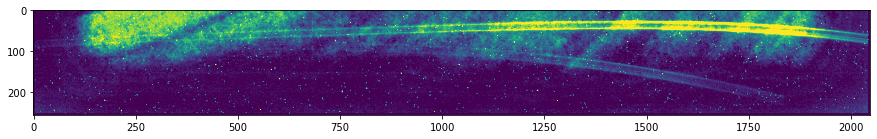

In [12]:
plt.figure(figsize=(15, 5))
im = plt.imshow(w43_seg1[0, 5, :, :])
im.set_clim(10000,20000)

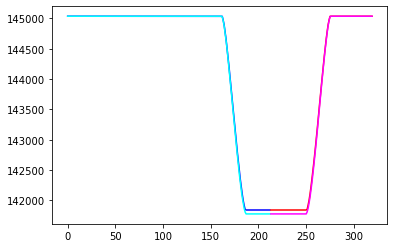

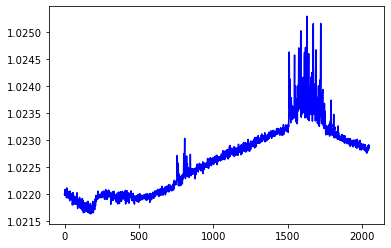

In [28]:
# Check for wavelength dependence of lightcurves in seed data
lcs1_1 = np.sum(w43_seed_seg1[:, 5, :, 1200], axis=-1)
lcs2_1 = np.sum(w43_seed_seg2[:, 5, :, 1200], axis=-1)
lcs1_2 = np.sum(w43_seed_seg1[:, 5, :, 100], axis=-1)
lcs2_2 = np.sum(w43_seed_seg2[:, 5, :, 100], axis=-1)
lcs1_2 *= lcs1_1[0]/lcs1_2[0]
lcs2_2 *= lcs2_1[-1]/lcs2_2[-1]

plt.figure()
plt.plot(np.arange(len(lcs1_1)), lcs1_1, color='blue')
plt.plot(np.arange(len(lcs2_1)) + len(lcs1_1), lcs2_1, color='red')
plt.plot(np.arange(len(lcs1_2)), lcs1_2, color='cyan')
plt.plot(np.arange(len(lcs2_2)) + len(lcs1_2), lcs2_2, color='magenta')
plt.show()

# "Extracted" transit spectrum
no_transit = np.sum(w43_seed_seg1[0, 5, :, :], axis=-2)
in_transit = np.sum(w43_seed_seg1[-1, 5, :, :], axis=-2)
plt.figure()
plt.plot(np.arange(2048), (no_transit/in_transit)[::-1], color='blue')
plt.show()

### 2.3 Run F277W simulation with `mirage.soss_simulator.SossSim`

Now we can run the accompanying F277W simulation. This is not necessary but can aid in the spectral extraction since the F277W filter blocks all of order 2 and 3 and part of order 1, leaving us with a small wavelength range of completely uncontaminated flux.

As this observation will take place after the transit has been observed with the CLEAR filter, no transit needs to be injected here.

In [17]:
sim_f277w = SossSim(paramfile = 'files/niriss_soss_substrip256_f277w.yaml', star=[star_wavelength, star_flux])
sim_f277w.create()

Simulating WASP43 in WASP43 transit observation
Configuration: SUBSTRIP256 + F277W
Groups: 6, Integrations: 25

Constructing frames for chunk 1/4...
Chunk 1/4 finished: 48.434 s
Constructing frames for chunk 2/4...
Chunk 2/4 finished: 38.123 s
Constructing frames for chunk 3/4...
Chunk 3/4 finished: 40.823 s
Constructing frames for chunk 4/4...
Chunk 4/4 finished: 4.509 s
Starting noise generator...
2021-06-23 11:18:36,410 - mirage.dark.dark_prep - INFO - 

Running dark_prep..

2021-06-23 11:18:36,411 - mirage.dark.dark_prep - INFO - Reading parameter file: files/niriss_soss_substrip256_f277w.yaml

2021-06-23 11:18:36,412 - mirage.dark.dark_prep - INFO - Original log file name: ./mirage_latest.log
2021-06-23 11:18:36,415 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits as the badpixmask reference file.
2021-06-23 11:18:36,416 - mirage.utils.utils.full_paths - INFO - From CRDS, found /Users/jfilippa

2021-06-23 11:18:36,506 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits
2021-06-23 11:18:36,506 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits
2021-06-23 11:18:36,507 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits
2021-06-23 11:18:36,508 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_SE_2015-12-11T16h05m20_dms_uncal.fits
2021-06-23 11:18:36,508 - mirage.dark.dark_prep - INFO - /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits
2021-06-23 11:18:36,509 - mirage.dark.dark_prep - 

2021-06-23 11:18:41,981 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:18:41,981 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:18:42,294 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:42,294 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:42,296 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:42,296 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:42,308 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:18:42,308 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:18:42,687 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:18:42,687 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:18:42,703 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:18:42,703 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:18:42,777 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:42,777 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:42,779 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:42,779 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:42,794 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:18:42,794 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:18:42,882 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:18:43,217 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels
2021-06-23 11:18:43,237 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:18:43,248 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:18:43,248 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:18:43,266 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:18:43,266 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:18:43,357 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:43,357 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:43,360 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:43,360 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:43,373 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:18:43,373 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:18:43,535 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:18:43,535 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:18:43,551 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:18:43,551 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:18:43,644 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:43,644 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:43,647 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:18:43,647 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:18:43,660 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:18:43,660 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:18:43,662 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:18:43,662 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:18:43,663 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:18:43,663 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:18:43,665 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:18:43,665 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:18:43,666 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:18:43,666 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:18:45,709 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:18:45,709 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:18:45,772 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:18:45,772 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:18:45,863 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:45,863 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:45,866 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:45,866 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:45,883 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:18:45,883 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:18:46,063 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:18:46,452 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:18:46,452 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:18:46,454 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:18:46,455 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:18:46,559 - mirage.dark.dark_prep - INFO - File number 0 will be used for integrations [0]
2021-06-23 11:18:46,564 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits
2021-06-23 11:18:49,257 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_19_496_SE_2015-12-11T18h36m32_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:18:49,561 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:18:49,562 - mirage.d

2021-06-23 11:18:53,202 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:18:53,202 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:18:53,709 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:53,709 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:53,712 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:53,712 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:53,724 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:18:53,724 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:18:54,058 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:18:54,058 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:18:54,071 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:18:54,071 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:18:54,146 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:54,146 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:54,148 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:54,148 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:54,164 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:18:54,164 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:18:54,239 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:18:54,490 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels
2021-06-23 11:18:54,510 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:18:54,518 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:18:54,518 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:18:54,532 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:18:54,532 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:18:54,617 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:54,617 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:54,620 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:54,620 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:54,633 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:18:54,633 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:18:54,782 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:18:54,782 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:18:54,799 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:18:54,799 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:18:54,888 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:54,888 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:54,891 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:18:54,891 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:18:54,905 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:18:54,905 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:18:54,907 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:18:54,907 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:18:54,909 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:18:54,909 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:18:54,910 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:18:54,910 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:18:54,912 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:18:54,912 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:18:56,926 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:18:56,926 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:18:56,964 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:18:56,964 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:18:57,050 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:57,050 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:18:57,052 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:57,052 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:18:57,065 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:18:57,065 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:18:57,219 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:18:57,607 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:18:57,607 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:18:57,609 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:18:57,609 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:18:57,620 - mirage.dark.dark_prep - INFO - File number 1 will be used for integrations [24]
2021-06-23 11:18:57,625 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits
2021-06-23 11:19:00,680 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_19_496_SE_2017-09-07T06h49m52_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:19:01,078 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:19:01,088 - mirage.

2021-06-23 11:19:04,111 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:04,111 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:04,643 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:04,643 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:04,646 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:04,646 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:04,659 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:04,659 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:04,981 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:04,981 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:04,995 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:04,995 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:05,071 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:05,071 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:05,074 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:05,074 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:05,088 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:19:05,088 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:19:05,153 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:19:05,404 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels
2021-06-23 11:19:05,423 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:19:05,431 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:05,431 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:05,446 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:05,446 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:05,531 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:05,531 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:05,534 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:05,534 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:05,551 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:05,551 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:05,690 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:05,690 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:05,704 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:05,704 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:05,794 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:05,794 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:05,797 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:05,797 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:05,810 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:05,810 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:05,812 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:05,812 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:05,813 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:05,813 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:05,815 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:05,815 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:05,816 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:05,816 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:07,835 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:07,835 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:07,872 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:07,872 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:07,958 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:07,958 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:07,961 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:07,961 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:07,974 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:19:07,974 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:19:08,073 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:19:08,465 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:19:08,465 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:19:08,467 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:19:08,468 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:19:08,477 - mirage.dark.dark_prep - INFO - File number 2 will be used for integrations [5]
2021-06-23 11:19:08,481 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_17_496_SE_2017-09-07T06h09m02_dms_uncal.fits
2021-06-23 11:19:08,482 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_SE_2017-09-07T07h29m52_dms_uncal.fits
2021-06-23 11:19:11,339 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_21_496_S

2021-06-23 11:19:14,455 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:14,455 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:14,924 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:14,924 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:14,927 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:14,927 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:14,938 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:14,938 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:15,254 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:15,254 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:15,268 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:15,268 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:15,344 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:15,344 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:15,347 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:15,347 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:15,360 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:19:15,360 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:19:15,422 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:19:15,666 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels
2021-06-23 11:19:15,685 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:19:15,691 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:15,691 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:15,707 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:15,707 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:15,793 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:15,793 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:15,795 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:15,795 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:15,808 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:15,808 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:15,958 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:15,958 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:15,971 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:15,971 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:16,057 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:16,057 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:16,060 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:16,060 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:16,075 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:16,075 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:16,077 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:16,077 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:16,078 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:16,078 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:16,079 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:16,079 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:16,081 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:16,081 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:18,050 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:18,050 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:18,083 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:18,083 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:18,166 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:18,166 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:18,168 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:18,168 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:18,181 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:19:18,181 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:19:18,288 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:19:18,679 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:19:18,679 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:19:18,681 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:19:18,682 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:19:18,691 - mirage.dark.dark_prep - INFO - File number 4 will be used for integrations [7 8 9]
2021-06-23 11:19:18,701 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits
2021-06-23 11:19:21,329 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_20_496_SE_2015-12-11T18h53m52_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:19:21,679 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:19:21,690 - mira

2021-06-23 11:19:24,302 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:24,302 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:24,716 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:24,716 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:24,718 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:24,718 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:24,730 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:24,730 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:25,051 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:25,051 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:25,064 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:25,064 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:25,132 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:25,132 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:25,135 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:25,135 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:25,147 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:19:25,147 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:19:25,202 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:19:25,443 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels
2021-06-23 11:19:25,461 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:19:25,466 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:25,466 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:25,482 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:25,482 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:25,564 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:25,564 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:25,566 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:25,566 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:25,576 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:25,576 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:25,707 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:25,707 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:25,719 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:25,719 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:25,798 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:25,798 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:25,800 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:25,800 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:25,810 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:25,810 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:25,811 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:25,811 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:25,812 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:25,812 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:25,813 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:25,813 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:25,814 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:25,814 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:27,813 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:27,813 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:27,850 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:27,850 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:27,936 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:27,936 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:27,939 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:27,939 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:27,950 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:19:27,950 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:19:28,047 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:19:28,444 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:19:28,444 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:19:28,446 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:19:28,447 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:19:28,455 - mirage.dark.dark_prep - INFO - File number 5 will be used for integrations [15]
2021-06-23 11:19:28,458 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_12_496_SE_2015-12-11T16h23m51_dms_uncal.fits
2021-06-23 11:19:28,459 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_SE_2015-12-11T16h42m52_dms_uncal.fits
2021-06-23 11:19:32,079 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_13_496_

2021-06-23 11:19:35,533 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:35,533 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:36,052 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:36,052 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:36,054 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:36,054 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:36,067 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:36,067 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:36,462 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:36,462 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:36,479 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:36,479 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:36,560 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:36,560 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:36,563 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:36,563 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:36,577 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:19:36,577 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:19:36,662 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:19:36,950 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels
2021-06-23 11:19:36,974 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:19:36,982 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:36,982 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:37,002 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:37,002 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:37,101 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:37,101 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:37,104 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:37,104 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:37,121 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:37,121 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:37,293 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:37,293 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:37,310 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:37,310 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:37,410 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:37,410 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:37,413 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:37,413 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:37,427 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:37,427 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:37,428 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:37,428 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:37,430 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:37,430 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:37,431 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:37,431 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:37,433 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:37,433 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:39,554 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:39,554 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:39,594 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:39,594 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:39,685 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:39,685 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:39,687 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:39,687 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:39,701 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:19:39,701 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:19:39,892 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:19:40,356 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:19:40,356 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:19:40,358 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:19:40,359 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:19:40,374 - mirage.dark.dark_prep - INFO - File number 7 will be used for integrations [13 18 20]
2021-06-23 11:19:40,401 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits
2021-06-23 11:19:43,954 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_13_496_SE_2017-09-07T04h48m22_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:19:44,368 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:19:44,379 - m

2021-06-23 11:19:47,224 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:47,224 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:47,692 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:47,692 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:47,695 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:47,695 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:47,707 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:47,707 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:48,043 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:48,043 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:48,057 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:48,057 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:48,137 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:48,137 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:48,140 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:48,140 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:48,153 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:19:48,153 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:19:48,229 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:19:48,474 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels
2021-06-23 11:19:48,494 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:19:48,500 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:48,500 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:48,517 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:48,517 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:48,609 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:48,609 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:48,612 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:48,612 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:48,625 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:48,625 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:48,783 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:48,783 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:48,797 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:48,797 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:48,887 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:48,887 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:48,890 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:48,890 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:48,904 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:48,904 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:48,906 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:48,906 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:48,907 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:48,907 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:48,909 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:48,909 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:48,910 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:48,910 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:50,947 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:50,947 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:19:50,985 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:50,985 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:19:51,076 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:51,076 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:51,079 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:51,079 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:51,092 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:19:51,092 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:19:51,201 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:19:51,592 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:19:51,592 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:19:51,593 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:19:51,594 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:19:51,605 - mirage.dark.dark_prep - INFO - File number 8 will be used for integrations [11 17 21 23]
2021-06-23 11:19:51,635 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits
2021-06-23 11:19:54,509 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:19:54,873 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:19:54,883 

2021-06-23 11:19:57,354 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:57,354 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:19:57,906 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:57,906 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:57,908 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:57,908 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:57,920 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:57,920 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:19:58,269 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:58,269 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:19:58,288 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:58,288 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:19:58,377 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:58,377 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:58,380 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:58,380 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:58,394 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:19:58,394 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:19:58,465 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:19:58,719 - jwst.saturation.saturation - INFO - Detected 197 saturated pixels
2021-06-23 11:19:58,740 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:19:58,746 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:58,746 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:19:58,761 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:58,761 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:19:58,857 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:58,857 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:58,859 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:58,859 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:19:58,876 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:58,876 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:19:59,022 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:59,022 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:19:59,037 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:59,037 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:19:59,130 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:59,130 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:19:59,133 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:59,133 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:19:59,146 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:59,146 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:19:59,148 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:59,148 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:19:59,150 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:59,150 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:19:59,151 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:59,151 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:19:59,153 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:19:59,153 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:01,112 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:01,112 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:01,147 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:01,147 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:01,236 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:01,236 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:01,238 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:01,238 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:01,252 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:20:01,252 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:20:01,395 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:20:01,787 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:20:01,787 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:20:01,789 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:20:01,790 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:20:01,804 - mirage.dark.dark_prep - INFO - File number 9 will be used for integrations [ 3 19 22]
2021-06-23 11:20:01,827 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_14_496_SE_2017-09-07T05h06m42_dms_uncal.fits
2021-06-23 11:20:01,828 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_16_496_SE_2017-09-07T05h47m42_dms_uncal.fits
2021-06-23 11:20:01,829 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_11_496_S

2021-06-23 11:20:07,319 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:07,319 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:07,822 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:07,822 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:07,824 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:07,824 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:07,836 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:07,836 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:08,177 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:08,177 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:08,192 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:08,192 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:08,270 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:08,270 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:08,273 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:08,273 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:08,286 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:20:08,286 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:20:08,356 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:20:08,613 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels
2021-06-23 11:20:08,634 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:20:08,640 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:08,640 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:08,654 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:08,654 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:08,745 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:08,745 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:08,748 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:08,748 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:08,762 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:08,762 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:08,908 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:08,908 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:08,922 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:08,922 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:09,014 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:09,014 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:09,017 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:09,017 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:09,030 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:09,030 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:09,031 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:09,031 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:09,033 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:09,033 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:09,034 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:09,034 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:09,036 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:09,036 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:11,038 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:11,038 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:11,081 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:11,081 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:11,172 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:11,172 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:11,175 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:11,175 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:11,188 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:20:11,188 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:20:11,309 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:20:11,700 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:20:11,700 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:20:11,701 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:20:11,702 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:20:11,712 - mirage.dark.dark_prep - INFO - File number 12 will be used for integrations [12]
2021-06-23 11:20:11,715 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits
2021-06-23 11:20:14,681 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_22_496_SE_2017-09-07T07h50m32_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:20:15,097 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:20:15,107 - mirage

2021-06-23 11:20:17,936 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:17,936 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:18,446 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:18,446 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:18,449 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:18,449 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:18,460 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:18,460 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:18,812 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:18,812 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:18,826 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:18,826 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:18,903 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:18,903 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:18,906 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:18,906 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:18,919 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:20:18,919 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:20:18,987 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:20:19,267 - jwst.saturation.saturation - INFO - Detected 195 saturated pixels
2021-06-23 11:20:19,288 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:20:19,297 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:19,297 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:19,312 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:19,312 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:19,405 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:19,405 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:19,408 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:19,408 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:19,421 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:19,421 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:19,573 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:19,573 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:19,588 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:19,588 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:19,682 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:19,682 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:19,685 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:19,685 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:19,698 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:19,698 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:19,700 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:19,700 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:19,701 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:19,701 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:19,703 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:19,703 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:19,704 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:19,704 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:21,693 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:21,693 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:21,730 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:21,730 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:21,821 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:21,821 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:21,823 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:21,823 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:21,837 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:20:21,837 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:20:21,966 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:20:22,358 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:20:22,358 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:20:22,360 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:20:22,361 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:20:22,370 - mirage.dark.dark_prep - INFO - File number 13 will be used for integrations [1]
2021-06-23 11:20:22,374 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits
2021-06-23 11:20:25,042 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_14_496_SE_2015-12-11T17h01m50_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:20:25,376 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:20:25,385 - mirage.

2021-06-23 11:20:28,105 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:28,105 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:28,562 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:28,562 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:28,564 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:28,564 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:28,576 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:28,576 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:28,905 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:28,905 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:28,919 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:28,919 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:28,995 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:28,995 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:28,998 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:28,998 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:29,014 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:20:29,014 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:20:29,081 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:20:29,346 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels
2021-06-23 11:20:29,365 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:20:29,373 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:29,373 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:29,388 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:29,388 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:29,482 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:29,482 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:29,485 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:29,485 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:29,501 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:29,501 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:29,651 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:29,651 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:29,667 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:29,667 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:29,760 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:29,760 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:29,763 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:29,763 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:29,776 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:29,776 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:29,778 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:29,778 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:29,779 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:29,779 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:29,780 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:29,780 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:29,782 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:29,782 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:31,819 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:31,819 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:31,857 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:31,857 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:31,949 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:31,949 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:31,952 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:31,952 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:31,967 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:20:31,967 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:20:32,079 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:20:32,481 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:20:32,481 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:20:32,483 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:20:32,483 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:20:32,493 - mirage.dark.dark_prep - INFO - File number 14 will be used for integrations [ 2 16]
2021-06-23 11:20:32,506 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits
2021-06-23 11:20:35,174 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_18_496_SE_2015-12-11T18h16m31_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:20:35,539 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:20:35,549 - mir

2021-06-23 11:20:38,210 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:38,210 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:38,691 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:38,691 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:38,693 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:38,693 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:38,704 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:38,704 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:39,047 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:39,047 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:39,060 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:39,060 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:39,137 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:39,137 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:39,140 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:39,140 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:39,154 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:20:39,154 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:20:39,220 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:20:39,477 - jwst.saturation.saturation - INFO - Detected 186 saturated pixels
2021-06-23 11:20:39,499 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:20:39,507 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:39,507 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:39,521 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:39,521 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:39,614 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:39,614 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:39,616 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:39,616 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:39,630 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:39,630 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:39,778 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:39,778 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:39,792 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:39,792 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:39,884 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:39,884 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:39,886 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:39,886 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:39,902 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:39,902 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:39,904 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:39,904 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:39,906 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:39,906 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:39,907 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:39,907 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:39,909 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:39,909 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:41,874 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:41,874 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:41,913 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:41,913 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:42,003 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:42,003 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:42,006 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:42,006 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:42,019 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:20:42,019 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:20:42,158 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:20:42,551 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:20:42,551 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:20:42,552 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:20:42,553 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:20:42,563 - mirage.dark.dark_prep - INFO - File number 15 will be used for integrations [6]
2021-06-23 11:20:42,567 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_16_496_SE_2015-12-11T17h40m30_dms_uncal.fits
2021-06-23 11:20:42,568 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_20_496_SE_2017-09-07T07h09m22_dms_uncal.fits
2021-06-23 11:20:42,569 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-172500017_18_496_SE_2017

2021-06-23 11:20:48,375 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:48,375 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:48,883 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:48,883 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:48,886 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:48,886 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:48,897 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:48,897 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:49,259 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:49,259 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:49,272 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:49,272 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:49,351 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:49,351 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:49,354 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:49,354 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:49,367 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:20:49,367 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:20:49,436 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:20:49,694 - jwst.saturation.saturation - INFO - Detected 196 saturated pixels
2021-06-23 11:20:49,714 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:20:49,723 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:49,723 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:49,737 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:49,737 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:49,829 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:49,829 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:49,831 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:49,831 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:49,844 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:49,844 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:20:49,995 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:49,995 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:20:50,009 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:50,009 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:20:50,098 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:50,098 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:50,100 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:50,100 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:20:50,114 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:50,114 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:20:50,116 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:50,116 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:20:50,117 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:50,117 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:20:50,119 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:50,119 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:20:50,120 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:50,120 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:20:52,137 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:52,137 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:20:52,177 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:52,177 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:20:52,273 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:52,273 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:52,276 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:52,276 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:52,291 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:20:52,291 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:20:52,402 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:20:52,813 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:20:52,813 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:20:52,815 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:20:52,815 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:20:52,826 - mirage.dark.dark_prep - INFO - File number 18 will be used for integrations [ 4 10]
2021-06-23 11:20:52,834 - mirage.dark.dark_prep - INFO - Working on dark file: /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits
2021-06-23 11:20:55,582 - mirage.utils.read_fits.read_datamodel - INFO - Zeroframe in /Users/jfilippazzo/Documents/STScI/mirage_data/niriss/darks/raw/NISNIRISSDARK-153451235_17_496_SE_2015-12-11T17h59m52_dms_uncal.fits is all zeros. Returning None.
2021-06-23 11:20:55,950 - mirage.dark.dark_prep - INFO - Saving 0th frame from data to the zeroframe extension
2021-06-23 11:20:55,960 - mir

2021-06-23 11:20:58,562 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:58,562 - stpipe.dq_init - INFO - DQInitStep instance created.


2021-06-23 11:20:59,071 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:59,071 - stpipe.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:59,073 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:59,073 - stpipe.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:59,084 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:59,084 - stpipe.dq_init - INFO - Using MASK reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_mask_0014.fits


2021-06-23 11:20:59,438 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:59,438 - stpipe.dq_init - INFO - Step dq_init done


2021-06-23 11:20:59,452 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:59,452 - stpipe.saturation - INFO - SaturationStep instance created.


2021-06-23 11:20:59,528 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:59,528 - stpipe.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:20:59,530 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:59,530 - stpipe.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:20:59,545 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits


2021-06-23 11:20:59,545 - stpipe.saturation - INFO - Using SATURATION reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_saturation_0011.fits
2021-06-23 11:20:59,614 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_REP_LIMITS does not correspond to an existing DQ mnemonic, so will be ignored
2021-06-23 11:20:59,879 - jwst.saturation.saturation - INFO - Detected 187 saturated pixels
2021-06-23 11:20:59,899 - jwst.saturation.saturation - INFO - Detected 1 A/D floor pixels


2021-06-23 11:20:59,905 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:59,905 - stpipe.saturation - INFO - Step saturation done


2021-06-23 11:20:59,922 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:20:59,922 - stpipe.superbias - INFO - SuperBiasStep instance created.


2021-06-23 11:21:00,015 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:21:00,015 - stpipe.superbias - INFO - Step superbias running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:21:00,018 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:21:00,018 - stpipe.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:21:00,034 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:21:00,034 - stpipe.superbias - INFO - Using SUPERBIAS reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_superbias_0017.fits


2021-06-23 11:21:00,190 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:21:00,190 - stpipe.superbias - INFO - Step superbias done


2021-06-23 11:21:00,204 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:21:00,204 - stpipe.refpix - INFO - RefPixStep instance created.


2021-06-23 11:21:00,299 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:21:00,299 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:21:00,302 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:21:00,302 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}


2021-06-23 11:21:00,320 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:21:00,320 - stpipe.refpix - INFO - use_side_ref_pixels = True


2021-06-23 11:21:00,321 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:21:00,321 - stpipe.refpix - INFO - odd_even_columns = True


2021-06-23 11:21:00,323 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:21:00,323 - stpipe.refpix - INFO - side_smoothing_length = 11


2021-06-23 11:21:00,325 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:21:00,325 - stpipe.refpix - INFO - side_gain = 1.000000


2021-06-23 11:21:00,326 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:21:00,326 - stpipe.refpix - INFO - odd_even_rows = False


2021-06-23 11:21:02,369 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:21:02,369 - stpipe.refpix - INFO - Step refpix done


2021-06-23 11:21:02,404 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:21:02,404 - stpipe.linearity - INFO - LinearityStep instance created.


2021-06-23 11:21:02,495 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:21:02,495 - stpipe.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 2048, 2048) from NISNIRISSDARK-172500017_15_496_SE_2017-09-07T05h28m22_dms_uncal.fits>,).


2021-06-23 11:21:02,498 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:21:02,498 - stpipe.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-06-23 11:21:02,511 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits


2021-06-23 11:21:02,511 - stpipe.linearity - INFO - Using Linearity reference file /Users/jfilippazzo/crds_cache/references/jwst/niriss/jwst_niriss_linearity_0013.fits
2021-06-23 11:21:02,656 - jwst.datamodels.dynamicdq - WARNING - Keyword CDP_AVERAGED_COEFFICIENTS does not correspond to an existing DQ mnemonic, so will be ignored


2021-06-23 11:21:03,060 - stpipe.linearity - INFO - Step linearity done


2021-06-23 11:21:03,060 - stpipe.linearity - INFO - Step linearity done
2021-06-23 11:21:03,062 - mirage.dark.dark_prep - INFO - Linearized dark shape: (1, 6, 2048, 2048)
2021-06-23 11:21:03,063 - mirage.dark.dark_prep - INFO - Output is NISRAPID, grabbing zero frame from linearized dark
2021-06-23 11:21:03,073 - mirage.dark.dark_prep - INFO - File number 19 will be used for integrations [14]
2021-06-23 11:21:04,602 - mirage.dark.dark_prep - INFO - Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.
2021-06-23 11:21:04,603 - mirage.dark.dark_prep - INFO - 

Segment 1 out of 1 complete.
2021-06-23 11:21:04,608 - mirage.seed_image.save_seed.save - INFO - Seed image is 4D.
2021-06-23 11:21:06,053 - mirage.soss_simulator - INFO - Running observation generator for segment 0/1
20

2021-06-23 11:21:06,845 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5
2021-06-23 11:21:06,865 - mirage.ramp_generator.obs_generator - INFO - Integration 1:
2021-06-23 11:21:06,909 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0
2021-06-23 11:21:06,946 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1
2021-06-23 11:21:06,982 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2
2021-06-23 11:21:07,025 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3
2021-06-23 11:21:07,065 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4
2021-06-23 11:21:07,096 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5
2021-06-23 11:21:07,115 - mirage.ramp_generator.obs_generator - INFO - Integration 2:
2021-06-23 11:21:07,157 - mirage.ramp_generator.obs_generator - INFO -     Averaging f

2021-06-23 11:21:09,273 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1
2021-06-23 11:21:09,305 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2
2021-06-23 11:21:09,333 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3
2021-06-23 11:21:09,362 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4
2021-06-23 11:21:09,397 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5
2021-06-23 11:21:09,417 - mirage.ramp_generator.obs_generator - INFO - Integration 13:
2021-06-23 11:21:09,454 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0
2021-06-23 11:21:09,483 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1
2021-06-23 11:21:09,511 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2
2021-06-23 11:21:09,539 - mirage.ramp_generator.obs_generator - I

2021-06-23 11:21:11,555 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4
2021-06-23 11:21:11,583 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5
2021-06-23 11:21:11,603 - mirage.ramp_generator.obs_generator - INFO - Integration 24:
2021-06-23 11:21:11,639 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 0 into group 0
2021-06-23 11:21:11,671 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 1 into group 1
2021-06-23 11:21:11,701 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 2 into group 2
2021-06-23 11:21:11,730 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 3 into group 3
2021-06-23 11:21:11,755 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 4 into group 4
2021-06-23 11:21:11,781 - mirage.ramp_generator.obs_generator - INFO -     Averaging frame 5 into group 5
2021-06-23 11:21:17,308 - mirage.ramp_generator.obs_generator - I

WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_linear.fits complete.


2021-06-23 11:21:20,117 - mirage.utils.set_telescope_pointing_separated - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_linear.fits complete.
2021-06-23 11:21:20,119 - mirage.ramp_generator.obs_generator - INFO - Final linearized exposure saved to:
2021-06-23 11:21:20,120 - mirage.ramp_generator.obs_generator - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_linear.fits
2021-06-23 11:21:20,122 - mirage.ramp_generator.obs_generator - INFO - Unlinearizing exposure.
2021-06-23 11:24:49,476 - mirage.ramp_generator.obs_generator - INFO - Adding superbias and reference pixel signals.
2021-06-23 11:24:51,075 - mirage.ramp_generator.obs_generator - INFO - 
2021-06-23 11:24:51,076 - mirage.ramp_generator.obs_generator - INFO - 
2021-06-23 11:24:51,077 - mirage.ramp_generator.obs_generator - INFO - Populating xref_sci in output file:
2021-06-23 11:24:51,078 - mirage.ramp_generator.obs_generator - WARNING

WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_uncal.fits complete.


2021-06-23 11:24:51,786 - mirage.utils.set_telescope_pointing_separated - INFO - WCS info for /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_uncal.fits complete.
2021-06-23 11:24:51,788 - mirage.ramp_generator.obs_generator - INFO - Final raw exposure saved to: 
2021-06-23 11:24:51,790 - mirage.ramp_generator.obs_generator - INFO - /Users/jfilippazzo/Documents/Modules/ers-soss-simulations/WASP43_NIS_SOSS_F277W_uncal.fits
2021-06-23 11:24:51,791 - mirage.ramp_generator.obs_generator - INFO - 
2021-06-23 11:24:51,792 - mirage.ramp_generator.obs_generator - INFO - 
2021-06-23 11:24:51,793 - mirage.ramp_generator.obs_generator - INFO - Segment 1 out of 1 complete.
2021-06-23 11:24:51,794 - mirage.ramp_generator.obs_generator - INFO - Observation generation complete.
2021-06-23 11:24:52,150 - mirage.soss_simulator - INFO - 
SOSS simulator complete
Noise model finished: 375.761 s

Total time: 508.042 s
